In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from InceptionV3 layers ...")
bnfeatures = base_model.predict(X)

Extracting features from InceptionV3 layers ...


In [8]:
print(bnfeatures)

[[ 0.90356851  0.13943291  0.07777077 ...,  0.40672967  0.34032848
   0.60997432]
 [ 1.16690695  0.09074067  0.15060773 ...,  0.24265675  0.74490297
   1.1260246 ]
 [ 1.05232227  0.03605892  0.21473916 ...,  0.25069928  0.488002
   0.55230409]
 ..., 
 [ 1.10749805  0.45179945  0.08786708 ...,  1.31577456  0.51913744
   1.29420662]
 [ 1.10749805  0.45179945  0.08786708 ...,  1.31577456  0.51913744
   1.29420662]
 [ 1.10749805  0.45179945  0.08786708 ...,  1.31577456  0.51913744
   1.29420662]]


In [9]:
bnfeatures.shape

(9339, 2048)

In [10]:
# Adding a custom top layer to the model
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 111, 111, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 111, 111, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 111, 111, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [11]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=bnfeatures.shape[1:], name='bottleneck_features')
predictions = Dense(num_classes, activation='softmax', name='predictions')(bottleneck_features)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 25)                51225     
Total params: 51,225
Trainable params: 51,225
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [13]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='malimg-inceptionv3-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [14]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    bnfeatures_train = bnfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    bnfeatures_test = bnfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(bnfeatures_train, Y_train, validation_data=(bnfeatures_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_top_weights = top_model.get_weights()
          
    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-1].set_weights(init_top_weights)
    
    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Initial acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.0180
Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 0s - loss: 0.6244 - acc: 0.8429 - val_loss: 0.2682 - val_acc: 0.9323
Epoch 2/100
8394/8394 [==============================] - 0s - loss: 0.1699 - acc: 0.9548 - val_loss: 0.1804 - val_acc: 0.9481
Epoch 3/100
8394/8394 [==============================] - 0s - loss: 0.1264 - acc: 0.9641 - val_loss: 0.1526 - val_acc: 0.9545
Epoch 4/100
8394/8394 [==============================] - 0s - loss: 0.1059 - acc: 0.9684 - val_loss: 0.1468 - val_acc: 0.9545
Epoch 5/100
8394/8394 [==============================] - 0s - loss: 0.1035 - acc: 0.9718 - val_loss: 0.1300 - val_acc: 0.9545
Epoch 6/100
8394/8394 [==============================] - 0s - loss: 0.0917 - acc: 0.9714 - val_loss: 0.1311 - val_acc: 0.9556
Epoch 7/100
8394/8394 [==============================] - 0s - loss: 0.0797 - acc: 0.9775 - val_loss: 0.1216 - val_acc: 0.

8394/8394 [==============================] - 65s - loss: 0.0430 - acc: 0.9871 - val_loss: 0.1270 - val_acc: 0.9651
Epoch 28/100
8394/8394 [==============================] - 66s - loss: 0.0403 - acc: 0.9882 - val_loss: 0.1327 - val_acc: 0.9619
Epoch 29/100
8394/8394 [==============================] - 66s - loss: 0.0399 - acc: 0.9882 - val_loss: 0.1350 - val_acc: 0.9630
Epoch 30/100
8394/8394 [==============================] - 66s - loss: 0.0402 - acc: 0.9880 - val_loss: 0.1341 - val_acc: 0.9640
Epoch 31/100
8394/8394 [==============================] - 65s - loss: 0.0389 - acc: 0.9881 - val_loss: 0.1306 - val_acc: 0.9672
Epoch 32/100
8394/8394 [==============================] - 66s - loss: 0.0396 - acc: 0.9882 - val_loss: 0.1340 - val_acc: 0.9672
Epoch 33/100
8394/8394 [==============================] - 65s - loss: 0.0383 - acc: 0.9882 - val_loss: 0.1337 - val_acc: 0.9672
Epoch 34/100
8394/8394 [==============================] - 66s - loss: 0.0373 - acc: 0.9884 - val_loss: 0.1316 - val_a

8397/8397 [==============================] - 0s - loss: 0.0402 - acc: 0.9887 - val_loss: 0.1069 - val_acc: 0.9660
Epoch 55/100
8397/8397 [==============================] - 0s - loss: 0.0388 - acc: 0.9887 - val_loss: 0.0981 - val_acc: 0.9682
Epoch 56/100
8397/8397 [==============================] - 0s - loss: 0.0363 - acc: 0.9887 - val_loss: 0.0978 - val_acc: 0.9671
Epoch 57/100
8397/8397 [==============================] - 0s - loss: 0.0410 - acc: 0.9890 - val_loss: 0.1077 - val_acc: 0.9660
Epoch 58/100
8397/8397 [==============================] - 0s - loss: 0.0378 - acc: 0.9887 - val_loss: 0.0997 - val_acc: 0.9703
Epoch 59/100
8397/8397 [==============================] - 0s - loss: 0.0372 - acc: 0.9887 - val_loss: 0.1040 - val_acc: 0.9692
Epoch 60/100
8397/8397 [==============================] - 0s - loss: 0.0372 - acc: 0.9887 - val_loss: 0.1014 - val_acc: 0.9682
Epoch 61/100
8397/8397 [==============================] - 0s - loss: 0.0380 - acc: 0.9887 - val_loss: 0.1122 - val_acc: 0.96

8397/8397 [==============================] - 67s - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0846 - val_acc: 0.9830
Epoch 82/100
8397/8397 [==============================] - 67s - loss: 0.0030 - acc: 0.9992 - val_loss: 0.0793 - val_acc: 0.9809
Epoch 83/100
8397/8397 [==============================] - 67s - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0816 - val_acc: 0.9788
Epoch 84/100
8397/8397 [==============================] - 67s - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0878 - val_acc: 0.9777
Epoch 85/100
8397/8397 [==============================] - 67s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0903 - val_acc: 0.9777
Epoch 86/100
8397/8397 [==============================] - 67s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0876 - val_acc: 0.9788
Epoch 87/100
8397/8397 [==============================] - 67s - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0871 - val_acc: 0.9777
Epoch 88/100
8397/8397 [==============================] - 67s - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0836 - val_a

8401/8401 [==============================] - 0s - loss: 0.0387 - acc: 0.9887 - val_loss: 0.1346 - val_acc: 0.9648
Epoch 45/100
8401/8401 [==============================] - 0s - loss: 0.0388 - acc: 0.9887 - val_loss: 0.1405 - val_acc: 0.9648
Epoch 46/100
8401/8401 [==============================] - 0s - loss: 0.0382 - acc: 0.9887 - val_loss: 0.1368 - val_acc: 0.9638
Epoch 47/100
8401/8401 [==============================] - 0s - loss: 0.0388 - acc: 0.9887 - val_loss: 0.1502 - val_acc: 0.9648
Epoch 48/100
8401/8401 [==============================] - 0s - loss: 0.0440 - acc: 0.9887 - val_loss: 0.1436 - val_acc: 0.9638
Epoch 49/100
8401/8401 [==============================] - 0s - loss: 0.0379 - acc: 0.9887 - val_loss: 0.1416 - val_acc: 0.9638
Epoch 50/100
8401/8401 [==============================] - 0s - loss: 0.0375 - acc: 0.9887 - val_loss: 0.1585 - val_acc: 0.9638
Epoch 51/100
8401/8401 [==============================] - 0s - loss: 0.0390 - acc: 0.9887 - val_loss: 0.1449 - val_acc: 0.96

8401/8401 [==============================] - 64s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0928 - val_acc: 0.9776
Epoch 72/100
8401/8401 [==============================] - 64s - loss: 0.0071 - acc: 0.9983 - val_loss: 0.0871 - val_acc: 0.9797
Epoch 73/100
8401/8401 [==============================] - 65s - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0941 - val_acc: 0.9776
Epoch 74/100
8401/8401 [==============================] - 65s - loss: 7.2986e-04 - acc: 1.0000 - val_loss: 0.0931 - val_acc: 0.9744
Epoch 75/100
8401/8401 [==============================] - 65s - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0928 - val_acc: 0.9755
Epoch 76/100
8401/8401 [==============================] - 65s - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0934 - val_acc: 0.9776
Epoch 77/100
8401/8401 [==============================] - 64s - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0907 - val_acc: 0.9787
Epoch 78/100
8401/8401 [==============================] - 65s - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0896 - v

8403/8403 [==============================] - 0s - loss: 0.0356 - acc: 0.9887 - val_loss: 0.1289 - val_acc: 0.9701
Epoch 98/100
8403/8403 [==============================] - 0s - loss: 0.0389 - acc: 0.9889 - val_loss: 0.1368 - val_acc: 0.9690
Epoch 99/100
8403/8403 [==============================] - 0s - loss: 0.0380 - acc: 0.9887 - val_loss: 0.1384 - val_acc: 0.9701
Epoch 100/100
8403/8403 [==============================] - 0s - loss: 0.0354 - acc: 0.9887 - val_loss: 0.1330 - val_acc: 0.9701
[3] Pre-trained acurracy (top_model): 0.9701
[3] Fine-tuning the model ...
Train on 8403 samples, validate on 936 samples
Epoch 1/100
8403/8403 [==============================] - 65s - loss: 1.7687 - acc: 0.7069 - val_loss: 5.9315 - val_acc: 0.4145
Epoch 2/100
8403/8403 [==============================] - 67s - loss: 0.4995 - acc: 0.8984 - val_loss: 2.9172 - val_acc: 0.5524
Epoch 3/100
8403/8403 [==============================] - 67s - loss: 0.3010 - acc: 0.9430 - val_loss: 0.2686 - val_acc: 0.9466
E

8404/8404 [==============================] - 0s - loss: 0.0438 - acc: 0.9877 - val_loss: 0.1038 - val_acc: 0.9636
Epoch 23/100
8404/8404 [==============================] - 0s - loss: 0.0456 - acc: 0.9882 - val_loss: 0.1028 - val_acc: 0.9658
Epoch 24/100
8404/8404 [==============================] - 0s - loss: 0.0435 - acc: 0.9882 - val_loss: 0.1089 - val_acc: 0.9668
Epoch 25/100
8404/8404 [==============================] - 0s - loss: 0.0428 - acc: 0.9882 - val_loss: 0.1130 - val_acc: 0.9636
Epoch 26/100
8404/8404 [==============================] - 0s - loss: 0.0441 - acc: 0.9882 - val_loss: 0.1057 - val_acc: 0.9658
Epoch 27/100
8404/8404 [==============================] - 0s - loss: 0.0436 - acc: 0.9886 - val_loss: 0.1057 - val_acc: 0.9668
Epoch 28/100
8404/8404 [==============================] - 0s - loss: 0.0419 - acc: 0.9887 - val_loss: 0.1059 - val_acc: 0.9647
Epoch 29/100
8404/8404 [==============================] - 0s - loss: 0.0434 - acc: 0.9874 - val_loss: 0.1045 - val_acc: 0.96

8404/8404 [==============================] - 65s - loss: 0.0041 - acc: 0.9989 - val_loss: 0.2012 - val_acc: 0.8963
Epoch 50/100
8404/8404 [==============================] - 65s - loss: 0.0033 - acc: 0.9995 - val_loss: 0.0648 - val_acc: 0.9829
Epoch 51/100
8404/8404 [==============================] - 65s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0649 - val_acc: 0.9818
Epoch 52/100
8404/8404 [==============================] - 65s - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0616 - val_acc: 0.9818
Epoch 53/100
8404/8404 [==============================] - 65s - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0623 - val_acc: 0.9829
Epoch 54/100
8404/8404 [==============================] - 65s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 0.9829
Epoch 55/100
8404/8404 [==============================] - 65s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0602 - val_acc: 0.9818
Epoch 56/100
8404/8404 [==============================] - 65s - loss: 0.0016 - acc: 0.9999 - val_loss: 0.0563 - val_a

8404/8404 [==============================] - 0s - loss: 0.0409 - acc: 0.9888 - val_loss: 0.1134 - val_acc: 0.9701
Epoch 76/100
8404/8404 [==============================] - 0s - loss: 0.0364 - acc: 0.9887 - val_loss: 0.1139 - val_acc: 0.9690
Epoch 77/100
8404/8404 [==============================] - 0s - loss: 0.0370 - acc: 0.9887 - val_loss: 0.1143 - val_acc: 0.9701
Epoch 78/100
8404/8404 [==============================] - 0s - loss: 0.0374 - acc: 0.9887 - val_loss: 0.1128 - val_acc: 0.9701
Epoch 79/100
8404/8404 [==============================] - 0s - loss: 0.0413 - acc: 0.9887 - val_loss: 0.1276 - val_acc: 0.9679
Epoch 80/100
8404/8404 [==============================] - 0s - loss: 0.0382 - acc: 0.9875 - val_loss: 0.1153 - val_acc: 0.9701
Epoch 81/100
8404/8404 [==============================] - 0s - loss: 0.0386 - acc: 0.9883 - val_loss: 0.1219 - val_acc: 0.9701
Epoch 82/100
8404/8404 [==============================] - 0s - loss: 0.0365 - acc: 0.9887 - val_loss: 0.1154 - val_acc: 0.96

8408/8408 [==============================] - 0s - loss: 0.5030 - acc: 0.9007 - val_loss: 0.2744 - val_acc: 0.9506
Epoch 2/100
8408/8408 [==============================] - 0s - loss: 0.2447 - acc: 0.9586 - val_loss: 0.2743 - val_acc: 0.9506
Epoch 3/100
8408/8408 [==============================] - 0s - loss: 0.2281 - acc: 0.9632 - val_loss: 0.2538 - val_acc: 0.9527
Epoch 4/100
8408/8408 [==============================] - 0s - loss: 0.2166 - acc: 0.9675 - val_loss: 0.2602 - val_acc: 0.9538
Epoch 5/100
8408/8408 [==============================] - 0s - loss: 0.2125 - acc: 0.9712 - val_loss: 0.2653 - val_acc: 0.9538
Epoch 6/100
8408/8408 [==============================] - 0s - loss: 0.2017 - acc: 0.9738 - val_loss: 0.2493 - val_acc: 0.9570
Epoch 7/100
8408/8408 [==============================] - 0s - loss: 0.2012 - acc: 0.9725 - val_loss: 0.2489 - val_acc: 0.9560
Epoch 8/100
8408/8408 [==============================] - 0s - loss: 0.1972 - acc: 0.9743 - val_loss: 0.2456 - val_acc: 0.9592
Epoc

8408/8408 [==============================] - 66s - loss: 0.0623 - acc: 0.9792 - val_loss: 0.1193 - val_acc: 0.9603
Epoch 29/100
8408/8408 [==============================] - 65s - loss: 0.0605 - acc: 0.9795 - val_loss: 0.1251 - val_acc: 0.9560
Epoch 30/100
8408/8408 [==============================] - 65s - loss: 0.0609 - acc: 0.9795 - val_loss: 0.1227 - val_acc: 0.9581
Epoch 31/100
8408/8408 [==============================] - 65s - loss: 0.0596 - acc: 0.9797 - val_loss: 0.1268 - val_acc: 0.9560
Epoch 32/100
8408/8408 [==============================] - 65s - loss: 0.0581 - acc: 0.9791 - val_loss: 0.1253 - val_acc: 0.9549
Epoch 33/100
8408/8408 [==============================] - 66s - loss: 0.0552 - acc: 0.9807 - val_loss: 0.1227 - val_acc: 0.9570
Epoch 34/100
8408/8408 [==============================] - 65s - loss: 0.0531 - acc: 0.9850 - val_loss: 0.1181 - val_acc: 0.9624
Epoch 35/100
8408/8408 [==============================] - 66s - loss: 0.0479 - acc: 0.9877 - val_loss: 0.1195 - val_a

8408/8408 [==============================] - 65s - loss: 7.9640e-04 - acc: 1.0000 - val_loss: 0.0752 - val_acc: 0.9785
Epoch 93/100
8408/8408 [==============================] - 66s - loss: 7.9394e-04 - acc: 0.9999 - val_loss: 0.0723 - val_acc: 0.9785
Epoch 94/100
8408/8408 [==============================] - 65s - loss: 0.0015 - acc: 0.9993 - val_loss: 0.0745 - val_acc: 0.9807
Epoch 95/100
8408/8408 [==============================] - 65s - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0754 - val_acc: 0.9807
Epoch 96/100
8408/8408 [==============================] - 65s - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0733 - val_acc: 0.9796
Epoch 97/100
8408/8408 [==============================] - 65s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0720 - val_acc: 0.9807
Epoch 98/100
8408/8408 [==============================] - 66s - loss: 0.0046 - acc: 0.9990 - val_loss: 0.2220 - val_acc: 0.9710
Epoch 99/100
8408/8408 [==============================] - 65s - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0841

8410/8410 [==============================] - 67s - loss: 0.2137 - acc: 0.9794 - val_loss: 0.3117 - val_acc: 0.9516
Epoch 19/100
8410/8410 [==============================] - 67s - loss: 0.2148 - acc: 0.9786 - val_loss: 0.3032 - val_acc: 0.9516
Epoch 20/100
8410/8410 [==============================] - 67s - loss: 0.2116 - acc: 0.9794 - val_loss: 0.3027 - val_acc: 0.9559
Epoch 21/100
8410/8410 [==============================] - 67s - loss: 0.2119 - acc: 0.9793 - val_loss: 0.2976 - val_acc: 0.9559
Epoch 22/100
8410/8410 [==============================] - 67s - loss: 0.2103 - acc: 0.9797 - val_loss: 0.2943 - val_acc: 0.9548
Epoch 23/100
8410/8410 [==============================] - 67s - loss: 0.2094 - acc: 0.9806 - val_loss: 0.3020 - val_acc: 0.9494
Epoch 24/100
8410/8410 [==============================] - 67s - loss: 0.2095 - acc: 0.9811 - val_loss: 0.2963 - val_acc: 0.9548
Epoch 25/100
8410/8410 [==============================] - 67s - loss: 0.2058 - acc: 0.9830 - val_loss: 0.2944 - val_a

8414/8414 [==============================] - 0s - loss: 0.0408 - acc: 0.9886 - val_loss: 0.1036 - val_acc: 0.9686
Epoch 46/100
8414/8414 [==============================] - 0s - loss: 0.0389 - acc: 0.9886 - val_loss: 0.1009 - val_acc: 0.9697
Epoch 47/100
8414/8414 [==============================] - 0s - loss: 0.0384 - acc: 0.9886 - val_loss: 0.1015 - val_acc: 0.9697
Epoch 48/100
8414/8414 [==============================] - 0s - loss: 0.0412 - acc: 0.9887 - val_loss: 0.1009 - val_acc: 0.9719
Epoch 49/100
8414/8414 [==============================] - 0s - loss: 0.0375 - acc: 0.9886 - val_loss: 0.1176 - val_acc: 0.9708
Epoch 50/100
8414/8414 [==============================] - 0s - loss: 0.0386 - acc: 0.9886 - val_loss: 0.0993 - val_acc: 0.9708
Epoch 51/100
8414/8414 [==============================] - 0s - loss: 0.0393 - acc: 0.9886 - val_loss: 0.1017 - val_acc: 0.9719
Epoch 52/100
8414/8414 [==============================] - 0s - loss: 0.0389 - acc: 0.9886 - val_loss: 0.1044 - val_acc: 0.96

8414/8414 [==============================] - 67s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0967 - val_acc: 0.9816
Epoch 72/100
8414/8414 [==============================] - 68s - loss: 0.0014 - acc: 0.9995 - val_loss: 0.1026 - val_acc: 0.9827
Epoch 73/100
8414/8414 [==============================] - 68s - loss: 0.0010 - acc: 0.9998 - val_loss: 0.1052 - val_acc: 0.9849
Epoch 74/100
8414/8414 [==============================] - 68s - loss: 5.2754e-04 - acc: 1.0000 - val_loss: 0.1035 - val_acc: 0.9827
Epoch 75/100
8414/8414 [==============================] - 68s - loss: 9.3151e-04 - acc: 0.9999 - val_loss: 0.1044 - val_acc: 0.9827
Epoch 76/100
8414/8414 [==============================] - 67s - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1018 - val_acc: 0.9838
Epoch 77/100
8414/8414 [==============================] - 68s - loss: 5.2839e-04 - acc: 1.0000 - val_loss: 0.0998 - val_acc: 0.9827
Epoch 78/100
8414/8414 [==============================] - 68s - loss: 8.0216e-04 - acc: 0.9999 - val_loss

8416/8416 [==============================] - 0s - loss: 0.3570 - acc: 0.9689 - val_loss: 0.4409 - val_acc: 0.9545
Epoch 98/100
8416/8416 [==============================] - 0s - loss: 0.3524 - acc: 0.9683 - val_loss: 0.4585 - val_acc: 0.9534
Epoch 99/100
8416/8416 [==============================] - 0s - loss: 0.3542 - acc: 0.9689 - val_loss: 0.4349 - val_acc: 0.9534
Epoch 100/100
8416/8416 [==============================] - 0s - loss: 0.3548 - acc: 0.9693 - val_loss: 0.4518 - val_acc: 0.9545
[9] Pre-trained acurracy (top_model): 0.9545
[9] Fine-tuning the model ...
Train on 8416 samples, validate on 923 samples
Epoch 1/100
8416/8416 [==============================] - 110s - loss: 1.9187 - acc: 0.6905 - val_loss: 6.3947 - val_acc: 0.3922
Epoch 2/100
8416/8416 [==============================] - 110s - loss: 0.5854 - acc: 0.8846 - val_loss: 4.0113 - val_acc: 0.4529
Epoch 3/100
8416/8416 [==============================] - 108s - loss: 0.3669 - acc: 0.9240 - val_loss: 0.3141 - val_acc: 0.927

In [15]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9768


In [16]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

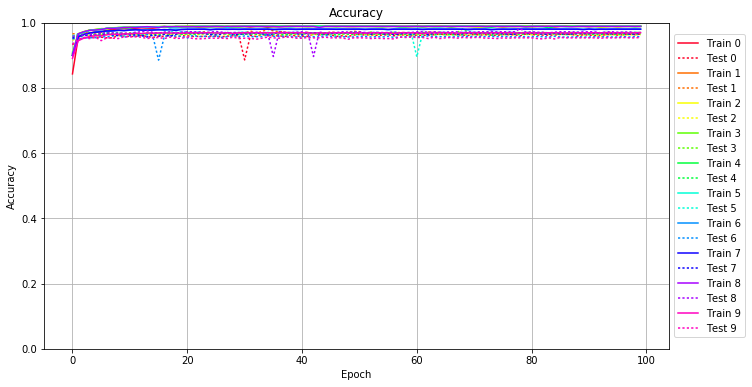

In [17]:
plot_acc(tophistory)

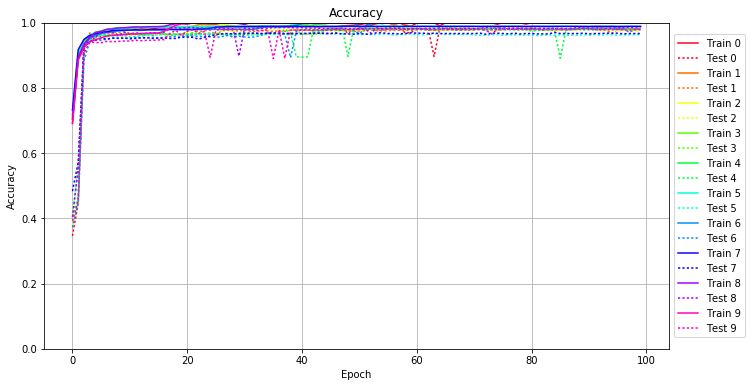

In [18]:
plot_acc(history)

In [19]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

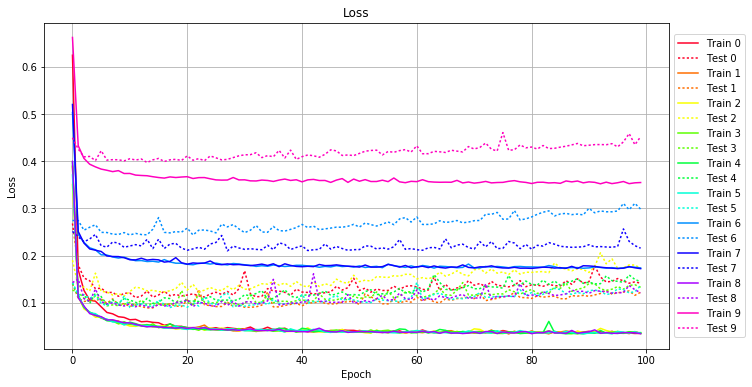

In [20]:
plot_loss(tophistory)

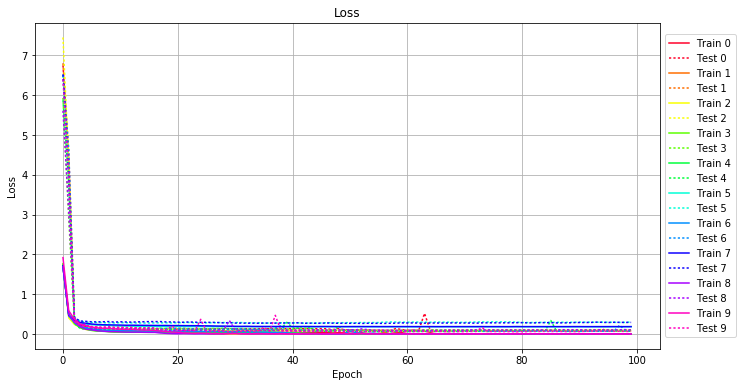

In [21]:
plot_loss(history)

Plotting the confusion matrix


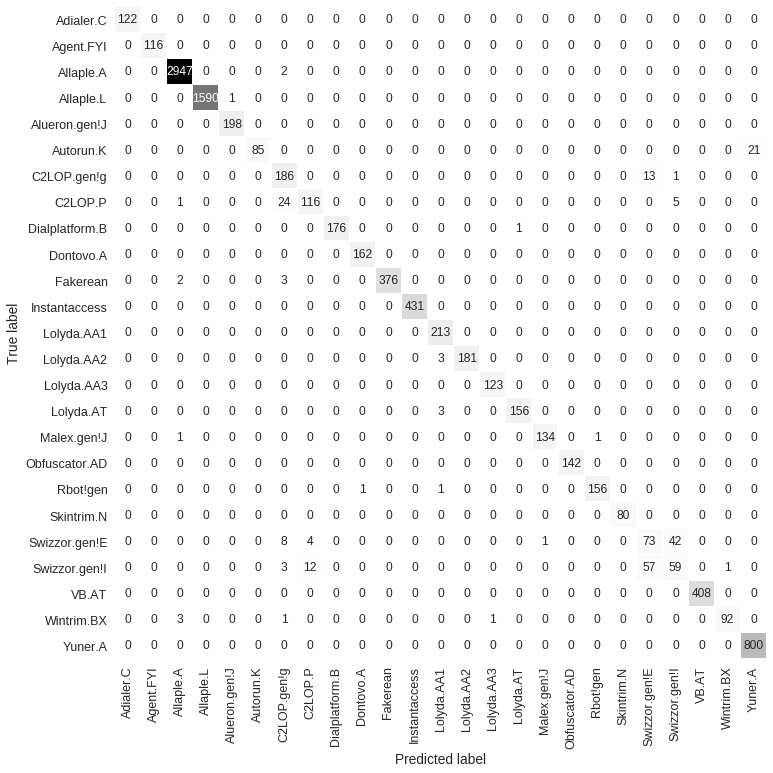

In [22]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


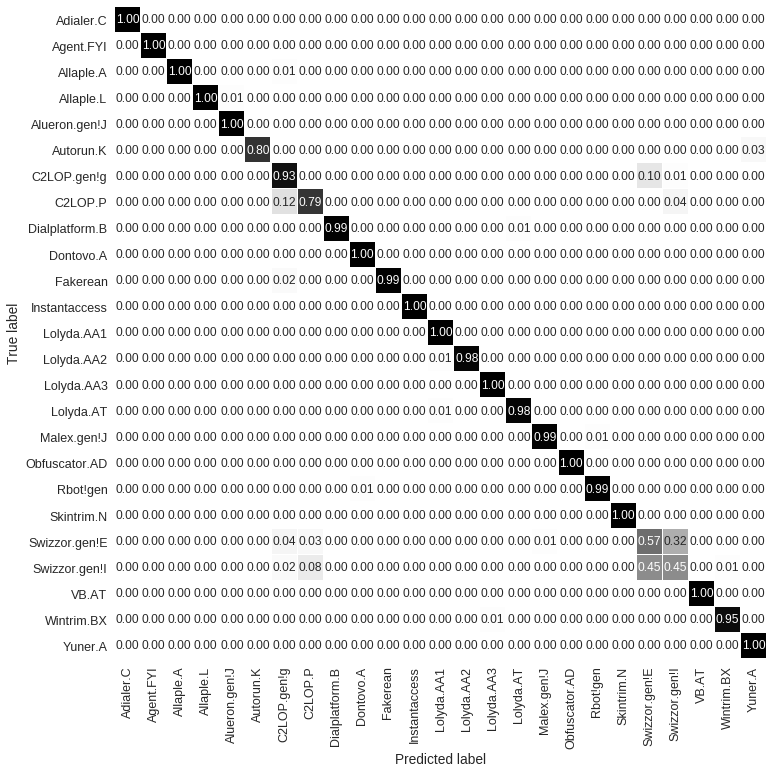

In [23]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
for h in tophistory:
    print(h.history)

{'acc': [0.84286395044079099, 0.9548487014676208, 0.96414105313319043, 0.96842983084574807, 0.97176554679075311, 0.97140814867762693, 0.97748391708363114, 0.97974743864665237, 0.98034310218746501, 0.98153442932589718, 0.98070050035739809, 0.98284488920657609, 0.9841553490588516, 0.98332142003354561, 0.98308315460585916, 0.98498927805575409, 0.98701453419108887, 0.98665713604955918, 0.98653800333571595, 0.98761019776030501, 0.98737193233261855, 0.9884441267572075, 0.98784846318799147, 0.98772933047414824, 0.98820586132952104, 0.98832499404336427, 0.98820586132952104, 0.98629973790802949, 0.98808672861567781, 0.98856325947105073, 0.98868239215649056, 0.98653800333571595, 0.98868239218489395, 0.98844412672880411, 0.98558494162497023, 0.98856325947105073, 0.98761019777450676, 0.98808672861567781, 0.98856325947105073, 0.98868239218489395, 0.98868239215649056, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239215649056, 0.98868239218489395, 0.98868239215649056, 0.98868

In [25]:
for h in history:
    print(h.history)

{'acc': [0.69144627116025847, 0.88980223966661676, 0.92578031927567306, 0.93983797956598014, 0.95556349773647842, 0.97116988322153697, 0.97712651891369806, 0.98010483680238381, 0.98224922563736006, 0.98272575654953986, 0.98463187991422441, 0.98606147249454479, 0.98320228736230753, 0.98439361451494145, 0.98141529664045746, 0.98391708360276164, 0.9841553490304481, 0.98618060516578288, 0.98653800333571595, 0.98570407433881346, 0.98737193233261855, 0.98749106507486517, 0.98749106501805828, 0.98796759587343119, 0.98808672858727442, 0.98784846324479836, 0.98713366690493209, 0.98820586130111765, 0.98820586132952104, 0.98796759587343119, 0.98808672861567781, 0.98820586132952104, 0.98820586132952104, 0.98844412672880411, 0.98772933047414824, 0.98832499401496088, 0.98808672864408131, 0.98749106501805828, 0.98749106504646178, 0.9884441267572075, 0.98820586130111765, 0.98844412672880411, 0.98808672867248482, 0.98772933050255163, 0.98808672858727442, 0.98844412672880411, 0.98856325944264734, 0.9901

In [26]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

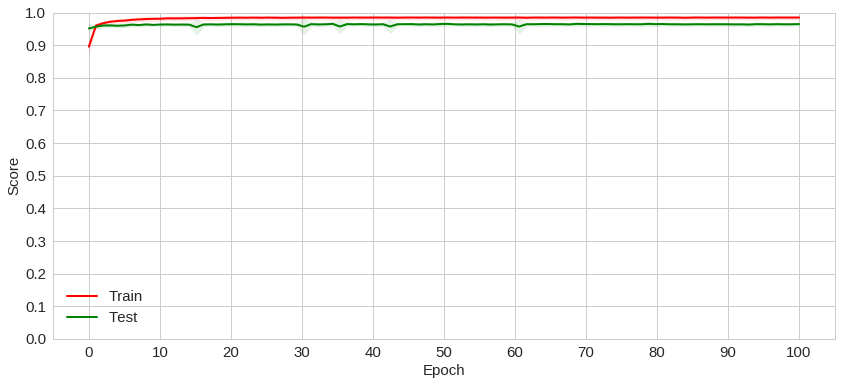

In [27]:
plot_mean_acc(tophistory)

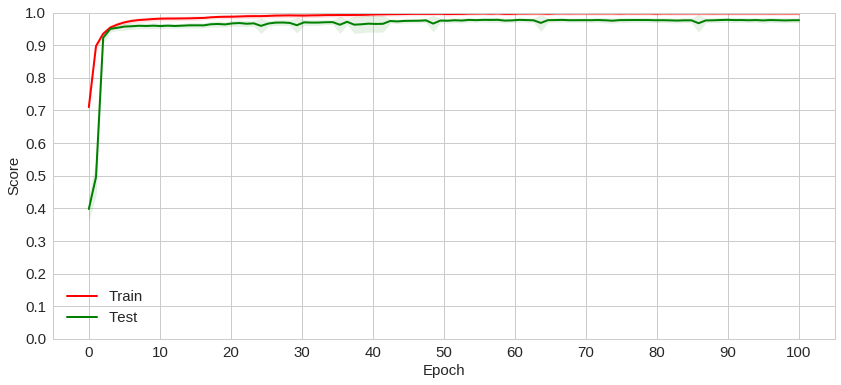

In [28]:
plot_mean_acc(history)

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

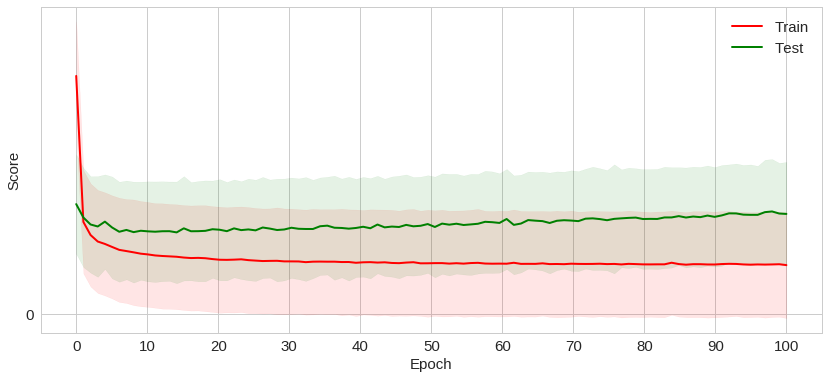

In [30]:
plot_mean_loss(tophistory)

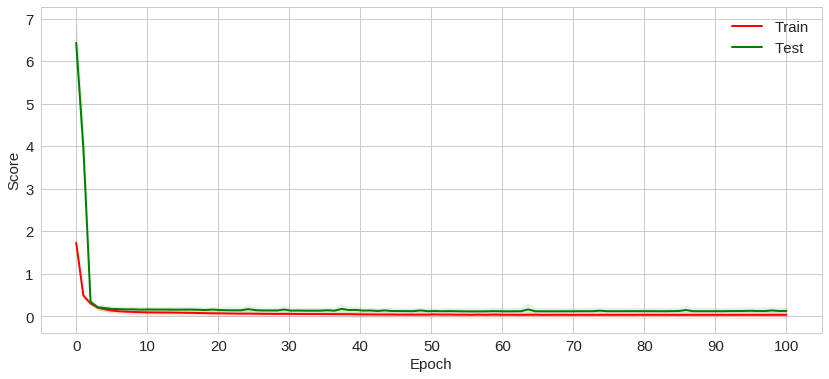

In [31]:
plot_mean_loss(history)

In [33]:
tophist = [{'acc': [0.84286395044079099, 0.9548487014676208, 0.96414105313319043, 0.96842983084574807, 0.97176554679075311, 0.97140814867762693, 0.97748391708363114, 0.97974743864665237, 0.98034310218746501, 0.98153442932589718, 0.98070050035739809, 0.98284488920657609, 0.9841553490588516, 0.98332142003354561, 0.98308315460585916, 0.98498927805575409, 0.98701453419108887, 0.98665713604955918, 0.98653800333571595, 0.98761019776030501, 0.98737193233261855, 0.9884441267572075, 0.98784846318799147, 0.98772933047414824, 0.98820586132952104, 0.98832499404336427, 0.98820586132952104, 0.98629973790802949, 0.98808672861567781, 0.98856325947105073, 0.98868239215649056, 0.98653800333571595, 0.98868239218489395, 0.98844412672880411, 0.98558494162497023, 0.98856325947105073, 0.98761019777450676, 0.98808672861567781, 0.98856325947105073, 0.98868239218489395, 0.98868239215649056, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239215649056, 0.98868239218489395, 0.98868239215649056, 0.98868239218489395, 0.98820586130111765, 0.98808672861567781, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98796759590183469, 0.98868239215649056, 0.98737193233261855, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98892065761258041, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98677626876340241, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98725279961877532, 0.98868239218489395, 0.98868239215649056, 0.98868239218489395, 0.98868239218489395, 0.98701453416268548, 0.98868239218489395, 0.98868239218489395, 0.98880152489873718, 0.98868239218489395, 0.98868239218489395, 0.98761019776030501, 0.98868239218489395, 0.98880152489873718, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98868239218489395, 0.98892065761258041, 0.98868239218489395, 0.98868239218489395], 'loss': [0.62437947110062364, 0.16990792328100815, 0.126376210787565, 0.10592593471010384, 0.10348717402156432, 0.091657682090521941, 0.079701502152161846, 0.076757993081339154, 0.070671686912849738, 0.069155782326249984, 0.064208266373003892, 0.064998818940609743, 0.059957168263169963, 0.060775424916743662, 0.058690325373662547, 0.057861871783055095, 0.052444272677948683, 0.055014680502086362, 0.050554189901139468, 0.050244569349810989, 0.047546449089097734, 0.047447161779086901, 0.048164459906229098, 0.046367890520382135, 0.045681432975799623, 0.047350066743779118, 0.044429189315403475, 0.04758250585333141, 0.04597567286309541, 0.044612876860096906, 0.045034869118889431, 0.048787674543749354, 0.042300119230952865, 0.043713088052590061, 0.048399183016438155, 0.043312323695301212, 0.044576785157259116, 0.046395433907660488, 0.039999601251810964, 0.03957337806299098, 0.040773534318727343, 0.038730455777051552, 0.039183566427093079, 0.041634244795055196, 0.040217598139962785, 0.040970949821512767, 0.040516172682838497, 0.042577497005809477, 0.041767780786863475, 0.041773712855766178, 0.039820742373875534, 0.040219127133307581, 0.038222495493986562, 0.037709643291866449, 0.037193811216101151, 0.038472969047254765, 0.038470812339388046, 0.040821787316954815, 0.035974034096654887, 0.039257230171887168, 0.038616367861404856, 0.042536891898502453, 0.038253536754107371, 0.038171572269838992, 0.0365464369018123, 0.040825811174580791, 0.038277916535681876, 0.036817909476664808, 0.036544588968055819, 0.038117700117274722, 0.036271786960398268, 0.037924819883736451, 0.036783046779925561, 0.036737709003450712, 0.037603777465813282, 0.041361274712732113, 0.038741234485801128, 0.038272733134634175, 0.035620058297743458, 0.036806359129549777, 0.035530635113797927, 0.037755161594383795, 0.03709533415229653, 0.035257231744603414, 0.039375761729767839, 0.037416379176717529, 0.037809444415628911, 0.035902306312783461, 0.037706609984892218, 0.038057266365628437, 0.039768748929542026, 0.036569923023993499, 0.038879642546451404, 0.035917860670390232, 0.03978808057231064, 0.035928264370643212, 0.035455475039962096, 0.036099281057285812, 0.035153607074256459, 0.035332172052801182], 'val_acc': [0.93227513227513226, 0.94814814814814818, 0.95449735449735451, 0.95449735449735451, 0.95449735449735451, 0.9555555555555556, 0.95343915343915342, 0.95343915343915342, 0.96084656084656084, 0.95873015873015877, 0.95767195767195767, 0.95767195767195767, 0.96084656084656084, 0.95767195767195767, 0.95449735449735451, 0.95873015873015877, 0.95767195767195767, 0.96084656084656084, 0.9555555555555556, 0.95978835978835975, 0.95978835978835975, 0.95767195767195767, 0.95767195767195767, 0.95767195767195767, 0.95873015873015877, 0.95767195767195767, 0.95661375661375658, 0.95873015873015877, 0.95978835978835975, 0.95978835978835975, 0.88571428571428568, 0.96084656084656084, 0.95767195767195767, 0.96296296296296291, 0.95978835978835975, 0.95978835978835975, 0.95978835978835975, 0.95767195767195767, 0.96296296296296291, 0.95873015873015877, 0.95873015873015877, 0.95767195767195767, 0.96507936507936509, 0.96296296296296291, 0.964021164021164, 0.96296296296296291, 0.95767195767195767, 0.95978835978835975, 0.95767195767195767, 0.96190476190476193, 0.964021164021164, 0.96190476190476193, 0.96296296296296291, 0.96084656084656084, 0.96190476190476193, 0.96296296296296291, 0.95978835978835975, 0.96296296296296291, 0.96190476190476193, 0.95978835978835975, 0.96190476190476193, 0.96084656084656084, 0.96190476190476193, 0.96296296296296291, 0.96507936507936509, 0.96296296296296291, 0.964021164021164, 0.96296296296296291, 0.96190476190476193, 0.96084656084656084, 0.964021164021164, 0.96190476190476193, 0.96296296296296291, 0.96190476190476193, 0.96084656084656084, 0.964021164021164, 0.96296296296296291, 0.96296296296296291, 0.95978835978835975, 0.96507936507936509, 0.964021164021164, 0.96190476190476193, 0.96190476190476193, 0.96190476190476193, 0.96190476190476193, 0.964021164021164, 0.964021164021164, 0.964021164021164, 0.95978835978835975, 0.96296296296296291, 0.96190476190476193, 0.96084656084656084, 0.96190476190476193, 0.96296296296296291, 0.964021164021164, 0.96190476190476193, 0.96296296296296291, 0.964021164021164, 0.96296296296296291, 0.96507936507936509], 'val_loss': [0.26816045366937208, 0.18035004298601831, 0.15263562675506351, 0.1468113066165378, 0.12999260375108668, 0.13109277278657944, 0.12162415610734748, 0.12231558296415541, 0.11391228609299534, 0.12017383986995334, 0.12080929942389644, 0.11096317272968394, 0.11443953544059128, 0.12497177169751869, 0.11204726346743801, 0.11663978532272042, 0.12456430493996888, 0.11512732678462588, 0.11769779959604854, 0.11464754831459788, 0.11655769467196136, 0.11899360796367681, 0.11499554281512266, 0.11223232543105802, 0.11888122191977879, 0.12241036774462492, 0.11782439612049274, 0.12410154625300378, 0.1165237272187831, 0.12975179080373395, 0.16808272612394479, 0.11906169872514155, 0.11265760457941464, 0.11391444682050003, 0.13020712797919279, 0.12527701440390457, 0.12490265834780913, 0.12213025190251529, 0.11600995614099754, 0.12922247301530901, 0.12290838466927646, 0.12204521840152444, 0.11846259570429249, 0.1204743460214958, 0.12131401061341561, 0.12323464938493633, 0.13506896187842049, 0.12709370309082918, 0.13225149626414928, 0.15220298439402272, 0.12619849644138148, 0.13128492393427424, 0.12264511957863178, 0.12931553631991385, 0.12624283046239898, 0.12629381369543138, 0.13542370131712347, 0.12852885583169246, 0.13501151314291057, 0.13617048209838609, 0.13388709977919619, 0.12864774019905814, 0.12708994535059132, 0.15474856601111472, 0.12606882997566746, 0.13957917128132766, 0.12609242379675231, 0.13171458011985851, 0.13233474651524038, 0.14712625445339769, 0.13730282503384703, 0.14111721626231594, 0.13370140560375399, 0.14551713900325239, 0.13709179584710568, 0.13586959030760068, 0.13388825559128745, 0.13690388713046789, 0.14697450465835613, 0.13419465988396456, 0.1380571878261411, 0.13758811245274499, 0.13511691157922898, 0.13906068160671681, 0.13642023898114169, 0.13581429223231872, 0.14695419624192818, 0.1392798520231659, 0.15089404726346767, 0.14180228544082543, 0.14475576311181099, 0.17818377573220504, 0.1547690514248436, 0.14428144987578942, 0.14550120469435887, 0.15151108907099578, 0.14629670176525703, 0.14156316164071012, 0.14447287846770551, 0.14161411010519795]},
{'acc': [0.90520423960938434, 0.96498749553411933, 0.97201381445754431, 0.97677742050732408, 0.97880195317785701, 0.98166011670834818, 0.98130284625461472, 0.9834464689770156, 0.98451828033821598, 0.98570918185066092, 0.98487555079194955, 0.98713826366559487, 0.986066452403771, 0.98642372275812795, 0.98749553411932833, 0.98749553411932833, 0.9880909848755508, 0.98666190306061685, 0.98666190306061685, 0.98666190306061685, 0.98844825532928426, 0.98832916527741632, 0.98570918185066092, 0.9880909848755508, 0.98844825542866088, 0.98868643563177327, 0.98844825532928426, 0.98618554245563894, 0.98856734548052871, 0.98868643563177327, 0.98844825532928426, 0.98868643563177327, 0.98856734548052871, 0.98868643563177327, 0.98868643573114978, 0.98713826366559487, 0.98868643563177327, 0.98868643573114978, 0.98880552578301772, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.9876146243699494, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643573114978, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643573114978, 0.98904370608550674, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98737644396808388, 0.98868643563177327, 0.98928188638799575, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98880552578301772, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.9880909848755508, 0.98868643563177327, 0.98868643563177327, 0.98737644396808388, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98785280457306179, 0.98868643563177327, 0.98880552578301772, 0.98880552578301772, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98892461593426229, 0.98868643563177327, 0.98868643563177327, 0.98868643563177327, 0.98761462427057278, 0.98868643563177327, 0.98868643563177327, 0.98892461603363879, 0.98868643563177327], 'loss': [0.3876495989938144, 0.11549295114731063, 0.090246118573638054, 0.079613083152117528, 0.074924809932069888, 0.067439849819285719, 0.06478469092094985, 0.06303149946184794, 0.06166559511615298, 0.054889144299446919, 0.054932149149086187, 0.053162942896134033, 0.052516658037876078, 0.054025945156400967, 0.049601177174881467, 0.049271486328471781, 0.046696447679142772, 0.049072398944431023, 0.050179909177393352, 0.04611128781953993, 0.044894839616241064, 0.045506082449453963, 0.04887379128439058, 0.052968504538574809, 0.043817551457642004, 0.04360399545911587, 0.042801103679358125, 0.043339426634236289, 0.040706350033853471, 0.04033826886134672, 0.043484272497833772, 0.042251386010137157, 0.039293211617098221, 0.042186612063861685, 0.043186114220565536, 0.043846365883684665, 0.041791617223052191, 0.039730584985573573, 0.042966139979187586, 0.040264342484532777, 0.042437241829614974, 0.040925575586544263, 0.038575759148887327, 0.039531688816464766, 0.039087526899284089, 0.041705162222814923, 0.040498227127583143, 0.042433637402737881, 0.03968515524152004, 0.037986217797107751, 0.041768429018055754, 0.039044154861828141, 0.038402629202783881, 0.040192584912907038, 0.038794815868611304, 0.036282169047445398, 0.041013455611749121, 0.037783347448202997, 0.037223800727772587, 0.037237438496864485, 0.037998740499972504, 0.036815824705942787, 0.038889008746031024, 0.036388807497608942, 0.038128434105326951, 0.040828991086797085, 0.041051026682369519, 0.037291362665161511, 0.03662910645037297, 0.035909332249260802, 0.038798730727473696, 0.039546730289689559, 0.036863674361004371, 0.042526080990605022, 0.035773511520823482, 0.040082646989858854, 0.034096562459377679, 0.040108617175558116, 0.035620152010645938, 0.03622616503660088, 0.04057163370927807, 0.036577307931591717, 0.036536102154159852, 0.034543755746081539, 0.038838941381126632, 0.03832683480073313, 0.040354486211368626, 0.038737310866241409, 0.0370818097258604, 0.036411752752299582, 0.037222529126525745, 0.038197556621038117, 0.035519776551764914, 0.035874295847753736, 0.035943538597128899, 0.038013520909970309, 0.037078459617147543, 0.034833481691755964, 0.039157930098325848, 0.035341607944267259], 'val_acc': [0.96602972399150744, 0.96496815286624205, 0.96921443736730362, 0.97027600849256901, 0.96496815286624205, 0.96496815286624205, 0.96815286624203822, 0.96496815286624205, 0.96709129511677283, 0.96709129511677283, 0.96815286624203822, 0.96815286624203822, 0.96602972399150744, 0.96815286624203822, 0.96709129511677283, 0.96815286624203822, 0.97027600849256901, 0.96390658174097665, 0.96921443736730362, 0.96815286624203822, 0.9713375796178344, 0.96815286624203822, 0.96815286624203822, 0.97239915074309979, 0.96815286624203822, 0.96921443736730362, 0.96815286624203822, 0.96815286624203822, 0.96921443736730362, 0.96815286624203822, 0.96815286624203822, 0.97452229299363058, 0.96815286624203822, 0.97239915074309979, 0.97983014861995754, 0.97452229299363058, 0.97239915074309979, 0.9713375796178344, 0.96709129511677283, 0.96921443736730362, 0.96815286624203822, 0.97027600849256901, 0.96709129511677283, 0.96602972399150744, 0.96709129511677283, 0.9713375796178344, 0.96921443736730362, 0.96709129511677283, 0.97027600849256901, 0.97346072186836519, 0.97239915074309979, 0.96602972399150744, 0.96709129511677283, 0.96602972399150744, 0.96815286624203822, 0.96709129511677283, 0.96602972399150744, 0.97027600849256901, 0.96921443736730362, 0.96815286624203822, 0.96602972399150744, 0.96815286624203822, 0.9713375796178344, 0.97027600849256901, 0.96921443736730362, 0.96815286624203822, 0.96815286624203822, 0.96709129511677283, 0.96709129511677283, 0.96815286624203822, 0.96815286624203822, 0.96815286624203822, 0.96815286624203822, 0.96921443736730362, 0.96815286624203822, 0.96815286624203822, 0.96815286624203822, 0.96709129511677283, 0.96815286624203822, 0.96709129511677283, 0.96815286624203822, 0.96815286624203822, 0.97027600849256901, 0.96815286624203822, 0.96815286624203822, 0.96815286624203822, 0.96815286624203822, 0.96709129511677283, 0.96815286624203822, 0.96815286624203822, 0.96815286624203822, 0.96709129511677283, 0.96815286624203822, 0.96709129511677283, 0.96815286624203822, 0.96709129511677283, 0.96815286624203822, 0.96815286624203822, 0.96709129511677283, 0.96709129511677283], 'val_loss': [0.14040529523875303, 0.10977582356669088, 0.10305490874687324, 0.10397975092987093, 0.10534457046135216, 0.10814189539150575, 0.099135741939463687, 0.1084336557973279, 0.095730902710158355, 0.098371014481453883, 0.092432503709114794, 0.09547334507645569, 0.092000804493508268, 0.089275167088346624, 0.089293872411590217, 0.097549522200682359, 0.096989676625232529, 0.097476724416587002, 0.093151739677869078, 0.092240032172443503, 0.10612758202379423, 0.094717603785849938, 0.1282789779583787, 0.095746292003021122, 0.094156147702547655, 0.092035689994281522, 0.092387847293903869, 0.10114301939647162, 0.092597635340285658, 0.095209782899628267, 0.090616550498232723, 0.090708723026792462, 0.091485231691643187, 0.095253851169803339, 0.1232160834235687, 0.091486799852989784, 0.09147689101976321, 0.094544687883774181, 0.096715650879115558, 0.099223391933963803, 0.093558949649713605, 0.10012334527649508, 0.099986674428191785, 0.10293953319232428, 0.09935833814686397, 0.097553319972000563, 0.09828297172983487, 0.10150966825924672, 0.10232386748937222, 0.10426417319005209, 0.095957537614710778, 0.11943846104781276, 0.11259117447069179, 0.10693002102062138, 0.098092560207514751, 0.097767143686264435, 0.10766824645844472, 0.099728830913061992, 0.10395896923085655, 0.1014182550986861, 0.11215793634043125, 0.10394788212528464, 0.10927683807268834, 0.10203841837091399, 0.10011504380518843, 0.10843408980452299, 0.10524589609851044, 0.10889921297127432, 0.10988034491700115, 0.11257912240617943, 0.10886711345376514, 0.11950187154031199, 0.10476848034923718, 0.10704132547797814, 0.10965711196524638, 0.11311106138660981, 0.11443401834702084, 0.12168700330210513, 0.1113203763309273, 0.11110510305113964, 0.10931368170339702, 0.11489908819456611, 0.11207394500316423, 0.11345794122130264, 0.11404022749072443, 0.1088231276446902, 0.10859407463077368, 0.11535288570147213, 0.11427462259490406, 0.11579627692333626, 0.11390043537314357, 0.11680271049156675, 0.11985061874078298, 0.12685383339496548, 0.11848550638398492, 0.12146690517113763, 0.12282300807969178, 0.12524935428605311, 0.11594092651594612, 0.1224112370016346]},
{'acc': [0.91036781335555295, 0.96643256755148199, 0.97274134031662896, 0.97690751113830299, 0.97905011320948498, 0.97964528032377096, 0.98071658148707097, 0.98428758481133194, 0.98523985239852396, 0.98571598619211998, 0.98678728723480591, 0.98738245446970596, 0.98619211998571599, 0.98726342102130704, 0.98762052136650402, 0.987977621711701, 0.98833472205689799, 0.986668253779312, 0.98809665516010003, 0.98833472205689799, 0.98845375550529702, 0.98857278895369594, 0.98869182240209497, 0.98857278895369594, 0.98821568860849895, 0.98857278895369594, 0.98666825390702106, 0.98845375550529702, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182252980403, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182252980403, 0.98857278895369594, 0.98857278895369594, 0.98785858826330197, 0.98869182252980403, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182252980403, 0.98869182240209497, 0.98869182240209497, 0.98869182252980403, 0.98821568860849895, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182252980403, 0.98869182240209497, 0.98869182252980403, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98702535412450898, 0.98547791929532202, 0.98869182240209497, 0.98869182240918996, 0.98869182240209497, 0.98750148791810499, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98845375563300597, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182240209497, 0.98869182252980403, 0.98869182240209497, 0.98869182240209497, 0.98869182252980403, 0.98892988929889303, 0.98869182240209497, 0.98571598619211998, 0.98690632067610995, 0.98892988929889303, 0.98738245446970596, 0.98869182240918996, 0.98833472205689799, 0.98869182240209497, 0.98869182242337983], 'loss': [0.35057085069775962, 0.11314311580249786, 0.087250298884401375, 0.079417866585850927, 0.069632578723211547, 0.070184005975125516, 0.064077399193055717, 0.061608230374303831, 0.056313254010544662, 0.05507441832857031, 0.050815266066045368, 0.0502462674586601, 0.053224990277623951, 0.052557470548444347, 0.048707667255188589, 0.050231416224437837, 0.051772071478970207, 0.048802989751429569, 0.044609111941150935, 0.045570051013082424, 0.046477429084980891, 0.04691298301509627, 0.047173647586255821, 0.041824021674324578, 0.046700725097270412, 0.044664408445336992, 0.04666898668401228, 0.044002787305274731, 0.044044485555910957, 0.040732355975590176, 0.044343254966720091, 0.042943831860447992, 0.040685936258727774, 0.040796966542060914, 0.04173098955399434, 0.041550252089568911, 0.041615967313199081, 0.038901320961389228, 0.039586286170151162, 0.040001987010141224, 0.042231047849930578, 0.047009206905099889, 0.040451382743029521, 0.038675255798102277, 0.038769981445501409, 0.03818460709308176, 0.038756434981609883, 0.043978427480358608, 0.037880038087390502, 0.037509183273998249, 0.038985688516482361, 0.036561788789996247, 0.035850881583923924, 0.04254561847452961, 0.037305478653751903, 0.039383934640083121, 0.037837507892581279, 0.037246017326713815, 0.036402629626523082, 0.039699593442506044, 0.03876019232822038, 0.040222471598976996, 0.037091416110019787, 0.040497829476228403, 0.03843732681642003, 0.037887431762637182, 0.035154893454006846, 0.039707518941521601, 0.035380536457357413, 0.038231095425614307, 0.044947998955182457, 0.043762842905484274, 0.03750215340886829, 0.035639909900784306, 0.037886562677154179, 0.038965651257335233, 0.035684238110256894, 0.036215595035068666, 0.038058474157508848, 0.036056889799892335, 0.036755012543183564, 0.0380268682704221, 0.036129509390053216, 0.040408138768023988, 0.036784682358994125, 0.037628244141399647, 0.036317779315967476, 0.034464630535221176, 0.040498622547536459, 0.036743478585021749, 0.035829645757475943, 0.038543141157278867, 0.04604320832432323, 0.041432756155965644, 0.038558858179857221, 0.039503746189211625, 0.036064034219510821, 0.037316832072175253, 0.03835288446664091, 0.03573026632653533], 'val_acc': [0.94562899786780386, 0.95628997867803833, 0.96695095948827292, 0.95948827292110872, 0.95735607675906187, 0.96375266524520253, 0.96268656716417911, 0.96268656716417911, 0.96268656716417911, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96481876332622596, 0.96375266524520253, 0.96268656716417911, 0.96481876332622596, 0.96481876332622596, 0.96481876332622596, 0.96375266524520253, 0.96268656716417911, 0.96375266524520253, 0.96481876332622596, 0.96375266524520253, 0.96375266524520253, 0.9658848614072495, 0.96268656716417911, 0.96268656716417911, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96481876332622596, 0.96481876332622596, 0.96375266524520253, 0.96268656716417911, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96268656716417911, 0.96481876332622596, 0.96375266524520253, 0.96481876332622596, 0.96375266524520253, 0.96268656716417911, 0.96481876332622596, 0.96481876332622596, 0.96375266524520253, 0.96481876332622596, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96162046908315568, 0.96375266524520253, 0.96375266524520253, 0.96481876332622596, 0.96481876332622596, 0.96162046908315568, 0.96268656716417911, 0.96162046908315568, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96268656716417911, 0.96268656716417911, 0.96375266524520253, 0.96268656716417911, 0.96375266524520253, 0.96268656716417911, 0.96268656716417911, 0.96375266524520253, 0.96268656716417911, 0.96375266524520253, 0.96162046908315568, 0.96375266524520253, 0.96268656716417911, 0.96375266524520253, 0.96375266524520253, 0.96268656716417911, 0.96481876332622596, 0.96481876332622596, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96375266524520253, 0.96268656716417911, 0.96268656716417911, 0.96162046908315568, 0.96375266524520253, 0.96162046908315568, 0.95735607675906187, 0.96268656716417911, 0.96268656716417911, 0.96268656716417911, 0.96162046908315568, 0.96268656716417911, 0.96268656716417911, 0.96268656716417911], 'val_loss': [0.19036097551332609, 0.13507956784290037, 0.13337965839024166, 0.12475684366182986, 0.16282232485409739, 0.12427291560814833, 0.12300364005921492, 0.11652861024016764, 0.11983519699623081, 0.11430425023330427, 0.12406599942221443, 0.13326695046302225, 0.13106400432235904, 0.12527280392995013, 0.12677651872512882, 0.12366991724842774, 0.12316922838491862, 0.1257052578683347, 0.1298677844307157, 0.14354351339246163, 0.12707418443631135, 0.13928505698882188, 0.12328885378105554, 0.12691110776248835, 0.13251173305414568, 0.12776385330315085, 0.12592502439350906, 0.13475646013254994, 0.12776074937975673, 0.13712044647221627, 0.12870799134503294, 0.12977395972499112, 0.1351258086992789, 0.14039269738695595, 0.13969616473678237, 0.14496453553696337, 0.13752936832169924, 0.14204329318443396, 0.13502337235554274, 0.14526538653343893, 0.1362277510372906, 0.13378521146700542, 0.14470836161467027, 0.13457113853084848, 0.14051151579158552, 0.13680699611800526, 0.15016104148609985, 0.1435716183258415, 0.14157175980354431, 0.15850987557400226, 0.14492868878325121, 0.14803653810548581, 0.14599718299169623, 0.15548348728952599, 0.1545865657019006, 0.15383362035844911, 0.15748446902352273, 0.15634929879654402, 0.16046418041306815, 0.16018850931442027, 0.15090060448023315, 0.15335959972039775, 0.15098265247684575, 0.15510667137923151, 0.16514761399066669, 0.15653009775210358, 0.16086834322014298, 0.16780920074735112, 0.16035339626939599, 0.15714569533508627, 0.16986024279560921, 0.17253090795213932, 0.16297734261806637, 0.17182164903098929, 0.16292601502156689, 0.16543061535827555, 0.15999639113707942, 0.1699675367670542, 0.16061979975184745, 0.16500190391989256, 0.16450677366118938, 0.16561485736609199, 0.16631956413972934, 0.1637738357146786, 0.18453568513221569, 0.17440511668818931, 0.17156502377344365, 0.16777408419394502, 0.17254542276210924, 0.17057917960538732, 0.16439297237219683, 0.17699330298241905, 0.20610743718364852, 0.18273001711195572, 0.19332075308030558, 0.17283905244321063, 0.17425066474977643, 0.18033703925112529, 0.18004296091859906, 0.17330537201406476]},
{'acc': [0.90146376304111209, 0.96453647511808072, 0.9717957872188504, 0.97715101749375222, 0.97822206354873265, 0.98024515054147332, 0.98214923246664676, 0.98381530405807449, 0.9845293347613947, 0.9841723194097346, 0.98619540640247527, 0.98571938593359509, 0.98655242175413538, 0.98714744734023563, 0.98714744734023563, 0.98714744734023563, 0.98750446274154857, 0.98845650362965609, 0.98833749851243602, 0.98845650362965609, 0.98845650362965609, 0.98845650362965609, 0.98857550884618173, 0.98833749851243602, 0.98774247292633588, 0.9886945139634018, 0.98869451386409613, 0.98869451391374896, 0.98857550874687616, 0.98702844222301556, 0.98869451386409613, 0.98869451386409613, 0.98869451391374896, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451391374896, 0.98869451386409613, 0.98809948832764871, 0.98869451386409613, 0.98869451386409613, 0.98809948832764871, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98750446274154857, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.9886945139634018, 0.98869451386409613, 0.9886945139634018, 0.98714744734023563, 0.98869451386409613, 0.98893252409853627, 0.98869451386409613, 0.98750446269189573, 0.98833749851243602, 0.98869451391374896, 0.9872664524574557, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451391374896, 0.98869451386409613, 0.98869451386409613, 0.98869451391374896, 0.98798048316077591, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98905152921575623, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98762346785876864, 0.98869451391374896, 0.98917053438262914, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98869451386409613, 0.98893252409853627, 0.98833749851243602, 0.98869451391374896, 0.98869451386409613, 0.9888135189813162, 0.98869451386409613, 0.98869451386409613, 0.98893252409853627, 0.98869451391374896, 0.98869451386409613], 'loss': [0.38988855229691777, 0.11608991033439621, 0.091102416194309491, 0.079756789923992794, 0.075201170968307876, 0.069204411536342547, 0.063107130083245602, 0.061570594608375863, 0.05557469082423247, 0.060110466855559395, 0.054471851910499823, 0.054500092015576533, 0.051061786530781229, 0.049692800852616285, 0.055604256483400692, 0.047269755413379612, 0.049795119292917925, 0.046148695054440879, 0.045885363614312329, 0.046275244032032897, 0.046921360081120016, 0.045341839686241815, 0.041973037583819747, 0.04819375718941004, 0.045054516763717078, 0.042632295039314948, 0.042162799347011615, 0.043846059323250926, 0.04152607242729172, 0.045559375268794743, 0.041685107094371489, 0.041869601692973782, 0.043502004135510447, 0.041797498512273212, 0.042682130487555266, 0.039832480509584677, 0.040613225631404321, 0.039124673787926924, 0.044075375886335408, 0.037980172371284093, 0.039346138880988549, 0.040470275920189008, 0.038705274696777398, 0.040000166852276774, 0.038923981574572483, 0.041117484777953905, 0.042685327024033819, 0.040098565906850042, 0.038278497615657318, 0.038313467583508114, 0.038232907371562916, 0.03776315629648961, 0.042742312495137533, 0.037421042330347612, 0.040962844396123757, 0.042170462972718051, 0.038268545029593357, 0.035962718785208993, 0.03880591234902496, 0.038185925774877408, 0.036858080838757384, 0.038720475911307652, 0.037853605830453413, 0.037850844001172057, 0.0356750949998021, 0.041143052844472755, 0.038248682589286577, 0.038987309558446294, 0.038387828498216918, 0.037344716706324388, 0.036642963995248891, 0.035481848932206843, 0.037662783677320774, 0.037492258491523177, 0.035301653536764753, 0.035133147229233587, 0.037042606441996181, 0.037754062275903985, 0.038480870754650967, 0.037021371491873373, 0.03728958175178583, 0.036642611872191574, 0.037892998737156368, 0.040616267206136009, 0.037511702211101353, 0.036303461231951856, 0.038073329030965365, 0.036368850697790417, 0.034491435575117087, 0.037965126606300706, 0.037857395187111183, 0.037378066957873594, 0.036206541069345816, 0.037034196804955781, 0.037970785246416776, 0.039007196144243972, 0.035575641859954252, 0.038893081023399147, 0.038021389514253948, 0.035377936749441452], 'val_acc': [0.9604700854700855, 0.95833333333333337, 0.96260683760683763, 0.96581196581196582, 0.96367521367521369, 0.96688034188034189, 0.96901709401709402, 0.96794871794871795, 0.97008547008547008, 0.96474358974358976, 0.96794871794871795, 0.96688034188034189, 0.96367521367521369, 0.96794871794871795, 0.96794871794871795, 0.96688034188034189, 0.96794871794871795, 0.96794871794871795, 0.96688034188034189, 0.96581196581196582, 0.96688034188034189, 0.96794871794871795, 0.96688034188034189, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96688034188034189, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96901709401709402, 0.96901709401709402, 0.96688034188034189, 0.96901709401709402, 0.96794871794871795, 0.96794871794871795, 0.96688034188034189, 0.96794871794871795, 0.96794871794871795, 0.96901709401709402, 0.96901709401709402, 0.96794871794871795, 0.96901709401709402, 0.96794871794871795, 0.96901709401709402, 0.96688034188034189, 0.96901709401709402, 0.96901709401709402, 0.96901709401709402, 0.96581196581196582, 0.97115384615384615, 0.96794871794871795, 0.96901709401709402, 0.96901709401709402, 0.97008547008547008, 0.96794871794871795, 0.96688034188034189, 0.96901709401709402, 0.96901709401709402, 0.97008547008547008, 0.96901709401709402, 0.96901709401709402, 0.97008547008547008, 0.96901709401709402, 0.96901709401709402, 0.96901709401709402, 0.98076923076923073, 0.97008547008547008, 0.96901709401709402, 0.96901709401709402, 0.97008547008547008, 0.97008547008547008, 0.96901709401709402, 0.96901709401709402, 0.96901709401709402, 0.97008547008547008, 0.96901709401709402, 0.97008547008547008, 0.96901709401709402, 0.96901709401709402, 0.96901709401709402, 0.96901709401709402, 0.96901709401709402, 0.96794871794871795, 0.96688034188034189, 0.97008547008547008, 0.96901709401709402, 0.96901709401709402, 0.96688034188034189, 0.97008547008547008, 0.96794871794871795, 0.97008547008547008, 0.97008547008547008, 0.96794871794871795, 0.97008547008547008, 0.96901709401709402, 0.97008547008547008, 0.97008547008547008], 'val_loss': [0.12699221400942048, 0.12229066123214798, 0.10975848202012543, 0.10355820085725978, 0.11508209534928712, 0.10633259195770718, 0.093604798307323933, 0.095740039397078827, 0.093989498099375873, 0.096837034277840808, 0.10116243170590228, 0.094271130609111145, 0.10616360225268982, 0.094941486110990375, 0.098808623711045221, 0.097668390462381974, 0.09495024115611346, 0.098752613574401751, 0.094516971963457763, 0.126252555135144, 0.1007764672041616, 0.096099451371333286, 0.11875062767101818, 0.10149519200014889, 0.099403933414982423, 0.1006988505509475, 0.10393137098280077, 0.098832143014436186, 0.098338157282823802, 0.096198768468382642, 0.097018487814169094, 0.11747756727093545, 0.1001688958151648, 0.10134853904123585, 0.11682233301341598, 0.10038083185751238, 0.10271247058164559, 0.10377870838164797, 0.10174752272188894, 0.10441792291329385, 0.10638435871358244, 0.10399286840066242, 0.10392602661270828, 0.11914504509823173, 0.10756550916608892, 0.10502068532775574, 0.10645739619797255, 0.11057929843380594, 0.10517980334668373, 0.11465459899294278, 0.10885772172736728, 0.11264352449618925, 0.11123068384966976, 0.12314633254604075, 0.10878295365036425, 0.12422290456662369, 0.11060630848146696, 0.11381585265121236, 0.12291973361904179, 0.12349947215093729, 0.11491745282086428, 0.11176011416278521, 0.11469701155277644, 0.1192309365943114, 0.13058173188905611, 0.11708267597173407, 0.11612572897343526, 0.12664148126630329, 0.14294034361265426, 0.11657004454303742, 0.11620814058476707, 0.11902262894261348, 0.11991710165758322, 0.11695939165140297, 0.11904340249169856, 0.11885666375041121, 0.12781151464209831, 0.12345284170246137, 0.11858694894342786, 0.12371144330450662, 0.12840474883775571, 0.1200063750195704, 0.12275274157092589, 0.11990667304354814, 0.13391582660085241, 0.1306692150500621, 0.14144440473670625, 0.12443651743163554, 0.12890131538497526, 0.13126244145403176, 0.14080213722888565, 0.14046502524147828, 0.12950885220180858, 0.12655201800277852, 0.12886722488078664, 0.13463166441133037, 0.12891718911591424, 0.13681275357600661, 0.13836615798691049, 0.13301085360961956]},
{'acc': [0.89980961449766994, 0.96525464064731081, 0.97108519752498812, 0.9767967634459781, 0.97822465492622557, 0.97893860066634941, 0.98286530223702995, 0.98274631125197309, 0.98369823890547137, 0.98512613041408847, 0.98393622081884591, 0.98607805806758686, 0.98679200377934095, 0.98655402189433605, 0.98738695859114711, 0.98714897667777246, 0.98798191331784424, 0.98453117563065207, 0.98833888624464539, 0.98750594954783433, 0.98821989528795806, 0.98774393146120898, 0.98821989528795806, 0.98821989528795806, 0.98821989528795806, 0.98821989528795806, 0.98857686815802004, 0.98869585911470725, 0.98738695859114711, 0.98786292241789619, 0.98869585911470725, 0.98869585908633761, 0.98857686815802004, 0.98869585911470725, 0.98798191337458352, 0.98869585911470725, 0.98845787720133271, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98893384102808191, 0.98869585908633761, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585908633761, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98798191337458352, 0.98869585911470725, 0.98857686815802004, 0.98869585911470725, 0.98691099476439792, 0.98738695859114711, 0.98869585911470725, 0.98869585908633761, 0.98869585911470725, 0.98869585908633761, 0.98750594951946469, 0.98810090433127085, 0.98869585905796797, 0.98714897667777246, 0.98869585908633761, 0.98905283195639948, 0.98869585911470725, 0.98869585911470725, 0.98893384099971227, 0.98750594954783433, 0.98595906711089953, 0.98869585905796797, 0.98869585908633761, 0.98810090433127085, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98298429319371727, 0.98869585911470725, 0.98905283198476912, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585908633761, 0.98869585908633761, 0.98738695859114711, 0.98869585911470725], 'loss': [0.39827054710628756, 0.11473089752577845, 0.090514955934897764, 0.080435796794630074, 0.07339199788084716, 0.069150217264440303, 0.062133718269572605, 0.061330022934872101, 0.059310304010725769, 0.054381623034361483, 0.059100229663686603, 0.055976472267511346, 0.051930584885828954, 0.053663546981016039, 0.051452045161800124, 0.050116151072588468, 0.04879349781140891, 0.055670368354386345, 0.048838213412268447, 0.049787117784460745, 0.047481366467778736, 0.04383906165934897, 0.045568306548702663, 0.043486199475140416, 0.042767188735199878, 0.044059024156930755, 0.043617180549605672, 0.041930794637864796, 0.043423539611365983, 0.042475689390052758, 0.041663784597570815, 0.040874191461887206, 0.040915155904974854, 0.041846226551182135, 0.043337999940803298, 0.041100318997194976, 0.046522139803662023, 0.044741653238508719, 0.042093159174763806, 0.038597393006987085, 0.046237483401665343, 0.044439533875208138, 0.039314445295680962, 0.039874663470762434, 0.039770920607556139, 0.03881915544879147, 0.03890555092212928, 0.038563366479677869, 0.039802152437398625, 0.038141824021582615, 0.038955932051326365, 0.039309182804944914, 0.037035130546151214, 0.041487613005582194, 0.038400694683570061, 0.038287087847194548, 0.039962729244319629, 0.04473740976438572, 0.043771383176153894, 0.036448089487235401, 0.03714973742549247, 0.039395800687954265, 0.036189759369125711, 0.038372622123810381, 0.043711015124468823, 0.041783033709251446, 0.037571313996213725, 0.036665311018479321, 0.039502574377797403, 0.03796498334635473, 0.038044690923354829, 0.038318536669877612, 0.037297355322950101, 0.041292154908992039, 0.039608053523942525, 0.03711200382796314, 0.038182972390905047, 0.037661598224914508, 0.0349990825174551, 0.03585641708880475, 0.038218699335371066, 0.037257740137764367, 0.037134644102497109, 0.060733514071053436, 0.036950285627379453, 0.035776751651395391, 0.03455693056611437, 0.035126971233829407, 0.035258115803889808, 0.034607419573916019, 0.036438570596431588, 0.035647955509669538, 0.041603013795083729, 0.035779484008872854, 0.035805569837549824, 0.035320016657441555, 0.036128656596906381, 0.037987103928873465, 0.03675191181675061, 0.036959830579929263], 'val_acc': [0.95508021390374331, 0.96256684491978606, 0.95935828877005347, 0.96684491978609621, 0.96256684491978606, 0.96363636363636362, 0.96791443850267378, 0.96470588235294119, 0.96791443850267378, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96577540106951876, 0.96470588235294119, 0.96577540106951876, 0.96256684491978606, 0.96470588235294119, 0.96577540106951876, 0.96684491978609621, 0.96470588235294119, 0.96577540106951876, 0.96363636363636362, 0.96577540106951876, 0.96684491978609621, 0.96363636363636362, 0.96577540106951876, 0.96684491978609621, 0.96470588235294119, 0.96470588235294119, 0.96363636363636362, 0.96470588235294119, 0.96577540106951876, 0.96470588235294119, 0.96363636363636362, 0.96470588235294119, 0.96470588235294119, 0.96363636363636362, 0.96256684491978606, 0.96470588235294119, 0.96577540106951876, 0.96577540106951876, 0.96577540106951876, 0.96577540106951876, 0.96363636363636362, 0.96363636363636362, 0.96577540106951876, 0.9614973262032086, 0.96577540106951876, 0.96470588235294119, 0.96363636363636362, 0.96470588235294119, 0.96577540106951876, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96363636363636362, 0.96470588235294119, 0.96256684491978606, 0.96577540106951876, 0.96470588235294119, 0.96577540106951876, 0.96256684491978606, 0.96470588235294119, 0.96363636363636362, 0.96363636363636362, 0.96256684491978606, 0.96363636363636362, 0.96791443850267378, 0.96470588235294119, 0.96470588235294119, 0.96684491978609621, 0.9614973262032086, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96684491978609621, 0.96363636363636362, 0.96577540106951876, 0.96577540106951876, 0.96577540106951876, 0.96470588235294119, 0.96363636363636362, 0.96470588235294119, 0.96577540106951876, 0.96577540106951876, 0.96363636363636362, 0.96470588235294119, 0.96363636363636362, 0.96577540106951876, 0.96363636363636362, 0.96470588235294119, 0.96363636363636362, 0.96470588235294119, 0.96577540106951876, 0.96470588235294119], 'val_loss': [0.14129635415732222, 0.11404842144266807, 0.11747634894548253, 0.098783959862701401, 0.12064187386456658, 0.11323806096844495, 0.096191398600206021, 0.10628548176650376, 0.098534161878381182, 0.1089766350241109, 0.10595849218932703, 0.10123363124097094, 0.096483424351734917, 0.10954345555647331, 0.098812018442440794, 0.10115285672765364, 0.11068576550419955, 0.10895764853227585, 0.099953585660413791, 0.10323112909109357, 0.10385178564524747, 0.1037997112101452, 0.10280221302241566, 0.10888635751636908, 0.11300975083009923, 0.10569663653648234, 0.10566550723730243, 0.10591656722397329, 0.10450988920943383, 0.10741748746813221, 0.11730632769581388, 0.11470282890032081, 0.119939728269483, 0.12580103459767997, 0.1078464120394864, 0.10930998456380504, 0.11774013012119713, 0.12772504129138262, 0.11402064031886465, 0.1113370918646395, 0.11536598805821237, 0.11724370922146235, 0.11645090697148944, 0.1193502611432095, 0.12521355966863068, 0.11589174267392666, 0.11873217948929053, 0.12307955588209119, 0.11630457893790887, 0.11757621014905337, 0.11647902744284327, 0.12377542283256503, 0.12778485305582418, 0.11754924498914297, 0.11917515859078805, 0.11904852926945264, 0.12304272966728332, 0.1304875499096993, 0.12124181970939001, 0.12122575629148931, 0.1313560897467613, 0.12235743986638163, 0.13002922343050333, 0.15997650283793446, 0.14335070691372762, 0.12868028699391132, 0.12713517901259799, 0.12834965360676495, 0.13191339888125608, 0.13651722826796364, 0.12978195160369632, 0.13022392189894669, 0.13584999847172929, 0.13374432606288272, 0.133465497659919, 0.13106883994666585, 0.15794916796041367, 0.13784163616679204, 0.13780726970686705, 0.14612560467520619, 0.13916290812843346, 0.13789345991734245, 0.14807039962856275, 0.13924036382342361, 0.14631067438100598, 0.13719664537733828, 0.14168611573530698, 0.14588041188549264, 0.15109472646126473, 0.14119505659676465, 0.14403365051623168, 0.14023773996608443, 0.14058564800686915, 0.15710273824501744, 0.14710253590537686, 0.14557956714078193, 0.14344025323561824, 0.15905976082324541, 0.1495387959340167, 0.14496100806242215]},
{'acc': [0.90659209900047599, 0.96501665870556652, 0.97132317943836266, 0.97608281770585437, 0.97846263683960022, 0.97965254637810351, 0.98238933841028087, 0.98238933841028087, 0.98512613041408847, 0.98619704902427419, 0.98476915754402661, 0.98655402186596641, 0.98702998572108525, 0.98536411232746313, 0.98738695859114711, 0.98750594954783433, 0.98798191337458352, 0.98786292241789619, 0.98619704902427419, 0.98798191337458352, 0.98726796763445979, 0.98798191337458352, 0.98857686810128065, 0.98869585911470725, 0.98845787720133271, 0.98869585911470725, 0.98845787717296307, 0.98584007615421232, 0.98857686815802004, 0.98869585911470725, 0.98869585911470725, 0.98869585908633761, 0.98869585908633761, 0.98857686815802004, 0.98869585908633761, 0.98881485007139458, 0.98869585911470725, 0.98869585911470725, 0.98738695859114711, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98881485007139458, 0.98881485004302494, 0.98869585911470725, 0.98869585911470725, 0.98857686815802004, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585908633761, 0.98869585911470725, 0.98845787720133271, 0.98869585908633761, 0.98869585911470725, 0.98869585908633761, 0.98869585911470725, 0.98869585908633761, 0.98869585911470725, 0.98869585911470725, 0.98798191337458352, 0.98798191334621388, 0.98869585911470725, 0.98869585905796797, 0.98738695859114711, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585908633761, 0.98881485007139458, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585908633761, 0.98881485004302494, 0.98869585908633761, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98750594951946469, 0.98833888624464539, 0.98869585911470725, 0.98762494050452165, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98762494050452165, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98881485007139458, 0.98869585908633761, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98881485007139458, 0.98869585911470725], 'loss': [0.37088952516194529, 0.11568534698360367, 0.091842094140179603, 0.079021412297650667, 0.077074100520073491, 0.068760634823278946, 0.065494500324910221, 0.05937019672186275, 0.059792913141873606, 0.053119064978492767, 0.057717517674366441, 0.052185336637644471, 0.052192627881848204, 0.051610420835246536, 0.049907969795823494, 0.049467159134390336, 0.046479452656726504, 0.046105312320028298, 0.051444795530560694, 0.045275151694564947, 0.043726590858760871, 0.046218942834870241, 0.045904351002503466, 0.047445682433302175, 0.044359505015191779, 0.044534781067829397, 0.04202544464526263, 0.045066100777171617, 0.044677877630231663, 0.042436129606370131, 0.041145608187260825, 0.042201595411931601, 0.043256660519980748, 0.043863233979188544, 0.041028165979677018, 0.044460893245143504, 0.041690047325008771, 0.038430324618193519, 0.044794035335202154, 0.041260143516337881, 0.041822030970109524, 0.040574176265356768, 0.043889276728544674, 0.042290487851076954, 0.038534583053775467, 0.037399285731802581, 0.039732187648597699, 0.0381663847508096, 0.03908547788489608, 0.037739533109183487, 0.039425269873907653, 0.04070063637855903, 0.038437039782202267, 0.039153626323391685, 0.037283464951834322, 0.037247016946157917, 0.03651294997383063, 0.036885318572835543, 0.038565551156425466, 0.039671114490308516, 0.041484644243326117, 0.039975269923455611, 0.039233336918657095, 0.036270763345598207, 0.037636892872506565, 0.036760772431250671, 0.036105547881357614, 0.036393142461347644, 0.036895799499779926, 0.040469329567140291, 0.038685228586062145, 0.036153257485374506, 0.037247195128867421, 0.035574957887078679, 0.04092372231241289, 0.036423280200823922, 0.037027043695147123, 0.037357750771188671, 0.041285389565775391, 0.038244596800843571, 0.038550772708173538, 0.036480169099219667, 0.036828358064111728, 0.036009802396805062, 0.039578960162054644, 0.035468428209069397, 0.039844047332688745, 0.036997362780253951, 0.036088997738133108, 0.034520993921471343, 0.035958789604720882, 0.037039858293052459, 0.035994702030765845, 0.036181977560840323, 0.034345998332571098, 0.039458284606675713, 0.038097407501603148, 0.035711634459983786, 0.038725482679149853, 0.035406168482764164], 'val_acc': [0.95935828877005347, 0.96470588235294119, 0.96363636363636362, 0.96042780748663104, 0.96256684491978606, 0.9614973262032086, 0.96684491978609621, 0.96256684491978606, 0.97005347593582891, 0.9614973262032086, 0.96684491978609621, 0.96791443850267378, 0.96363636363636362, 0.96684491978609621, 0.96791443850267378, 0.96791443850267378, 0.96684491978609621, 0.97219251336898393, 0.97005347593582891, 0.97219251336898393, 0.97112299465240637, 0.97005347593582891, 0.97112299465240637, 0.96898395721925135, 0.96577540106951876, 0.96898395721925135, 0.96898395721925135, 0.97005347593582891, 0.96684491978609621, 0.97005347593582891, 0.97112299465240637, 0.96898395721925135, 0.96898395721925135, 0.96898395721925135, 0.97005347593582891, 0.96898395721925135, 0.96898395721925135, 0.96791443850267378, 0.97005347593582891, 0.97005347593582891, 0.96898395721925135, 0.96898395721925135, 0.96898395721925135, 0.96898395721925135, 0.96898395721925135, 0.96791443850267378, 0.96791443850267378, 0.97005347593582891, 0.96791443850267378, 0.97112299465240637, 0.96898395721925135, 0.96791443850267378, 0.96898395721925135, 0.97005347593582891, 0.96898395721925135, 0.96898395721925135, 0.97112299465240637, 0.96898395721925135, 0.96898395721925135, 0.97005347593582891, 0.89518716577540103, 0.96684491978609621, 0.96791443850267378, 0.96898395721925135, 0.96898395721925135, 0.97005347593582891, 0.96684491978609621, 0.96791443850267378, 0.97005347593582891, 0.96898395721925135, 0.97112299465240637, 0.96791443850267378, 0.96791443850267378, 0.97005347593582891, 0.97005347593582891, 0.96898395721925135, 0.97005347593582891, 0.97005347593582891, 0.96791443850267378, 0.97005347593582891, 0.97005347593582891, 0.96898395721925135, 0.97005347593582891, 0.96898395721925135, 0.96684491978609621, 0.96898395721925135, 0.96898395721925135, 0.96898395721925135, 0.97005347593582891, 0.96898395721925135, 0.96791443850267378, 0.96684491978609621, 0.97005347593582891, 0.96898395721925135, 0.96898395721925135, 0.96898395721925135, 0.97005347593582891, 0.96684491978609621, 0.97005347593582891, 0.96898395721925135], 'val_loss': [0.14311689842831005, 0.11760590242192069, 0.11711106997600851, 0.10970565998617977, 0.11548913361076366, 0.098841829048121041, 0.09375880794091658, 0.10271938891015588, 0.095281720424399655, 0.11450083309953862, 0.090198755184596871, 0.095638751166867694, 0.098089650253401717, 0.094346146572401174, 0.092027529006335831, 0.10620270436779063, 0.096572198547462726, 0.090117716613937832, 0.094133482235956953, 0.09565075058988072, 0.090584374131525258, 0.10101775574612426, 0.093035995884534511, 0.11272719766705591, 0.098846407625126961, 0.096788136680974038, 0.11518348786521723, 0.12127070715451703, 0.091545780975232152, 0.09546134409937948, 0.092671463083734806, 0.095429041774515166, 0.09586433852938088, 0.10220952964721516, 0.095956305678395984, 0.10744250221327345, 0.098751810273743246, 0.0979810767174564, 0.098739141363272054, 0.098680825983697082, 0.11818982267822015, 0.099586179522787505, 0.1023307722858726, 0.1033152026607391, 0.10107798824276037, 0.11066716189999233, 0.11533176399179719, 0.10569287940242234, 0.10784958086230538, 0.10607157300081961, 0.10292941688953396, 0.10139535043468291, 0.1006518738376684, 0.10821354163382302, 0.1059485576374526, 0.10453675498558397, 0.1041410404506493, 0.10274208244384531, 0.10824456270983353, 0.11036115347552188, 0.14319613146107585, 0.10792246438353696, 0.11214994575210753, 0.11778147895011135, 0.12071908194332677, 0.11443332804884901, 0.10601813036271117, 0.11051083345185309, 0.108641906839392, 0.11212188957550409, 0.11317917433527502, 0.12193615812220596, 0.11136770559652873, 0.11243884101445303, 0.11341833945931518, 0.11387327603720636, 0.1142878905373232, 0.1128149923864742, 0.12757828273140592, 0.11531332863717624, 0.12188235534638923, 0.11543362270212697, 0.11808055786174389, 0.12681941829007343, 0.13069861481030956, 0.1280923936870273, 0.11957370039737998, 0.11831275711625436, 0.12191781263118659, 0.11927710439985553, 0.12550427366999342, 0.12734497043915483, 0.12414463939030659, 0.1176030456537336, 0.11986244266885732, 0.12976661862850308, 0.12779256252784849, 0.12110616497245348, 0.12380943756499502, 0.13625009647945011]},
{'acc': [0.90068981921979063, 0.95861084681255948, 0.96324928650733521, 0.96753092293054233, 0.97121788772597528, 0.97383444338725023, 0.97252616561332506, 0.97431018089363397, 0.97680780209324458, 0.97561845872427144, 0.97680780220666918, 0.97894862041827269, 0.97752140818268318, 0.97787821134082709, 0.97764034253092291, 0.97942435786794413, 0.97621313035204571, 0.9796622265644237, 0.9800190294957184, 0.9796622265644237, 0.9796622265644237, 0.97978116079923883, 0.9800190294957184, 0.98013796395738273, 0.97978116079923883, 0.9796622264509991, 0.97978116091266343, 0.97990009514747856, 0.97978116079923883, 0.97918648905803995, 0.980019029609143, 0.9800190294957184, 0.9800190294957184, 0.9800190294957184, 0.980019029609143, 0.9800190294957184, 0.97871075166508092, 0.9800190294957184, 0.980019029609143, 0.97882968601332065, 0.980019029609143, 0.9800190294957184, 0.980019029609143, 0.9800190294957184, 0.980019029609143, 0.9800190294957184, 0.980019029609143, 0.9800190294957184, 0.97930542340627968, 0.9800190295524307, 0.980019029609143, 0.9800190294957184, 0.9800190294957184, 0.9800190294957184, 0.9800190295524307, 0.97823501427212178, 0.9800190294957184, 0.980019029609143, 0.9800190294957184, 0.97942435775451953, 0.980019029609143, 0.9800190294957184, 0.9800190294957184, 0.980019029609143, 0.9800190294957184, 0.980019029609143, 0.9800190294957184, 0.980019029609143, 0.9800190295524307, 0.97775927699258736, 0.9800190294957184, 0.980019029609143, 0.980019029609143, 0.980019029609143, 0.97894862036156038, 0.9800190294957184, 0.97918648917146456, 0.9800190294957184, 0.980019029609143, 0.98013796395738273, 0.9800190294957184, 0.9800190294957184, 0.9800190294957184, 0.9800190294957184, 0.98013796384395813, 0.9800190295524307, 0.9800190294957184, 0.97978116079923883, 0.980019029609143, 0.9800190295524307, 0.9800190294957184, 0.98013796384395813, 0.9800190294957184, 0.97930542340627968, 0.980019029609143, 0.98025689819219786, 0.9800190295524307, 0.9800190294957184, 0.9803758325404377, 0.980019029609143], 'loss': [0.50295361509275482, 0.24472522605157374, 0.22807523618132358, 0.21655335238129858, 0.212451447735405, 0.2017286362837146, 0.20123255654786679, 0.19719961676906111, 0.19492586256916697, 0.19660652121201114, 0.19229652820869245, 0.18930102673870514, 0.18960459869209639, 0.18749793363712042, 0.18811662649145647, 0.18635178951778716, 0.19158966077153139, 0.1866058132174353, 0.1839891973312246, 0.18393716590743084, 0.18173116585549914, 0.18065282095181132, 0.18360014792778073, 0.184171456382827, 0.18211850894173762, 0.18415795636011534, 0.18173087296828444, 0.18035164177612703, 0.18335935860968858, 0.18225054242794395, 0.18063897847221874, 0.17941812158196271, 0.17720282696396622, 0.1786755870127843, 0.17747678303936909, 0.18021541121340473, 0.17842993455417064, 0.17698707815249062, 0.1779672333582541, 0.17953581099250451, 0.17953112729241119, 0.17820920581312638, 0.17795075187822901, 0.17535356190020163, 0.17720776489474141, 0.17612167084890884, 0.17875178684644422, 0.17688513915945062, 0.17770873225958872, 0.17574147009543301, 0.17828103981834156, 0.17488649409604601, 0.17631314913755536, 0.17733606626833484, 0.17446235433348467, 0.18197814528684139, 0.17853219826968214, 0.17696695215557015, 0.17510432319061656, 0.17827903079737392, 0.17509789790667515, 0.1791407262474887, 0.17730431491198934, 0.17359277498788714, 0.17757496107670945, 0.17691164728002418, 0.17583304934879743, 0.17438514854805057, 0.17510602786449395, 0.18218195298974615, 0.17398849972918076, 0.174106378776405, 0.17711055461852523, 0.17582374210553606, 0.1771248839049025, 0.17599847577078059, 0.17440727077952659, 0.17671891281533664, 0.17707729587361543, 0.17612719954125278, 0.17605813635140125, 0.1757524996069034, 0.17555531768392343, 0.17899016109246452, 0.17664685010906489, 0.17309670506504238, 0.17427905907076416, 0.17474787307284653, 0.17471306065680525, 0.17330880671762616, 0.17402038177507234, 0.17616363149667982, 0.17499149275279482, 0.17360100573767065, 0.17459642337980749, 0.17272860311737354, 0.17408040714415621, 0.17600657218747323, 0.17547539107879884, 0.17384967664952303], 'val_acc': [0.95059076262083786, 0.95059076262083786, 0.95273899033297527, 0.95381310418904408, 0.95381310418904408, 0.9570354457572503, 0.95596133190118149, 0.95918367346938771, 0.96133190118152523, 0.95488721804511278, 0.96025778732545652, 0.95918367346938771, 0.95810955961331901, 0.96348012889366275, 0.95918367346938771, 0.8850698174006445, 0.95810955961331901, 0.96025778732545652, 0.95918367346938771, 0.95810955961331901, 0.95273899033297527, 0.96133190118152523, 0.9570354457572503, 0.95810955961331901, 0.95596133190118149, 0.95918367346938771, 0.95488721804511278, 0.9570354457572503, 0.96025778732545652, 0.9570354457572503, 0.95918367346938771, 0.9570354457572503, 0.9570354457572503, 0.9570354457572503, 0.96240601503759393, 0.95810955961331901, 0.95810955961331901, 0.95810955961331901, 0.95810955961331901, 0.95596133190118149, 0.95596133190118149, 0.9570354457572503, 0.9570354457572503, 0.95596133190118149, 0.96025778732545652, 0.95810955961331901, 0.95596133190118149, 0.9570354457572503, 0.95596133190118149, 0.95596133190118149, 0.95810955961331901, 0.95810955961331901, 0.95596133190118149, 0.9570354457572503, 0.95596133190118149, 0.95810955961331901, 0.95488721804511278, 0.95596133190118149, 0.9570354457572503, 0.95810955961331901, 0.9570354457572503, 0.9570354457572503, 0.95918367346938771, 0.9570354457572503, 0.9570354457572503, 0.9570354457572503, 0.95596133190118149, 0.9570354457572503, 0.95810955961331901, 0.95810955961331901, 0.9570354457572503, 0.95810955961331901, 0.9570354457572503, 0.95810955961331901, 0.9570354457572503, 0.95810955961331901, 0.9570354457572503, 0.95596133190118149, 0.95810955961331901, 0.95596133190118149, 0.9570354457572503, 0.9570354457572503, 0.9570354457572503, 0.95596133190118149, 0.95810955961331901, 0.95596133190118149, 0.95596133190118149, 0.95596133190118149, 0.9570354457572503, 0.95596133190118149, 0.95596133190118149, 0.9570354457572503, 0.95596133190118149, 0.9570354457572503, 0.95596133190118149, 0.95596133190118149, 0.9570354457572503, 0.95596133190118149, 0.9570354457572503, 0.9570354457572503], 'val_loss': [0.2744009810430823, 0.27434812288203153, 0.25384887718024368, 0.26015618184999545, 0.26534907760400683, 0.2492927900764583, 0.24894715582993918, 0.24560071595181199, 0.24482965109585739, 0.2488257982327966, 0.24380900405515404, 0.24707171407745296, 0.24465441326215606, 0.2440826678853662, 0.25593997577303335, 0.28058487884740313, 0.24927532159504265, 0.2481785947046814, 0.25093059296940806, 0.24973771121617003, 0.25839700604859983, 0.24370568452270905, 0.25382185939381302, 0.2543186923733059, 0.25224932001390477, 0.24818103162898902, 0.26676005456985746, 0.26086339372646355, 0.2658546622412401, 0.25661443541212575, 0.24869035693709804, 0.25382665386193387, 0.26393943863483715, 0.2501325735184099, 0.24938665844338009, 0.26176198349168239, 0.25306165120094237, 0.25192204750506619, 0.25560608790651218, 0.25935321411885176, 0.26604627321759855, 0.25945128822635666, 0.26264267019377563, 0.25494536168046272, 0.25664248919701171, 0.2583230311478909, 0.2603440162816778, 0.26011756252335877, 0.2622225710683378, 0.26622882574601858, 0.26046707111917972, 0.26912258684454599, 0.26565115855945221, 0.26269376639355019, 0.26663116228254813, 0.27136779142533418, 0.26555426929620718, 0.27777699246541443, 0.28059015512184082, 0.27113328863813857, 0.28184036363882065, 0.2659777821992973, 0.26612111938001676, 0.26723639157088774, 0.27384224484476938, 0.27022478869978878, 0.271676365159568, 0.27431682900496368, 0.26953240442180082, 0.27103117085793471, 0.27402683248557475, 0.27447712176654337, 0.28772309287324288, 0.28748671181010915, 0.29149136133091852, 0.27707498757180593, 0.27761189315698342, 0.29558409198639196, 0.27549591707123533, 0.27790017863177863, 0.28189270984168924, 0.28756440015016022, 0.29192684935364743, 0.29484145544998541, 0.28402720355533106, 0.28824974178543916, 0.28952731620200084, 0.28685951509674767, 0.2880274154882152, 0.28625450020315057, 0.30025168235490507, 0.29068241323755789, 0.294682579274057, 0.29287961313719935, 0.29286436841891278, 0.29459990565942973, 0.3105224163448298, 0.29725408375123369, 0.31071669103486732, 0.29842325124401037]},
{'acc': [0.89952437584238587, 0.95648038059862839, 0.96432818093566353, 0.96813317489113737, 0.9705112962745458, 0.9720570749108205, 0.97467300842264748, 0.97502972661527532, 0.97633769322235431, 0.97562425703554456, 0.97740784780023782, 0.97812128418549349, 0.97717003577104222, 0.97645659928656359, 0.97740784780023782, 0.97776456609208862, 0.97883472066997201, 0.9780023783339048, 0.97609988109393575, 0.97883472057074916, 0.97966706311943696, 0.97978596918364624, 0.97978596908442328, 0.97990487526203029, 0.97788347225552086, 0.97990487514863256, 0.97978596928286921, 0.97942925109024137, 0.97978596908442328, 0.97978596908442328, 0.98002378141128776, 0.97978596928286921, 0.97954815695600472, 0.97990487524785552, 0.9800237813120648, 0.97859690855572823, 0.9800237813120648, 0.98014268727705112, 0.98002378121284184, 0.98002378121284184, 0.97990487514863256, 0.9800237813120648, 0.9800237813120648, 0.98002378121284184, 0.98002378121284184, 0.98002378121284184, 0.97954815695600472, 0.9800237813120648, 0.98014268737627408, 0.9800237813120648, 0.9800237813120648, 0.97919143876337689, 0.9800237813120648, 0.98002378121284184, 0.98002378121284184, 0.97942925089179544, 0.98002378121284184, 0.9800237813120648, 0.98002378121284184, 0.9800237813120648, 0.9800237813120648, 0.97895362673418129, 0.98002378121284184, 0.9800237813120648, 0.9800237813120648, 0.9800237813120648, 0.98002378121284184, 0.9800237813120648, 0.979667063020214, 0.9800237813120648, 0.98002378121284184, 0.98002378121284184, 0.9800237813120648, 0.97800237822050717, 0.98002378121284184, 0.98002378121284184, 0.98002378121284184, 0.98002378121284184, 0.98002378121284184, 0.98002378121284184, 0.9800237813120648, 0.98002378121284184, 0.9800237813120648, 0.98014268737627408, 0.98002378121284184, 0.98002378121284184, 0.98002378121284184, 0.98002378121284184, 0.98002378121284184, 0.97847800247734429, 0.98038049940546967, 0.97895362673418129, 0.98002378121284184, 0.98002378121284184, 0.98002378121284184, 0.9800237813120648, 0.98002378121284184, 0.98002378121284184, 0.98002378122701661, 0.9800237813120648], 'loss': [0.52003740551532662, 0.25105523639286598, 0.22659938517563691, 0.21415239583510423, 0.2114974598928524, 0.20879108784244121, 0.19931664332375373, 0.19813919095023491, 0.19796590555756044, 0.19556873683129991, 0.19130342352125398, 0.19096784815369405, 0.19447591617331353, 0.19057572214608384, 0.19200200169357193, 0.19105222819463819, 0.18626559196697828, 0.18778263596412542, 0.19570967678277446, 0.18486906554722687, 0.18187255523788801, 0.18453292357120729, 0.18359420272686677, 0.18427046237781414, 0.18868684477386519, 0.18201733352040581, 0.18082760451771274, 0.18250611429761621, 0.18077806637286875, 0.1812079551329617, 0.18002603521457608, 0.1788787550825568, 0.18014689897066347, 0.18204733735741105, 0.17918225877279334, 0.18276384124769327, 0.17668975690350947, 0.18267340958118439, 0.17926724956600121, 0.17722185311731567, 0.17655629628591515, 0.17748071176401925, 0.17669269323402154, 0.18123030825014205, 0.17883646932367445, 0.1791396905607173, 0.18045357061222231, 0.17875510294003663, 0.17754627458582878, 0.17710691129126532, 0.1757379268848655, 0.18010257952043723, 0.17573036155469635, 0.17565903391386742, 0.17670778730412443, 0.18140989170978941, 0.1789965377847014, 0.17565269843009648, 0.17914798787299999, 0.1743106306680034, 0.1764326251750894, 0.17755660143427276, 0.17466893462723346, 0.17820959131052888, 0.17506190992705745, 0.17366531739957125, 0.17595496456031925, 0.1754812235249634, 0.18037292300706881, 0.1750755927473413, 0.17400994363388181, 0.17630895941532643, 0.17600862908151607, 0.17840238300624983, 0.17527128685338869, 0.17392993981459406, 0.17365426312380125, 0.17525202861724601, 0.17343752601806309, 0.17349725957942172, 0.17301169766576055, 0.17413424380006232, 0.17559891354367935, 0.17513892061999523, 0.17366599542067765, 0.17443528419889856, 0.17308087522755339, 0.1772880610064177, 0.17284863999868685, 0.1785867352893534, 0.1781729381004355, 0.17715762928266668, 0.17535955736792327, 0.17433597182059898, 0.17343510358022524, 0.17279094762249664, 0.17342565473242177, 0.17665494676827764, 0.17426516311187806, 0.17246824595700688], 'val_acc': [0.95263724434876207, 0.95694294940796554, 0.96124865446716901, 0.96017222820236814, 0.96017222820236814, 0.96124865446716901, 0.96555435952637247, 0.96232508073196987, 0.96017222820236814, 0.96447793326157161, 0.96340150699677074, 0.96232508073196987, 0.96124865446716901, 0.95586652314316467, 0.96340150699677074, 0.9580193756727664, 0.96447793326157161, 0.9580193756727664, 0.96447793326157161, 0.96770721205597421, 0.96770721205597421, 0.96770721205597421, 0.96770721205597421, 0.96663078579117334, 0.96340150699677074, 0.96232508073196987, 0.96447793326157161, 0.96986006458557594, 0.96340150699677074, 0.96447793326157161, 0.96555435952637247, 0.96555435952637247, 0.96878363832077508, 0.96555435952637247, 0.96340150699677074, 0.96555435952637247, 0.96986006458557594, 0.96770721205597421, 0.96878363832077508, 0.96663078579117334, 0.96232508073196987, 0.96878363832077508, 0.96878363832077508, 0.96878363832077508, 0.96447793326157161, 0.96663078579117334, 0.96770721205597421, 0.96878363832077508, 0.96878363832077508, 0.96770721205597421, 0.96878363832077508, 0.96878363832077508, 0.96447793326157161, 0.96986006458557594, 0.96447793326157161, 0.96663078579117334, 0.96340150699677074, 0.96555435952637247, 0.96878363832077508, 0.96447793326157161, 0.96770721205597421, 0.96770721205597421, 0.96340150699677074, 0.96770721205597421, 0.96986006458557594, 0.96770721205597421, 0.96878363832077508, 0.96447793326157161, 0.96663078579117334, 0.96770721205597421, 0.96663078579117334, 0.96770721205597421, 0.96770721205597421, 0.96663078579117334, 0.96663078579117334, 0.96663078579117334, 0.96447793326157161, 0.96447793326157161, 0.96878363832077508, 0.96663078579117334, 0.96770721205597421, 0.96770721205597421, 0.96447793326157161, 0.96447793326157161, 0.96770721205597421, 0.96555435952637247, 0.96555435952637247, 0.96555435952637247, 0.96663078579117334, 0.96663078579117334, 0.96663078579117334, 0.96770721205597421, 0.96878363832077508, 0.96663078579117334, 0.96663078579117334, 0.96770721205597421, 0.96770721205597421, 0.96555435952637247, 0.96447793326157161, 0.96878363832077508], 'val_loss': [0.25131006704881964, 0.23973759737685804, 0.22936717936702963, 0.23523436812132564, 0.24496845661715652, 0.22095879323608106, 0.21806660712074058, 0.2287776831806155, 0.22652805242005764, 0.21771385685307154, 0.22039265231910063, 0.22325789490243494, 0.22055425413807031, 0.2344760723408027, 0.21489123032208776, 0.23473721576415491, 0.21514878946128907, 0.22467122639532414, 0.22601652851947798, 0.21592266918375558, 0.21146167936836108, 0.21427683135398351, 0.21782896512030625, 0.21351815329862617, 0.22458904642868383, 0.22793084132360783, 0.24275654045197276, 0.21011915396341596, 0.22033841461589834, 0.21624403827662295, 0.21330714949686883, 0.21473162862912334, 0.21323839910263226, 0.21245078696013178, 0.22197005013668103, 0.21257988808664571, 0.22714150253085838, 0.22373026296590626, 0.21298749922510071, 0.21727921968136499, 0.22060305046356726, 0.21078960938991695, 0.21240862597652738, 0.21328939967217331, 0.22482976092839418, 0.21386431404855605, 0.21950039870493651, 0.21504061788201995, 0.21124228957097624, 0.21263285355866246, 0.21283423740931048, 0.22070164361001726, 0.21997772751148464, 0.21403141093312034, 0.21648203514247433, 0.21379940324529115, 0.21875167022471992, 0.23419622677779733, 0.21338326810410274, 0.21497182249492189, 0.21255332532468998, 0.21140110830149392, 0.21654914553348373, 0.21750518748521919, 0.21418476863848185, 0.23559447047953516, 0.21662939457923691, 0.2223160588850738, 0.22430115434721706, 0.21698030533394486, 0.21406877605400593, 0.22946017342680061, 0.21859180713556126, 0.23001435571173781, 0.21495186545727829, 0.21544414250811011, 0.22994270923192373, 0.22666448315383123, 0.21481218654560555, 0.22390394879703535, 0.21361465564543708, 0.22187726488216933, 0.22018242144609568, 0.2275876205594545, 0.22420007669940609, 0.21980336442985057, 0.21855947112456905, 0.2176458754883398, 0.21805685472082442, 0.21878843646639407, 0.22310566968331133, 0.21846726670347635, 0.21919563290121261, 0.21832077816680717, 0.21780624431599777, 0.21942708185751494, 0.25652967953900779, 0.23015761674566221, 0.22115281897317207, 0.2158334754574604]},
{'acc': [0.89992869039145162, 0.96577133383183067, 0.97218920868877445, 0.97658664131209894, 0.97753743771733714, 0.97884478250534823, 0.98276681720941284, 0.98241026859995251, 0.98347991454167749, 0.98514380793914902, 0.98550035654860946, 0.98526265758897957, 0.98668885202682133, 0.98763964820537198, 0.98657000249033444, 0.98538150701212268, 0.98787734727834564, 0.98740194913239843, 0.9879961969281762, 0.98799619681483242, 0.98775849774185875, 0.98775849796854631, 0.98787734727834564, 0.98823389600114975, 0.98799619681483242, 0.98859044461061019, 0.98787734739168942, 0.98847159507412341, 0.98847159507412341, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98847159507412341, 0.98835274542429286, 0.98847159496077963, 0.98847159507412341, 0.9875207986688852, 0.98847159496077963, 0.98859044449726641, 0.98882814368358385, 0.98859044449726641, 0.98847159496077963, 0.98847159518746719, 0.98538150701212268, 0.98859044461061019, 0.98859044472395396, 0.98859044449726641, 0.98870929414709707, 0.98859044449726641, 0.98859044461061019, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98859044461061019, 0.98847159507412341, 0.98859044449726641, 0.98859044461061019, 0.98870929403375329, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98859044472395396, 0.98859044449726641, 0.98859044449726641, 0.98859044461061019, 0.98859044449726641, 0.98859044461061019, 0.98859044449726641, 0.98859044449726641, 0.98823389600114975, 0.98870929403375329, 0.98859044449726641, 0.98859044449726641, 0.98859044461061019, 0.98859044449726641, 0.98859044449726641, 0.98775849785520253, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.9889469933334144, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.9875207986688852, 0.98859044461061019, 0.98870929403375329, 0.98859044461061019, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98859044449726641, 0.98859044461061019, 0.98859044461061019, 0.98859044449726641], 'loss': [0.3995897685168105, 0.11085038899043577, 0.093276991274908252, 0.077304353912269988, 0.073378922729897961, 0.070734389045277735, 0.06362733460913185, 0.064066474000755755, 0.060597439016062092, 0.057984467731296861, 0.057422645636202183, 0.054560523401367599, 0.0513664095591473, 0.049227545832600139, 0.049981002548201682, 0.048842079340410981, 0.048056274247365721, 0.047583521405973883, 0.046344404272860858, 0.047732572320743329, 0.045725101056491677, 0.04753555854043514, 0.045244544264883696, 0.047695966993109018, 0.043854312246924591, 0.043507004355503032, 0.044142790678875277, 0.042632836130358474, 0.043158929792370286, 0.04197730449395131, 0.043174697545124381, 0.044862751269215836, 0.041530108558811424, 0.041168083369267902, 0.041549333659230261, 0.041627237688823523, 0.04411224751583373, 0.040057964159416169, 0.039817526654942689, 0.039684309856800104, 0.038995753149655837, 0.03887599305253514, 0.042552570132120278, 0.04632537316580531, 0.04080552050088062, 0.038933112647978572, 0.038361015931278331, 0.041221687055297156, 0.037463383085667976, 0.038639738006392879, 0.039268868570447334, 0.038872054544267967, 0.039240667350955057, 0.038172276840251471, 0.037491937566942413, 0.037631602380057257, 0.039870098428918033, 0.037666327024947044, 0.037559116096728372, 0.038090442784798235, 0.037708550878500044, 0.039970297725892903, 0.037489472844356567, 0.039323440083929712, 0.0355628233837747, 0.038755633571994963, 0.035808081898815257, 0.036358091267392957, 0.035078043687937238, 0.035929436811131081, 0.03819080100742122, 0.035415307685754092, 0.039268100741805277, 0.039063404954324352, 0.035087736521163281, 0.038505773585788251, 0.036649512664539134, 0.036039846472106549, 0.038690377898569168, 0.039221208635341294, 0.034799122171764715, 0.036983980169191702, 0.036549520263104561, 0.04032982194988579, 0.036158621534776003, 0.036445841690849065, 0.035310068003043427, 0.041632438404385963, 0.035551491911390884, 0.037253994230355421, 0.038747162509878724, 0.042752593030941893, 0.035611261481700129, 0.037016035514853371, 0.035498653475986804, 0.035427998173614424, 0.037062797327363201, 0.036778505383451655, 0.036692638389388993, 0.034766941649884885], 'val_acc': [0.95783783783783782, 0.96108108108108103, 0.96216216216216222, 0.96540540540540543, 0.96324324324324329, 0.96756756756756757, 0.96864864864864864, 0.96864864864864864, 0.96756756756756757, 0.96756756756756757, 0.9664864864864865, 0.97081081081081078, 0.97189189189189185, 0.97513513513513517, 0.96972972972972971, 0.96756756756756757, 0.97081081081081078, 0.97189189189189185, 0.96756756756756757, 0.97081081081081078, 0.97189189189189185, 0.97189189189189185, 0.97189189189189185, 0.96972972972972971, 0.97081081081081078, 0.97297297297297303, 0.97081081081081078, 0.96864864864864864, 0.96972972972972971, 0.96972972972972971, 0.96972972972972971, 0.96972972972972971, 0.97081081081081078, 0.96864864864864864, 0.96972972972972971, 0.89621621621621617, 0.97189189189189185, 0.97081081081081078, 0.96972972972972971, 0.97081081081081078, 0.97189189189189185, 0.96972972972972971, 0.89621621621621617, 0.97081081081081078, 0.96864864864864864, 0.96972972972972971, 0.96972972972972971, 0.97189189189189185, 0.97081081081081078, 0.97081081081081078, 0.97189189189189185, 0.96972972972972971, 0.96972972972972971, 0.96972972972972971, 0.96972972972972971, 0.96972972972972971, 0.97081081081081078, 0.96864864864864864, 0.96972972972972971, 0.96972972972972971, 0.97189189189189185, 0.97189189189189185, 0.97081081081081078, 0.97189189189189185, 0.97081081081081078, 0.97081081081081078, 0.97189189189189185, 0.97189189189189185, 0.96972972972972971, 0.97189189189189185, 0.97081081081081078, 0.97189189189189185, 0.97189189189189185, 0.97189189189189185, 0.97189189189189185, 0.97189189189189185, 0.97189189189189185, 0.97189189189189185, 0.98162162162162159, 0.97081081081081078, 0.97189189189189185, 0.97081081081081078, 0.96972972972972971, 0.96864864864864864, 0.97081081081081078, 0.97189189189189185, 0.97189189189189185, 0.97189189189189185, 0.97081081081081078, 0.97189189189189185, 0.97189189189189185, 0.97189189189189185, 0.96864864864864864, 0.97189189189189185, 0.97189189189189185, 0.97081081081081078, 0.97081081081081078, 0.97189189189189185, 0.96972972972972971, 0.96972972972972971], 'val_loss': [0.14284169177751282, 0.15045621195354977, 0.10900265760518409, 0.10333097820346419, 0.12913522043542283, 0.10262364251388086, 0.09775582854006741, 0.099978344794866197, 0.095416574349274502, 0.093367296207595513, 0.098355766188453986, 0.091619561753562978, 0.096339035340257589, 0.091369174706774789, 0.090704563461445467, 0.096617310272680751, 0.093670927882194513, 0.093829985965748097, 0.10182888192099494, 0.10063281147866636, 0.10733482755519248, 0.091645537163760213, 0.10152825366403606, 0.099193389540588539, 0.094534972090576153, 0.092702161579115969, 0.10329544786263156, 0.094735885731674532, 0.10305556339387958, 0.092928626644047538, 0.10203655903403823, 0.1023431972353845, 0.097708905276817248, 0.098763019390202864, 0.10414263827575219, 0.14976794017529166, 0.095877387304161052, 0.097013988885525107, 0.099976723735799661, 0.099057239851838827, 0.10202939632675938, 0.10202004561653814, 0.16156686239447948, 0.10282572615388277, 0.10364102631303909, 0.10092528835744471, 0.10148470343971575, 0.10091212510659887, 0.11755278715410748, 0.099330349209139482, 0.1017474878317601, 0.10442610662833259, 0.10201233815804527, 0.10908487502485514, 0.11578551545437123, 0.10495650402194745, 0.10737817342569296, 0.12076740147294225, 0.10884846438628597, 0.10660299574301856, 0.12759873640924893, 0.10605667505916712, 0.11018463661692836, 0.1056331802423842, 0.11483903794071158, 0.11086523141560925, 0.11080134691016094, 0.11484970068131145, 0.11793401005602366, 0.10976434853683049, 0.11070827459362713, 0.10973340312899971, 0.14011737454279855, 0.10885750380747423, 0.11375750486512443, 0.11248538350384381, 0.11471175781904241, 0.113423661501021, 0.14041484223074607, 0.11495009238781358, 0.1166315147736286, 0.11511717335396522, 0.12321591299606134, 0.11975437473405053, 0.11539946532984441, 0.11680576904953734, 0.11896527516580112, 0.12689470349798432, 0.12392439778969698, 0.12456899587845278, 0.12014425134424725, 0.12590449402284984, 0.12465631921763054, 0.12383321228688834, 0.12047413412289619, 0.12128909408265875, 0.12189403301016805, 0.13676054170147542, 0.12777676769695873, 0.1214431617800398]},
{'acc': [0.89032794676806082, 0.94451045627376429, 0.95259030418250945, 0.95746197718631176, 0.9605513307984791, 0.95995722433460073, 0.96269011406844107, 0.96482889733840305, 0.96411596958174905, 0.96542300380228141, 0.96530418250950567, 0.96768060836501901, 0.96637357414448666, 0.96815589353612164, 0.96756178707224338, 0.96827471482889738, 0.96827471482889738, 0.96803707224334601, 0.968393536121673, 0.96744296577946765, 0.96863117870722437, 0.96875, 0.96875, 0.96886882129277563, 0.96886882129277563, 0.96815589353612164, 0.96815589353612164, 0.96886882129277563, 0.96673003802281365, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96875, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96922528517110262, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96779942965779464, 0.96886882129277563, 0.96756178707224338, 0.96875, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96696768060836502, 0.96886882129277563, 0.96756178707224338, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96661121673003803, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96696768060836502, 0.96803707224334601, 0.968393536121673, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96768060836501901, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96803707224334601, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96803707224334601, 0.96886882129277563, 0.96886882129277563, 0.96791825095057038, 0.96851235741444863, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96791825095057038, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96875, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96886882129277563, 0.96827471482889738, 0.96886882129277563, 0.96934410646387836], 'loss': [0.66200390894376737, 0.432726667832739, 0.40590006812075474, 0.39359191518999326, 0.38795505299767613, 0.38325191192867186, 0.38075911321680811, 0.37790393936288447, 0.37998908308083229, 0.37391384908426623, 0.37404023802099118, 0.3705617956066426, 0.36973438441696727, 0.36918016468057896, 0.36713002325025007, 0.3654169245931132, 0.36419718703361292, 0.36670828050094528, 0.36541616371673435, 0.36646911457620079, 0.3671750849105786, 0.36334076363897877, 0.3651821701238534, 0.36532159989253538, 0.36275181198623668, 0.36042641730936592, 0.35991017636754497, 0.3601407388069387, 0.36543366911789199, 0.36033312335057971, 0.36055159684936355, 0.35835211535653688, 0.35811198007372058, 0.36003231495165555, 0.35918711870377562, 0.35710192329034268, 0.36000873541686074, 0.36213364456638608, 0.35925052660081835, 0.3606586815513132, 0.35626333440253832, 0.36045315814516138, 0.36141657555553736, 0.35905242102050677, 0.3591780504512781, 0.3550878799424822, 0.36002292696337002, 0.36313079773384666, 0.35512730969335643, 0.36213617063987957, 0.35755928459722447, 0.36096332540572712, 0.35696353778214734, 0.35699624024834414, 0.35977093502259444, 0.35666977319009463, 0.36442035646443416, 0.35627367433882939, 0.35445265887666338, 0.35733266615489417, 0.35671213612548242, 0.36076625151393277, 0.35666291348852158, 0.35575556118012946, 0.35537418214951294, 0.35555583792968792, 0.35537784898604052, 0.35937157242860779, 0.3539556310682101, 0.35589673633606639, 0.35352854828081121, 0.35490394110469142, 0.35715638453069148, 0.35405196861218763, 0.35483931603455499, 0.35514812918177174, 0.35740303278753727, 0.35882387404461097, 0.35630493176553907, 0.35505277764215043, 0.35272723021863928, 0.3553034611087923, 0.35544010648369334, 0.35387156125221814, 0.35448574324885646, 0.35308290339037846, 0.35812952262021869, 0.35620164295601808, 0.35799197647025627, 0.35411739989074065, 0.35619416602594184, 0.35520779568070771, 0.35212861791522215, 0.35557708430047297, 0.35251653305088443, 0.3543738336050033, 0.35695881562966131, 0.35243618331173215, 0.35419368807106022, 0.35481432188628065], 'val_acc': [0.93391115926327195, 0.94799566630552545, 0.95341278439869992, 0.95124593716143013, 0.95557963163596971, 0.94474539544962077, 0.95341278439869992, 0.95232936078006503, 0.95124593716143013, 0.9566630552546046, 0.9566630552546046, 0.9566630552546046, 0.95557963163596971, 0.95124593716143013, 0.95341278439869992, 0.95449620801733481, 0.95124593716143013, 0.95557963163596971, 0.95124593716143013, 0.95232936078006503, 0.95557963163596971, 0.95124593716143013, 0.95016251354279524, 0.95124593716143013, 0.95232936078006503, 0.95232936078006503, 0.95232936078006503, 0.95124593716143013, 0.95557963163596971, 0.95124593716143013, 0.95232936078006503, 0.95232936078006503, 0.94907908992416035, 0.95232936078006503, 0.95557963163596971, 0.95341278439869992, 0.95232936078006503, 0.95557963163596971, 0.95557963163596971, 0.95232936078006503, 0.95232936078006503, 0.95449620801733481, 0.95341278439869992, 0.95341278439869992, 0.95557963163596971, 0.95341278439869992, 0.95341278439869992, 0.95341278439869992, 0.94907908992416035, 0.95341278439869992, 0.95341278439869992, 0.95341278439869992, 0.95124593716143013, 0.95232936078006503, 0.95124593716143013, 0.95124593716143013, 0.95016251354279524, 0.95557963163596971, 0.95449620801733481, 0.95557963163596971, 0.95449620801733481, 0.95449620801733481, 0.95124593716143013, 0.95557963163596971, 0.95124593716143013, 0.95341278439869992, 0.95449620801733481, 0.95232936078006503, 0.95449620801733481, 0.95341278439869992, 0.95449620801733481, 0.95449620801733481, 0.95232936078006503, 0.95232936078006503, 0.95124593716143013, 0.95341278439869992, 0.95232936078006503, 0.95341278439869992, 0.95341278439869992, 0.95341278439869992, 0.95341278439869992, 0.95124593716143013, 0.95016251354279524, 0.95341278439869992, 0.95016251354279524, 0.95449620801733481, 0.95341278439869992, 0.95341278439869992, 0.95341278439869992, 0.95341278439869992, 0.95341278439869992, 0.95341278439869992, 0.95232936078006503, 0.95341278439869992, 0.95341278439869992, 0.95341278439869992, 0.95449620801733481, 0.95341278439869992, 0.95341278439869992, 0.95449620801733481], 'val_loss': [0.44965021058771748, 0.42573738088054364, 0.40919091306295841, 0.41008856370318619, 0.4011843198948698, 0.42223650623891879, 0.40221882270061826, 0.40321641200033387, 0.40302528909539737, 0.40070559711822129, 0.40520032757604624, 0.40247457281647014, 0.40464859324248098, 0.39710779531474427, 0.40280621405388206, 0.40585119230924971, 0.39929035055942486, 0.40296418805942663, 0.40395169586996638, 0.40150992706153676, 0.41124608909422661, 0.40206505041438301, 0.405406215328033, 0.40108246337279341, 0.41110015190272053, 0.40715591549643299, 0.40276302752576421, 0.40386434882386857, 0.40762541265673896, 0.41135324751413382, 0.41348293131189107, 0.41380639493849858, 0.41788036045179433, 0.40753509467422261, 0.41182243280523412, 0.40934993217210863, 0.42292197383405439, 0.40676182384384779, 0.42341244600754624, 0.40378174016843443, 0.40958942533879344, 0.41313282220512387, 0.41155072790848035, 0.40835581878404498, 0.41456215268211338, 0.42404228934091398, 0.42183984436847993, 0.41215372446307436, 0.41318074602029314, 0.41188382923379563, 0.41646088460684305, 0.42113609197521773, 0.42272601711522395, 0.42334818936186164, 0.41324750622325773, 0.42057109562181166, 0.418801054744116, 0.42242909885065344, 0.42452264301562609, 0.41934131530016655, 0.43260094677241878, 0.41573565020183056, 0.41590364424881088, 0.42083900147209746, 0.41987034569548409, 0.41848302262065579, 0.42318094698818176, 0.42128544864406203, 0.41961227343173019, 0.43094148940866095, 0.42577805164287635, 0.42931133592269838, 0.43840900543330613, 0.4253202002289751, 0.42166542230885745, 0.46053860302595018, 0.4230443722023457, 0.42424319740646216, 0.43450937866758482, 0.42831674372967288, 0.4299832335963365, 0.42572355926670813, 0.43317154450989093, 0.42676190181132956, 0.4273198853955355, 0.42976792084416027, 0.43169790574759281, 0.43453185035092762, 0.4375288206184812, 0.43272655460006221, 0.43379798306661843, 0.43506887437269204, 0.43523100618163163, 0.43485512688506667, 0.43710687896356598, 0.43035463011634056, 0.44087068038363175, 0.45848340682895944, 0.43490644234314602, 0.45179248060145216]}]

In [34]:
hist = [{'acc': [0.69144627116025847, 0.88980223966661676, 0.92578031927567306, 0.93983797956598014, 0.95556349773647842, 0.97116988322153697, 0.97712651891369806, 0.98010483680238381, 0.98224922563736006, 0.98272575654953986, 0.98463187991422441, 0.98606147249454479, 0.98320228736230753, 0.98439361451494145, 0.98141529664045746, 0.98391708360276164, 0.9841553490304481, 0.98618060516578288, 0.98653800333571595, 0.98570407433881346, 0.98737193233261855, 0.98749106507486517, 0.98749106501805828, 0.98796759587343119, 0.98808672858727442, 0.98784846324479836, 0.98713366690493209, 0.98820586130111765, 0.98820586132952104, 0.98796759587343119, 0.98808672861567781, 0.98820586132952104, 0.98820586132952104, 0.98844412672880411, 0.98772933047414824, 0.98832499401496088, 0.98808672864408131, 0.98749106501805828, 0.98749106504646178, 0.9884441267572075, 0.98820586130111765, 0.98844412672880411, 0.98808672867248482, 0.98772933050255163, 0.98808672858727442, 0.98844412672880411, 0.98856325944264734, 0.99011198475101259, 0.99106504646175841, 0.99213724088634736, 0.99368596618051097, 0.99737908026704569, 0.9914224445748846, 0.99725994755320246, 0.99880867286156783, 0.9995234691162237, 0.99928520373114238, 0.99976173454391015, 0.99130331188944487, 0.98868239218489395, 0.99880867283316432, 0.99833214200619491, 0.99976173457231354, 0.99976173454391015, 0.98999285203716936, 0.99976173454391015, 0.99976173454391015, 0.99880867286156783, 0.99940433643078386, 1.0, 0.9991660710030974, 0.99988086728615677, 0.99988086728615677, 0.99964260187267207, 0.99511555870402446, 0.99988086728615677, 0.99904693834606118, 0.9986895401477246, 0.99928520368853724, 0.99571122230164399, 0.99940433643078386, 0.99988086725775338, 0.99976173457231354, 1.0, 0.99976173457231354, 1.0, 0.99976173457231354, 0.99988086728615677, 0.99988086725775338, 0.99940433643078386, 0.99916607101729915, 1.0, 0.99988086728615677, 1.0, 1.0, 1.0, 0.99976173457231354, 0.99976173458651529, 0.99976173454391015, 0.99976173454391015], 'loss': [1.6850005020577197, 0.49906354564583127, 0.29574741017315709, 0.21606262777713414, 0.17904228308078984, 0.11705271591167664, 0.086611567393978461, 0.077007379625165698, 0.068400681207002212, 0.062690432678951608, 0.056294883964842904, 0.052501043869763404, 0.063628006839229576, 0.058898932246585843, 0.064375274591653833, 0.054714008984691843, 0.054777582188234288, 0.051259859938379525, 0.047230565770910213, 0.04925957875455423, 0.042920302996429231, 0.042954441317070206, 0.044110687287586034, 0.041771508442636954, 0.041156699270727182, 0.042535869815192223, 0.043012256816398795, 0.040296175372239833, 0.039861067944917047, 0.040194568234680664, 0.038862109633394724, 0.039631506856837133, 0.038268735222669339, 0.037321017345438863, 0.04015629971388808, 0.037499781159210523, 0.039806632522545966, 0.040193902605100279, 0.039155177012252781, 0.038121169182248477, 0.03736604976407653, 0.036786701903901042, 0.037476778093415666, 0.039510991403907146, 0.037859471114953698, 0.033620280685639534, 0.034664650502476434, 0.025470696104753009, 0.030189553484181286, 0.026647218128265527, 0.019445730162456487, 0.010310683121839491, 0.029478064610620382, 0.011218624415836051, 0.0066308598736403582, 0.004285347143914626, 0.0047724336689288823, 0.0021856088805495485, 0.032601994742018706, 0.033161229311297953, 0.0056267191123591026, 0.0068857221617186978, 0.0018496513052707929, 0.0018851244108174915, 0.030699955399019686, 0.0025246147684795548, 0.0022889400435372395, 0.012005218547288029, 0.0030088228947326118, 0.0017292916196473217, 0.0026123904313981776, 0.0015584070381169444, 0.0015891639292524178, 0.0016400696692998485, 0.0098253929283454826, 0.0016130106972984495, 0.0036597747983904022, 0.005236876249750058, 0.0037913127753604892, 0.011575994880364936, 0.0030539785623297446, 0.001366850704610195, 0.0015256461288628194, 0.0011909453394752434, 0.0014104134572258458, 0.0011678424019549349, 0.0012482789933458698, 0.0010950483859059341, 0.0015865521041034218, 0.0025676896994565571, 0.0026716327767136597, 0.00093302344626527165, 0.00095510911499921208, 0.0007022188506862479, 0.0006655313695415017, 0.00075648641894458975, 0.0012363769922406368, 0.0027543787599776685, 0.0014661529365161863, 0.0015034592408482283], 'val_acc': [0.34603174603174602, 0.44656084656084655, 0.90687830687830684, 0.93862433862433858, 0.95449735449735451, 0.95873015873015877, 0.96084656084656084, 0.96084656084656084, 0.96084656084656084, 0.96190476190476193, 0.96296296296296291, 0.96507936507936509, 0.964021164021164, 0.96507936507936509, 0.96190476190476193, 0.96613756613756618, 0.96296296296296291, 0.96613756613756618, 0.96507936507936509, 0.96190476190476193, 0.964021164021164, 0.96296296296296291, 0.96613756613756618, 0.96613756613756618, 0.96719576719576716, 0.96613756613756618, 0.96507936507936509, 0.96190476190476193, 0.96296296296296291, 0.964021164021164, 0.96719576719576716, 0.96719576719576716, 0.96719576719576716, 0.96613756613756618, 0.96613756613756618, 0.96825396825396826, 0.97037037037037033, 0.96507936507936509, 0.96931216931216935, 0.96719576719576716, 0.96719576719576716, 0.96719576719576716, 0.96931216931216935, 0.96931216931216935, 0.96719576719576716, 0.96719576719576716, 0.96825396825396826, 0.982010582010582, 0.96719576719576716, 0.98095238095238091, 0.982010582010582, 0.98095238095238091, 0.98095238095238091, 0.97777777777777775, 0.97777777777777775, 0.97989417989417993, 0.97883597883597884, 0.98306878306878309, 0.96825396825396826, 0.96931216931216935, 0.982010582010582, 0.982010582010582, 0.97989417989417993, 0.89629629629629626, 0.98095238095238091, 0.982010582010582, 0.98412698412698407, 0.98095238095238091, 0.982010582010582, 0.982010582010582, 0.97989417989417993, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.98412698412698407, 0.982010582010582, 0.98095238095238091, 0.97989417989417993, 0.982010582010582, 0.97883597883597884, 0.98095238095238091, 0.97989417989417993, 0.97883597883597884, 0.97883597883597884, 0.97777777777777775, 0.97883597883597884, 0.97989417989417993, 0.97883597883597884, 0.97989417989417993, 0.982010582010582, 0.97883597883597884, 0.98306878306878309, 0.98306878306878309, 0.98306878306878309, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.98095238095238091, 0.98095238095238091, 0.97989417989417993], 'val_loss': [6.7499503193373878, 4.5942021777040312, 0.38013693524288045, 0.24546285232617743, 0.21030388887005824, 0.16791546802435603, 0.16986474841438903, 0.15061770786959974, 0.15350813508211147, 0.1518087057899388, 0.15138028464501813, 0.14834716904849288, 0.14430755402636591, 0.14754934796876221, 0.14989508729447765, 0.12952700351517668, 0.13570721139145828, 0.13082367077804904, 0.13667685409229269, 0.14389992864265369, 0.14272390242922242, 0.14346754827916069, 0.13304249535132417, 0.13102879747501994, 0.12965699372586434, 0.12964931023528889, 0.126982747630842, 0.13273807185302888, 0.13502744325392302, 0.13410050516686939, 0.13060091037115959, 0.13396038528884116, 0.13374344977530497, 0.13158789721758613, 0.1337360070872973, 0.1318327063603435, 0.13358126472522844, 0.13662999242731425, 0.13370684885663822, 0.1327133486825337, 0.13116141185299962, 0.13223882626875172, 0.13110034399673284, 0.13442764182232578, 0.13126005947703209, 0.13568347856050073, 0.13058008923707776, 0.10903876032267584, 0.13923423335106461, 0.10714002388391505, 0.10408294068602598, 0.093339017529173618, 0.096399525019941382, 0.1002520640629526, 0.092101090960112209, 0.092306997639215779, 0.092271379632542713, 0.08938559283334245, 0.13616204885470251, 0.11284356185859661, 0.092814820253195693, 0.097680591240342923, 0.090502642686035306, 0.51885311067980222, 0.089702802138876117, 0.085576576196894086, 0.084457227992135342, 0.096388063401910209, 0.094629102005689802, 0.095651654539495534, 0.093133271821077279, 0.092027499731759443, 0.092173568747162191, 0.091196040151369451, 0.087208963794973754, 0.088672092730752577, 0.088959701848197112, 0.10171611678287884, 0.10231462967054328, 0.087331382662798787, 0.088672506871929124, 0.093549655851257796, 0.092273536286194474, 0.092703074228528456, 0.097962780754202325, 0.092781257561949479, 0.088999698739902308, 0.086171915411610608, 0.085529506722158408, 0.085783201923079602, 0.088562672637945747, 0.095489776003141888, 0.097807894764899553, 0.097587705488163687, 0.10113600265297165, 0.10003398495635882, 0.097820001677542609, 0.10114372648547162, 0.10436133742774886, 0.10588633098149036]},
{'acc': [0.71108729313055052, 0.89031797071447027, 0.92937954041139281, 0.95796117673846415, 0.96141479099678462, 0.971061093346965, 0.97677742061379891, 0.98046921529527986, 0.98320828867452659, 0.98428010013510359, 0.98439919030054479, 0.98320828877390321, 0.98559009172780976, 0.98225556756394727, 0.98535191143241907, 0.98690008336310586, 0.98654281300874891, 0.98773371442181734, 0.98773371442181734, 0.98630463262108004, 0.98463737058883705, 0.98856734548052871, 0.99440276299088548, 0.99595093485768726, 0.99404549254425034, 0.99618911516017628, 0.99928545909253308, 0.99940454924377753, 0.99952363950149692, 0.99928545919900791, 0.99892818863879962, 0.99928545909253308, 0.99952363939502198, 0.99988090984875555, 0.99976181979688761, 1.0, 0.99988090984875555, 1.0, 0.99857091828444267, 0.99928545909253308, 0.99964272954626654, 0.99928545909253308, 0.99964272954626654, 1.0, 0.99964272964564305, 0.9995236394943986, 1.0, 0.99976181969751099, 0.99940454935025247, 0.99976181969751099, 0.99964272954626654, 0.99916636894128852, 0.99952363939502198, 0.99988090984875555, 0.99988090984875555, 0.99916636904066514, 0.99261641062284145, 0.99952363950149692, 0.99547457436628251, 0.99928545909253308, 0.99964272954626654, 0.99952363939502198, 0.99916636904066514, 0.99976181979688761, 0.99976181969751099, 1.0, 1.0, 0.99976181979688761, 0.99988090984875555, 0.99988090984875555, 1.0, 1.0, 0.99964272965274137, 1.0, 0.99976181969751099, 0.99964272964564305, 0.99833273788257715, 1.0, 0.99964272965274137, 0.99988090984875555, 0.99976181979688761, 0.99916636894128852, 0.99976181969751099, 0.99952363950149692, 1.0, 1.0, 0.99976181969751099, 0.99952363950859524, 1.0, 0.99988090984875555, 0.9995236394943986, 1.0, 0.99988090984875555, 0.99952363950149692, 0.99940454924377753, 0.9984518280338216, 0.99952363939502198, 1.0, 0.99988090984875555, 0.99988090984875555], 'loss': [1.7006664141822716, 0.48961009061576438, 0.29520098511713011, 0.16913086853808729, 0.14515231801730416, 0.10322939930422698, 0.086723520491142222, 0.074148774281901891, 0.067401223346489847, 0.058384461205275663, 0.058427213277364748, 0.066363021371136602, 0.052732034326948354, 0.065979180265938062, 0.052512005480809115, 0.049684172858436064, 0.045887860990470687, 0.042770353496931798, 0.04069607150897861, 0.040714254977448405, 0.038019895865915219, 0.034604410686479931, 0.019274383658232457, 0.015621562006023649, 0.018721983147275096, 0.01447169335462074, 0.0076783596573166153, 0.0063545916039162596, 0.0047769656073671585, 0.0060444192997902739, 0.005817269669716821, 0.0052898932255895934, 0.0034736481308759613, 0.0043223261500678701, 0.0023153948547588979, 0.0016698044369513397, 0.0027834537821941987, 0.0017754008925406864, 0.0087999525649999459, 0.0037768671543738793, 0.0023792864668507, 0.0034232173994320184, 0.0027620951332639012, 0.0014173509949028343, 0.0025887233800179011, 0.0026785961844846013, 0.0013699554686846158, 0.0019806703500010949, 0.0020616375327680817, 0.0020600759899080672, 0.0024704531005289676, 0.0043020066222344763, 0.0021074471834246671, 0.0014527838157437324, 0.0012724750364820163, 0.0028152960916361992, 0.0465620570890743, 0.0029836768290872899, 0.020330090397374181, 0.0044140188556709746, 0.0023219005675112207, 0.0033429748401652705, 0.0038383290125262289, 0.0021431386842125865, 0.0022309191226187286, 0.001128112543608323, 0.0014804309422905117, 0.0016864614108792761, 0.0016692739204206687, 0.0011910050970431103, 0.0010211993087820884, 0.00090863249454648637, 0.0014568806361212724, 0.0011944885998857835, 0.001216235714738864, 0.0018305040386467604, 0.006899293490810963, 0.001129095322781116, 0.0015614743206290222, 0.0010980375167556934, 0.0026816720510853486, 0.0029891015034214656, 0.0017412938561338859, 0.0013624256118738086, 0.0011103324204145605, 0.0011122979832520559, 0.0013860235124308698, 0.0023792766205572957, 0.00088245328596178773, 0.0012959962860690322, 0.0037742330689880255, 0.0010584536908804212, 0.00089530342415896171, 0.0018662516719997603, 0.0037013468642530432, 0.0056672568032707683, 0.0017897370492652852, 0.00086073254645072615, 0.0008275146080451405, 0.00097177754154295084], 'val_acc': [0.37685774946921446, 0.45966029723991508, 0.92675159235668791, 0.96815286624203822, 0.96284501061571126, 0.9713375796178344, 0.9713375796178344, 0.97027600849256901, 0.97027600849256901, 0.9713375796178344, 0.96815286624203822, 0.96709129511677283, 0.96496815286624205, 0.96602972399150744, 0.96921443736730362, 0.96709129511677283, 0.96496815286624205, 0.96178343949044587, 0.96390658174097665, 0.96284501061571126, 0.97452229299363058, 0.97770700636942676, 0.97239915074309979, 0.97558386411889597, 0.97664543524416136, 0.96072186836518048, 0.97558386411889597, 0.97664543524416136, 0.97558386411889597, 0.97452229299363058, 0.97770700636942676, 0.97346072186836519, 0.97346072186836519, 0.97558386411889597, 0.97452229299363058, 0.97346072186836519, 0.97452229299363058, 0.97346072186836519, 0.97664543524416136, 0.97770700636942676, 0.97770700636942676, 0.97664543524416136, 0.97558386411889597, 0.97558386411889597, 0.97770700636942676, 0.97983014861995754, 0.97770700636942676, 0.97770700636942676, 0.97664543524416136, 0.97239915074309979, 0.97452229299363058, 0.97452229299363058, 0.97664543524416136, 0.97558386411889597, 0.97452229299363058, 0.97558386411889597, 0.97664543524416136, 0.97664543524416136, 0.97558386411889597, 0.97664543524416136, 0.97770700636942676, 0.97876857749469215, 0.97664543524416136, 0.97664543524416136, 0.97770700636942676, 0.97770700636942676, 0.97876857749469215, 0.97664543524416136, 0.97876857749469215, 0.97664543524416136, 0.97770700636942676, 0.97983014861995754, 0.97876857749469215, 0.97770700636942676, 0.97770700636942676, 0.97876857749469215, 0.98195329087048833, 0.98301486199575372, 0.98301486199575372, 0.98195329087048833, 0.98301486199575372, 0.98089171974522293, 0.97876857749469215, 0.97770700636942676, 0.97770700636942676, 0.97876857749469215, 0.97770700636942676, 0.97876857749469215, 0.97983014861995754, 0.98089171974522293, 0.97983014861995754, 0.97876857749469215, 0.97664543524416136, 0.97770700636942676, 0.96602972399150744, 0.97983014861995754, 0.97770700636942676, 0.97983014861995754, 0.97876857749469215, 0.97983014861995754], 'val_loss': [6.8043388963322062, 4.3845083191308669, 0.32627013942914879, 0.14666728928463726, 0.12110696556620031, 0.112001878490193, 0.12513697143612457, 0.1015303489394217, 0.099328694847311563, 0.097324223145882099, 0.10146873355734373, 0.10371310437481747, 0.10627806739636446, 0.10396849836624225, 0.10160505530649831, 0.1072539128842635, 0.11389457384241061, 0.10860198652549724, 0.10447569284266782, 0.10448720052293571, 0.11963803690315408, 0.085800102419039972, 0.078478266705507754, 0.082312305596550325, 0.07826365857133484, 0.14518698990110687, 0.076146219755080971, 0.080261379503719157, 0.079209042402697896, 0.07365253866828618, 0.072432870108949624, 0.084349577024854891, 0.082698775580205511, 0.082480168875276941, 0.081151379207599614, 0.082422538640137238, 0.080192154898010876, 0.080872699468788486, 0.084425097878816219, 0.08093548365212401, 0.074985092239892609, 0.0736257510819332, 0.07566962926728886, 0.079326844434688265, 0.078768231977705924, 0.080786499928792041, 0.080983188149500479, 0.082101686807713153, 0.085116378347055224, 0.087756553106022317, 0.091364747815069175, 0.090910938070218703, 0.089748607860245855, 0.089721688335400437, 0.088810203518319808, 0.087921935055655029, 0.082754858386245078, 0.084426963207666114, 0.081207578136207978, 0.078330391660156456, 0.077360695945040914, 0.078267106291404334, 0.079992169924100145, 0.070811825640618359, 0.073547629051088373, 0.073199475861218208, 0.075873352885954412, 0.07756312908184404, 0.078791785921771454, 0.080962354993461744, 0.080551747966071993, 0.082044852019941619, 0.082250966695256042, 0.079544581147386578, 0.079873554538629252, 0.076216985103913823, 0.080184268759003238, 0.077438750623249814, 0.07918357519116638, 0.08828412485845373, 0.084589694679623351, 0.079261049635549155, 0.081595735851524312, 0.087812445661866981, 0.090279431954712608, 0.087557861269358675, 0.087135152073065159, 0.083603685432563718, 0.081493844529907211, 0.08112934919328775, 0.077684184335032491, 0.081150988294717771, 0.082946365798797411, 0.084619333070702366, 0.12276281165227249, 0.07434257871062501, 0.076667103398763189, 0.079220893471267886, 0.079738611939238424, 0.082173607467340107]},
{'acc': [0.71622425904516351, 0.91001071303164072, 0.9421497440993708, 0.9561956909891679, 0.97024163790024998, 0.97607427690018078, 0.97833591242685669, 0.97869301273657894, 0.98083561482195092, 0.98464468517781378, 0.98512081895012493, 0.98714438758709788, 0.98595405321662699, 0.98714438759419287, 0.98785858826330197, 0.98750148791810499, 0.98702535415288872, 0.98571598619921497, 0.98654922033091297, 0.98762052136650402, 0.98702535412450898, 0.98762052136650402, 0.98773955481490294, 0.987977621711701, 0.98809665516010003, 0.99071539102487804, 0.99345316035224485, 0.99559576240923697, 0.99785739793591299, 0.99797643138431191, 0.99821449827401498, 0.99940483288571402, 0.99940483277928982, 0.99880966551601003, 0.99857159861921196, 0.99952386620640399, 0.99976193310320205, 0.99988096655160097, 0.999761933230911, 0.99976193310320205, 0.99988096655160097, 0.99964289978251208, 0.99976193310320205, 0.99964289965480302, 0.99952386620640399, 0.99821449827401498, 0.99964289966899289, 1.0, 0.99976193310320205, 0.99928579932379591, 0.99964289978251208, 0.99964289965480302, 0.99976193310320205, 0.99964289965480302, 0.99976193310320205, 1.0, 0.99988096655869596, 0.99976193311029693, 0.99976193310320205, 0.99976193310320205, 0.999166765868302, 0.9984525651920978, 0.99964289965480302, 0.99988096655160097, 0.99976193310320205, 0.99976193310320205, 0.99988096655160097, 0.99964289978251208, 0.99988096655160097, 0.99976193311029693, 1.0, 0.99833353172241401, 0.99964289978251208, 1.0, 0.999761933230911, 0.99976193311739192, 0.99952386633411305, 0.99964289965480302, 0.99964289978251208, 0.9988096655301999, 0.999761933230911, 0.99976193310320205, 0.99964289965480302, 1.0, 1.0, 0.99988096655160097, 0.99988096655160097, 0.999761933230911, 0.99988096655160097, 1.0, 0.99988096655160097, 0.99976193310320205, 0.99976193310320205, 1.0, 0.99964289965480302, 0.99976193310320205, 0.99988096655160097, 0.99988096655160097, 0.9989286989927888, 0.99964289965480302], 'loss': [1.7481320267021052, 0.40643288204888761, 0.23965455412708597, 0.16286625274553596, 0.11326698546834736, 0.088564286088960512, 0.078189870982266027, 0.07529760712513596, 0.063188388498464296, 0.060235051395864436, 0.051222526530528223, 0.046846483005198565, 0.048962379965934284, 0.045511345556982497, 0.044193001599478421, 0.045289495085204107, 0.044035138785590761, 0.048765273349453415, 0.046576669267842694, 0.040064377145953241, 0.041466587567993492, 0.038908821478758328, 0.03584518502107753, 0.036232501307519906, 0.033536807867515346, 0.025957246330630891, 0.018577202787400427, 0.017859587305508233, 0.010738233992325069, 0.012361750661184527, 0.0076441472278079335, 0.0032138080644229382, 0.0045142156198228799, 0.0068590660608214941, 0.0082331953327244786, 0.0028996622667014564, 0.0025689277099306888, 0.0018399360730002249, 0.0025513858217118559, 0.0018486059716450482, 0.001370234938464556, 0.0034883957679755166, 0.0027310897067329785, 0.0018084443134060929, 0.0035635457477143102, 0.0075938383325953925, 0.0015748954448907052, 0.0017614789480500214, 0.0021018221512757915, 0.0023971759200246013, 0.0025531113218795918, 0.0019961205986691486, 0.0016132953770247179, 0.0018482377642690035, 0.0011977638859501794, 0.0010587035427731359, 0.00098844184073497714, 0.0012892903816890569, 0.0012682572618924386, 0.0010883921661503225, 0.0023821926313894637, 0.0057704428943019742, 0.0022295603308342899, 0.0012683714143005087, 0.0015575175451059567, 0.0019130961686916407, 0.0012635064838790473, 0.0017409754151325647, 0.0011762876026780247, 0.0016428909008754263, 0.001591623686429181, 0.0071087759326814845, 0.00275020866448949, 0.00072985853588124531, 0.0017303319408398341, 0.0012472445476051242, 0.0023448754874343084, 0.0014795196961160093, 0.0015413273181482474, 0.0036956502398820331, 0.0017567787649447634, 0.0030934512175926901, 0.0012213776418044605, 0.00057971753349529709, 0.00070136523781280657, 0.001015380189992193, 0.00095460332950652303, 0.00099228860790666232, 0.00070563779996886291, 0.00062051145956015558, 0.00062217934777918722, 0.00091221123261878514, 0.00099425241258006445, 0.00055109620903123204, 0.0028189923567772234, 0.00092146756789745598, 0.00075210789199699007, 0.0008275292405624503, 0.0031788856298796309, 0.0031286102385144759], 'val_acc': [0.3795309168443497, 0.45095948827292109, 0.92217484008528783, 0.94776119402985071, 0.95202558635394452, 0.95202558635394452, 0.95735607675906187, 0.96268656716417911, 0.96268656716417911, 0.95628997867803833, 0.96055437100213215, 0.96162046908315568, 0.96162046908315568, 0.96162046908315568, 0.9658848614072495, 0.96268656716417911, 0.96162046908315568, 0.96481876332622596, 0.96375266524520253, 0.9658848614072495, 0.96801705756929635, 0.96695095948827292, 0.96801705756929635, 0.96695095948827292, 0.96481876332622596, 0.9658848614072495, 0.97441364605543712, 0.97761194029850751, 0.97547974413646055, 0.98081023454157779, 0.97974413646055436, 0.97974413646055436, 0.97867803837953093, 0.97974413646055436, 0.97761194029850751, 0.98081023454157779, 0.98081023454157779, 0.97867803837953093, 0.97867803837953093, 0.97974413646055436, 0.97761194029850751, 0.98081023454157779, 0.98081023454157779, 0.97867803837953093, 0.97654584221748397, 0.97441364605543712, 0.97441364605543712, 0.97228144989339016, 0.97441364605543712, 0.97547974413646055, 0.97761194029850751, 0.97761194029850751, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.98187633262260132, 0.98187633262260132, 0.97761194029850751, 0.97974413646055436, 0.98187633262260132, 0.97974413646055436, 0.97654584221748397, 0.97547974413646055, 0.97547974413646055, 0.97547974413646055, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97761194029850751, 0.97974413646055436, 0.97761194029850751, 0.97441364605543712, 0.97547974413646055, 0.97761194029850751, 0.97867803837953093, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97761194029850751, 0.97974413646055436, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97547974413646055, 0.97761194029850751, 0.97654584221748397, 0.97547974413646055, 0.97761194029850751, 0.97867803837953093, 0.97654584221748397, 0.97547974413646055, 0.97654584221748397, 0.97761194029850751, 0.97547974413646055, 0.97547974413646055, 0.97654584221748397, 0.97441364605543712, 0.9733475479744137], 'val_loss': [7.4516479999945773, 4.3070452362145071, 0.28479281408605039, 0.18307899836816197, 0.15751880439502725, 0.15576533942239118, 0.13748806478308717, 0.13294783521340345, 0.12325100579868946, 0.12471086501693929, 0.13152282093383516, 0.12459884004305992, 0.12404705694656191, 0.11824586821138176, 0.12143445960573677, 0.11999146577798879, 0.12225041857390388, 0.12575355492361479, 0.11689577989234551, 0.11774302785223259, 0.12052376107918396, 0.11312130487301568, 0.10636209364958615, 0.11720077579281032, 0.11571559481132132, 0.10556362707094391, 0.096608095739318778, 0.086506318251566613, 0.084013325382961829, 0.082578386136990062, 0.085316072209478927, 0.08711436838025477, 0.084761599494861492, 0.085190091874142462, 0.082162936817818055, 0.084091465933105708, 0.08293167369496536, 0.084724693502329765, 0.091185358752130366, 0.094933788321880888, 0.095531372252752142, 0.091345499861161639, 0.08938669410327614, 0.09235172192652373, 0.093624026443863487, 0.09392648992554492, 0.093892574294662912, 0.095751564649885268, 0.095527559547205251, 0.095338359590061802, 0.089054243242719211, 0.086159190330002647, 0.091610637902360945, 0.090167136612841037, 0.088143062030807948, 0.086952730140221909, 0.087971006016388534, 0.085452511905663928, 0.089327212974290374, 0.085374742246661445, 0.087428329487654888, 0.085454982928506174, 0.096252019767579924, 0.092566763215271061, 0.090152733954099271, 0.08499020534961553, 0.082458505188811426, 0.082642588655413837, 0.086177808567780428, 0.087815260286925254, 0.092754926879487901, 0.08706300658832139, 0.094076139461435324, 0.093079962653552964, 0.09284686805305202, 0.093400355417511322, 0.090706163799708042, 0.089614292261803466, 0.089467097761752462, 0.087487227064091302, 0.088902563402559601, 0.090624432182314418, 0.089167091399911844, 0.08885416429904236, 0.089385965206106338, 0.088173806416230738, 0.088150061225649182, 0.087260530508068271, 0.092928291999390691, 0.095432836579019797, 0.094460346297345593, 0.09589677895006711, 0.097809815057791683, 0.1009638962347678, 0.10324653813100514, 0.10167961929413978, 0.098431557118811547, 0.094276643407160077, 0.095229226347412571, 0.10412788177992494]},
{'acc': [0.70689039638634599, 0.89836962989408542, 0.9429965489012534, 0.96072831124645408, 0.96893966445522228, 0.97488992031622423, 0.97750803289506516, 0.9810781863620136, 0.98322027847197424, 0.98417231945938743, 0.9854813757133416, 0.98464833992826761, 0.98631441156934818, 0.98452933481104754, 0.98560038083056167, 0.98750446274154857, 0.98643341658016936, 0.98655242175413538, 0.98702844232232123, 0.98655242175413538, 0.98809948827799599, 0.98821849344486878, 0.98833749856208886, 0.98833749856208886, 0.98786147809320868, 0.98798048321042875, 0.98774247294052231, 0.98786147809320868, 0.98786147809320868, 0.98798048326008148, 0.98750446269189573, 0.98821849344486878, 0.98833749856208886, 0.98821849344486878, 0.98821849340940249, 0.98809948832764871, 0.98774247292633588, 0.98809948827799599, 0.98833749856208886, 0.98845650367930893, 0.9891705343329763, 0.98928953949984921, 0.99262168273235751, 0.99619183624895868, 0.99559681071251127, 0.99976198976555997, 0.99892895394501968, 0.99940497441389975, 0.99964298466252643, 0.99916696417945972, 0.99952397953111982, 0.99833392840857227, 0.99892895404432525, 0.99654885160061879, 0.99928596929667979, 0.99988099488277993, 1.0, 0.99976198981521269, 0.99964298474764546, 0.99976198976555997, 1.0, 0.99952397954530636, 0.99976198981521269, 0.99940497451320542, 1.0, 0.99976198986486553, 1.0, 0.99976198976555997, 1.0, 1.0, 0.99988099488277993, 1.0, 0.99940497441389975, 1.0, 0.99964298464833989, 1.0, 0.99976198981521269, 0.99988099488277993, 1.0, 0.99988099488277993, 1.0, 0.99869094371057954, 1.0, 0.99988099488277993, 0.99988099488277993, 1.0, 0.99976198976555997, 1.0, 0.99952397958077266, 1.0, 1.0, 0.99976198981521269, 0.99988099493243277, 1.0, 0.99964298474764546, 0.99988099488277993, 0.99964298464833989, 1.0, 1.0, 0.99988099493243277], 'loss': [1.7687121080342154, 0.49951746874510722, 0.30100094112671233, 0.16941418534841451, 0.12093287446052563, 0.094832010021894078, 0.08031242732705636, 0.071579598940622519, 0.063056939642946883, 0.054775106098968809, 0.055502429577930619, 0.05541101334354756, 0.050953786665451577, 0.052937965286383809, 0.049248928993525398, 0.047365208761661261, 0.049206713009033828, 0.047692805156688042, 0.045641401928265324, 0.044171057343367709, 0.041250754937225444, 0.041589082805341189, 0.038679302045522411, 0.04023910011405904, 0.039718448225549326, 0.038622085462116734, 0.040924414639442887, 0.04193220352730722, 0.040237601475390482, 0.039512596824942889, 0.042578053226561247, 0.03873128650192844, 0.037585077781372517, 0.037516831576746165, 0.038182688863464979, 0.037866066853574215, 0.038276389898896555, 0.037580175361849079, 0.036177848522597575, 0.033155024962706552, 0.029253774963012961, 0.0270233029907734, 0.020765219243403157, 0.011524291023014416, 0.012281643460598585, 0.0031533848631058181, 0.0048387399657950731, 0.0033358522847881772, 0.0033951385568361451, 0.004539586111269674, 0.0045054801702484985, 0.0064366711396690738, 0.004411174722550512, 0.013774087421811508, 0.0026250963084504769, 0.0018540096466064782, 0.0011173167513273581, 0.0017958038776809725, 0.0024686080289358014, 0.003527686089201015, 0.00096496104566560147, 0.0033274339344356919, 0.0020731569657495238, 0.0048690624767277133, 0.0012486344869177082, 0.0021263153631274267, 0.0012115485827720823, 0.0012843901918577919, 0.00093877108973056068, 0.00077852667952378108, 0.0014793257806971316, 0.00070231388244096523, 0.0034595719043430998, 0.00070981725815523564, 0.0014096098462893086, 0.00081930035133059745, 0.00090722064019370244, 0.00056409341947359659, 0.00064999195288232355, 0.0013318274346909868, 0.00064306122038168068, 0.003052312968921448, 0.00048943930883530232, 0.0008592959817305631, 0.00080055362004868749, 0.00065579276781473333, 0.0011081860907682596, 0.00060750338937508677, 0.0035433768271809388, 0.00054602041041120972, 0.00058276568509848452, 0.00088650883454397206, 0.0022533657392523505, 0.00054603328816521762, 0.0011269098710389321, 0.001133642683143169, 0.0022785201765772867, 0.0007934701012700839, 0.00077354089729576565, 0.00065898289865207117], 'val_acc': [0.41452991452991456, 0.55235042735042739, 0.94658119658119655, 0.95619658119658124, 0.95833333333333337, 0.96260683760683763, 0.96153846153846156, 0.96688034188034189, 0.96581196581196582, 0.96581196581196582, 0.96474358974358976, 0.96474358974358976, 0.96153846153846156, 0.96367521367521369, 0.96367521367521369, 0.96367521367521369, 0.96474358974358976, 0.96474358974358976, 0.96474358974358976, 0.96474358974358976, 0.96581196581196582, 0.96688034188034189, 0.96474358974358976, 0.96581196581196582, 0.96367521367521369, 0.96474358974358976, 0.96367521367521369, 0.96367521367521369, 0.96260683760683763, 0.96260683760683763, 0.96474358974358976, 0.96367521367521369, 0.96367521367521369, 0.96581196581196582, 0.96260683760683763, 0.96581196581196582, 0.96474358974358976, 0.96474358974358976, 0.96688034188034189, 0.97649572649572647, 0.96474358974358976, 0.96474358974358976, 0.96688034188034189, 0.96367521367521369, 0.97756410256410253, 0.97756410256410253, 0.97756410256410253, 0.9786324786324786, 0.9786324786324786, 0.9786324786324786, 0.97756410256410253, 0.9786324786324786, 0.97756410256410253, 0.98076923076923073, 0.98076923076923073, 0.98076923076923073, 0.98076923076923073, 0.98076923076923073, 0.97970085470085466, 0.97970085470085466, 0.97970085470085466, 0.98076923076923073, 0.97970085470085466, 0.98076923076923073, 0.97970085470085466, 0.98183760683760679, 0.98290598290598286, 0.98183760683760679, 0.98076923076923073, 0.98076923076923073, 0.98183760683760679, 0.98076923076923073, 0.98076923076923073, 0.98076923076923073, 0.98183760683760679, 0.98183760683760679, 0.98183760683760679, 0.98183760683760679, 0.98076923076923073, 0.98076923076923073, 0.98076923076923073, 0.9786324786324786, 0.97970085470085466, 0.98076923076923073, 0.98183760683760679, 0.98076923076923073, 0.97970085470085466, 0.98076923076923073, 0.98076923076923073, 0.98076923076923073, 0.98076923076923073, 0.97970085470085466, 0.97970085470085466, 0.97970085470085466, 0.97970085470085466, 0.9786324786324786, 0.97970085470085466, 0.97970085470085466, 0.97970085470085466, 0.97970085470085466], 'val_loss': [5.9314927282620271, 2.9171988645038152, 0.26862330839006054, 0.15555439941967145, 0.14624089418122402, 0.15164826865284106, 0.13073187903302091, 0.13665282936034423, 0.12527115612577361, 0.12240803857039437, 0.12364832637035567, 0.13232221111702996, 0.13377770138745251, 0.12143313019679716, 0.11849367061359251, 0.12478044719244234, 0.12329854429042779, 0.14899423324530864, 0.1334829044281545, 0.12710561166700518, 0.12844878115042502, 0.13494080970457828, 0.12364808671598315, 0.12047052310190649, 0.13116646756947392, 0.12350069608690584, 0.13817781340838289, 0.14097464181638011, 0.14308767303332892, 0.13490161214433768, 0.13329502508645225, 0.12284373379368176, 0.12437993834197171, 0.12040902765290652, 0.1193194922286635, 0.13131607112198129, 0.13386933259470946, 0.12237777875270694, 0.11979399344875899, 0.12708055555151823, 0.11387277705023766, 0.15476883094161789, 0.14627516150093836, 0.13940113400393528, 0.10620332104636507, 0.10176828650402703, 0.097518139413404842, 0.09474926961141128, 0.095054343639828259, 0.090480213577828761, 0.096754521316146813, 0.10546624968853985, 0.10428386412540853, 0.097542599717186942, 0.091044901405431533, 0.087783574994796831, 0.089510078575702395, 0.089794121990597248, 0.090811485342542297, 0.092242100491719797, 0.089473083157912719, 0.091704685041689965, 0.098463548395642669, 0.099281667381756755, 0.10717358523918218, 0.1035650782331002, 0.10309276497984964, 0.097733829049829163, 0.095002493922279385, 0.09692714447707744, 0.097489903698474378, 0.097628594730781712, 0.094128650007048092, 0.096355483350460139, 0.093837763459985457, 0.097369571426403456, 0.096462680498568737, 0.093183887818753669, 0.096002865212343927, 0.093928225364353385, 0.096705365627560477, 0.092739075574058916, 0.093756517874022061, 0.096261729323881592, 0.096194746342712856, 0.095953188927407423, 0.097590733542167393, 0.094282821035250944, 0.092389547057632429, 0.094243529759193506, 0.092279369098608371, 0.096108029290195365, 0.095481670333651694, 0.094103200215791286, 0.095880230786823992, 0.098669039989935745, 0.09482326196104475, 0.092797541169837627, 0.091312839086543279, 0.092892483130715173]},
{'acc': [0.70264159923845793, 0.89195621129956937, 0.92836744396077175, 0.95978105669643465, 0.96537363157562839, 0.97453593526891957, 0.97905759156629735, 0.98238933841028087, 0.98334126600703986, 0.98429319366053813, 0.98560209429757706, 0.98560209424083767, 0.98536411238420241, 0.98679200380771059, 0.98726796763445979, 0.98738695853440772, 0.98750594951946469, 0.98786292238952655, 0.9864350310511274, 0.98679200375097131, 0.98750594949109505, 0.98691099476439792, 0.98762494050452165, 0.98798191334621388, 0.98810090430290121, 0.98810090433127085, 0.98798191337458352, 0.98845787720133271, 0.98810090444474941, 0.98750594951946469, 0.98726796760609015, 0.98798191334621388, 0.98821989528795806, 0.98833888624464539, 0.98857686812965029, 0.98798191337458352, 0.98750594951946469, 0.98869585911470725, 0.99202760587358174, 0.99357448833888629, 0.99547834364588295, 0.99547834364588295, 0.99904807234650161, 0.99524036173250829, 0.99976201808662546, 0.99952403614488117, 0.99988100904331267, 0.99726320799619228, 0.9989290813898144, 0.99952403614488117, 0.99988100901494303, 0.99976201805825571, 0.99952403614488117, 1.0, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99976201808662546, 0.99952403620162045, 0.99964302712993813, 0.99797715373631601, 0.99988100904331267, 0.99964302712993813, 0.99964302712993813, 1.0, 1.0, 0.99964302712993813, 0.99988100904331267, 1.0, 1.0, 0.99952403617325081, 1.0, 1.0, 1.0, 1.0, 0.99976201808662546, 1.0, 1.0, 1.0, 0.99916706330318894, 0.99976201808662546, 0.99988100904331267, 0.99988100904331267, 1.0, 0.99988100904331267, 0.99976201808662546, 0.99964302712993813, 0.99809614469300334, 0.99976201802988607, 0.99964302712993813, 1.0, 1.0, 0.99976201808662546, 1.0, 0.99988100904331267, 0.99952403611651153, 0.99976201808662546, 0.99928605425987627, 0.99940504521656359, 0.99928605425987627], 'loss': [1.7300506336016068, 0.49897248999724098, 0.277164865368494, 0.16325857431079477, 0.13019138703682148, 0.091992197537893117, 0.079838357082098674, 0.066823545235188339, 0.063114819336311981, 0.055825452217880968, 0.055521951859789427, 0.052113180518192886, 0.04923742656719679, 0.052473944348984815, 0.04532753028284079, 0.044988823163614335, 0.044186605035067175, 0.042335106755851962, 0.049586111038696305, 0.046062559849967821, 0.042852702270882975, 0.045314327168718568, 0.042274728326968269, 0.039940117988230106, 0.040406677093550114, 0.039377869921570191, 0.038657360773592095, 0.038981742065564783, 0.037909716183318801, 0.040587221977541638, 0.040535829209504042, 0.038255753549705056, 0.038014226800087009, 0.038596164429828932, 0.036796978744423316, 0.036859702594624365, 0.03634054873002137, 0.031891995653517184, 0.026240467036259083, 0.022412702567105858, 0.0203156379698246, 0.013282501197480789, 0.0049484501402649577, 0.011512417089028275, 0.0033709099563924701, 0.0029226963108858499, 0.001946248087512488, 0.011362120818665011, 0.0041182935864011666, 0.0032979132418522079, 0.0020487748792590924, 0.0016581339753081739, 0.0021151844716840546, 0.0016765301448267763, 0.001081214081593521, 0.0015560877422422263, 0.0015815721770131455, 0.0011605684385492666, 0.0029532672542154875, 0.0022889896866017468, 0.0087966841544915193, 0.0014512465266277681, 0.0021690610416214922, 0.0041978681624145813, 0.0010654273805191217, 0.0011130182180790385, 0.0015099408475400438, 0.0013688245673740601, 0.001178046437764965, 0.00071196248374195829, 0.0013640168587998999, 0.00066290816149431882, 0.00065312258523424779, 0.00048771961304839651, 0.00056496378907495873, 0.0011365442295019727, 0.00052347293686064525, 0.00045238373054635631, 0.00047996998596683797, 0.0017807342691702954, 0.0012553749387533711, 0.00090802167648664975, 0.0010317593666883109, 0.0008316603670132101, 0.0008821491398648011, 0.0014531102260532144, 0.001400207277818023, 0.0065118676416202666, 0.0012343145176849865, 0.0014061779751697978, 0.00060260833093323798, 0.00049983996566088477, 0.0010609697567545912, 0.00065178924362294403, 0.00064992486435085756, 0.0018103505681297241, 0.0011476204248064546, 0.0033964698274053812, 0.001486702080853044, 0.0031164230922102283], 'val_acc': [0.40641711229946526, 0.46737967914438505, 0.9315508021390374, 0.9614973262032086, 0.96470588235294119, 0.96256684491978606, 0.96256684491978606, 0.96042780748663104, 0.96256684491978606, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96256684491978606, 0.96042780748663104, 0.96684491978609621, 0.96791443850267378, 0.96577540106951876, 0.96363636363636362, 0.96256684491978606, 0.96470588235294119, 0.96363636363636362, 0.96898395721925135, 0.96577540106951876, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96470588235294119, 0.96577540106951876, 0.96470588235294119, 0.96791443850267378, 0.96898395721925135, 0.96684491978609621, 0.96470588235294119, 0.96470588235294119, 0.96791443850267378, 0.96684491978609621, 0.96577540106951876, 0.97860962566844922, 0.96898395721925135, 0.89518716577540103, 0.89411764705882357, 0.89518716577540103, 0.98074866310160425, 0.97005347593582891, 0.98074866310160425, 0.98181818181818181, 0.98181818181818181, 0.98288770053475938, 0.89625668449197859, 0.98288770053475938, 0.98181818181818181, 0.98181818181818181, 0.98288770053475938, 0.98288770053475938, 0.98181818181818181, 0.9850267379679144, 0.9850267379679144, 0.9850267379679144, 0.98288770053475938, 0.98181818181818181, 0.98181818181818181, 0.97860962566844922, 0.98074866310160425, 0.98395721925133695, 0.98181818181818181, 0.98288770053475938, 0.98395721925133695, 0.98181818181818181, 0.98074866310160425, 0.98181818181818181, 0.98181818181818181, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.97860962566844922, 0.97433155080213907, 0.97647058823529409, 0.97647058823529409, 0.97967914438502679, 0.97540106951871652, 0.89090909090909087, 0.97860962566844922, 0.98074866310160425, 0.98288770053475938, 0.98288770053475938, 0.98181818181818181, 0.98288770053475938, 0.98181818181818181, 0.98288770053475938, 0.98288770053475938, 0.9850267379679144, 0.98288770053475938, 0.98181818181818181, 0.98181818181818181, 0.98395721925133695], 'val_loss': [5.8763848826144747, 3.7794712141071529, 0.26241408745872785, 0.13732241832795627, 0.1201473426093711, 0.11618666610615776, 0.11857708569436787, 0.10576067443160131, 0.11016159526565496, 0.099250207287583117, 0.10125986534484567, 0.11017792963168838, 0.10660956820702171, 0.11161772074665934, 0.10775169734170729, 0.10902570427898417, 0.10548146108494086, 0.11001589586709272, 0.11070865762076355, 0.10546622714974026, 0.10922878372836559, 0.1074510618078119, 0.10746041719358475, 0.10928295491024215, 0.10802764025601473, 0.11309403444137324, 0.1094576437469512, 0.11118525863889067, 0.1084322958417675, 0.10672711021227035, 0.10261005332424519, 0.11135219327039658, 0.10778344606054339, 0.10677474766152906, 0.1030430009927262, 0.10335201059522874, 0.10205311104954086, 0.096596819845172655, 0.13240890809755654, 0.29291946737165436, 0.1543238946565372, 0.14890898675334088, 0.067958420319920804, 0.17991249350688351, 0.071404365192548655, 0.072342005651738206, 0.063214762351502266, 0.066469493309092464, 0.20118254821530898, 0.064771969976583715, 0.064915430672846761, 0.061584961626647269, 0.062268096321426575, 0.061789916955604957, 0.060184508006934395, 0.056301819142316814, 0.057385701339573866, 0.057808331893818558, 0.059607891415924964, 0.063131727020657835, 0.063311141768464099, 0.062809384495839504, 0.062278621869715708, 0.066106985492557307, 0.064434528454304793, 0.064970469099168246, 0.06420696188349119, 0.063593891816657672, 0.063686886148327737, 0.063855766852476153, 0.071266897892193301, 0.068411808408656127, 0.068503862169282101, 0.066898519004554458, 0.067230447509067759, 0.070584505179386789, 0.071039722968965519, 0.072199062131426336, 0.072259189298439011, 0.073883933985237196, 0.079312568706899816, 0.073486467042045131, 0.072321690811325182, 0.072752459567738778, 0.073985249903456049, 0.33985398139998835, 0.072763414782813909, 0.07053330474870495, 0.067407718102672112, 0.066575333454069949, 0.06635038990641326, 0.067519115028822213, 0.070156868143253712, 0.068014512237242794, 0.069950182232533117, 0.069892270041060703, 0.0765107381405052, 0.073299907079461671, 0.072605460643528061, 0.068135604143703787]},
{'acc': [0.73084245594497632, 0.90730604471223009, 0.94800095187091415, 0.96239885765844613, 0.97013326989985937, 0.97417896237048807, 0.97846263678286083, 0.97965254643484279, 0.97917658257972395, 0.98369823893384101, 0.98512613038571883, 0.9858400762109516, 0.98667301285102327, 0.98679200377934095, 0.98619704899590455, 0.98679200380771059, 0.98679200377934095, 0.98774393146120898, 0.98798191334621388, 0.98821989528795806, 0.98798191337458352, 0.98798191334621388, 0.98845787720133271, 0.98762494047615201, 0.98833888624464539, 0.98786292241789619, 0.98845787720133271, 0.98810090433127085, 0.98798191337458352, 0.98786292247463559, 0.98833888624464539, 0.98845787714459343, 0.98762494050452165, 0.98845787717296307, 0.98845787717296307, 0.98845787717296307, 0.98869585911470725, 0.98833888621627575, 0.98798191331784424, 0.98821989528795806, 0.98786292241789619, 0.98750594949109505, 0.98821989525958842, 0.98857686815802004, 0.98857686812965029, 0.98869585911470725, 0.98857686815802004, 0.98845787720133271, 0.98845787717296307, 0.98845787717296307, 0.98857686810128065, 0.98798191331784424, 0.98833888624464539, 0.98833888624464539, 0.98869585911470725, 0.98857686815802004, 0.98857686815802004, 0.98833888624464539, 0.98833888624464539, 0.98869585908633761, 0.98857686810128065, 0.98845787717296307, 0.98857686815802004, 0.98845787720133271, 0.98857686812965029, 0.98857686815802004, 0.98857686815802004, 0.98821989523121878, 0.98845787720133271, 0.98845787720133271, 0.98845787720133271, 0.98869585911470725, 0.98845787720133271, 0.98869585911470725, 0.98857686815802004, 0.98845787720133271, 0.98869585911470725, 0.98869585911470725, 0.98869585911470725, 0.98821989525958842, 0.98845787720133271, 0.98857686815802004, 0.98869585911470725, 0.98869585911470725, 0.98857686815802004, 0.98869585908633761, 0.98857686815802004, 0.98869585911470725, 0.98845787714459343, 0.98845787720133271, 0.98869585911470725, 0.98857686810128065, 0.98869585911470725, 0.98845787720133271, 0.98869585908633761, 0.98869585905796797, 0.98857686812965029, 0.98833888621627575, 0.98869585911470725, 0.98821989523121878], 'loss': [1.6698991289625618, 0.50801809589559832, 0.35276380727428414, 0.28606316503997303, 0.2498386974124214, 0.23392367152331386, 0.22252113379889132, 0.22152396149291476, 0.21555841749605822, 0.20330030016507111, 0.19811998877580367, 0.19717076569769013, 0.19401654087739337, 0.19053049808432804, 0.1925185296998343, 0.19130279036014491, 0.189722222113793, 0.18877592815156283, 0.18750804487255884, 0.18644729098735083, 0.18764546988427777, 0.18610514244326221, 0.18514718714306244, 0.18709378645332908, 0.18555414244095514, 0.18631988490186099, 0.18480779123621088, 0.18542962232381877, 0.18767642771378815, 0.18728238949751652, 0.18472260780207395, 0.1842529794736732, 0.18790895459745283, 0.18485561236084219, 0.18459473903366727, 0.1848571224043723, 0.18398047305439874, 0.18461057152851765, 0.18706295755702909, 0.18438735405299661, 0.18645769371292614, 0.18729661599097278, 0.18537229614326556, 0.18398953841574514, 0.18359158454458011, 0.18321030980534253, 0.18360380353931355, 0.1835975104082741, 0.18350252781354995, 0.18405080552739062, 0.1833842085962091, 0.18486785892378768, 0.18489988497846266, 0.18402677272081416, 0.18342992764245364, 0.18362873376118616, 0.18386262326524805, 0.18375931739884038, 0.18328630531133364, 0.1831634999763177, 0.18291914423328468, 0.1838229863172679, 0.18297035501214756, 0.18342519148084682, 0.18288287673664333, 0.18375694938782519, 0.1830046122726022, 0.18543167764012117, 0.18375022237768476, 0.18314614251560962, 0.18320066017804754, 0.18280885292034615, 0.18332026796584724, 0.18298333079471249, 0.1830379798769998, 0.18314017462398971, 0.18265614145205886, 0.18258426330741998, 0.18266594881909512, 0.18516652478254345, 0.18360499542683381, 0.18317206076591303, 0.18281450212261227, 0.18274979738556052, 0.18288922912847014, 0.18276888108535225, 0.18279240924497311, 0.18291586828986578, 0.18309972861756008, 0.18343343028260342, 0.18256990891523453, 0.18301657225030929, 0.18288409334457761, 0.18321845734117154, 0.18275256222413178, 0.18260344930907355, 0.18317318902632332, 0.18343828536343115, 0.18281209291038067, 0.18440063898913742], 'val_acc': [0.40427807486631018, 0.55721925133689842, 0.93048128342245995, 0.94866310160427803, 0.95401069518716575, 0.96042780748663104, 0.95935828877005347, 0.95935828877005347, 0.96042780748663104, 0.96042780748663104, 0.95614973262032088, 0.95721925133689845, 0.9582887700534759, 0.96256684491978606, 0.96256684491978606, 0.96256684491978606, 0.96363636363636362, 0.96363636363636362, 0.96363636363636362, 0.96470588235294119, 0.96042780748663104, 0.9614973262032086, 0.96363636363636362, 0.96470588235294119, 0.96577540106951876, 0.96470588235294119, 0.96577540106951876, 0.96256684491978606, 0.96256684491978606, 0.96256684491978606, 0.9614973262032086, 0.96256684491978606, 0.96363636363636362, 0.96577540106951876, 0.96470588235294119, 0.96363636363636362, 0.96577540106951876, 0.96470588235294119, 0.96256684491978606, 0.96363636363636362, 0.96684491978609621, 0.96791443850267378, 0.96577540106951876, 0.96791443850267378, 0.96470588235294119, 0.96577540106951876, 0.96470588235294119, 0.96577540106951876, 0.96577540106951876, 0.96577540106951876, 0.96470588235294119, 0.96470588235294119, 0.96363636363636362, 0.96470588235294119, 0.96470588235294119, 0.96577540106951876, 0.9614973262032086, 0.96363636363636362, 0.96363636363636362, 0.96470588235294119, 0.96363636363636362, 0.96256684491978606, 0.96470588235294119, 0.96577540106951876, 0.96577540106951876, 0.96363636363636362, 0.96470588235294119, 0.96470588235294119, 0.96363636363636362, 0.96470588235294119, 0.96256684491978606, 0.9614973262032086, 0.9614973262032086, 0.96256684491978606, 0.96363636363636362, 0.9614973262032086, 0.96256684491978606, 0.96256684491978606, 0.96256684491978606, 0.9614973262032086, 0.96256684491978606, 0.96042780748663104, 0.9614973262032086, 0.96256684491978606, 0.9614973262032086, 0.96256684491978606, 0.9614973262032086, 0.9614973262032086, 0.9614973262032086, 0.96256684491978606, 0.9614973262032086, 0.96363636363636362, 0.9614973262032086, 0.96363636363636362, 0.96256684491978606, 0.9614973262032086, 0.96256684491978606, 0.96256684491978606, 0.96363636363636362, 0.96256684491978606], 'val_loss': [6.4917674378444623, 3.9043990919884433, 0.4082268328891499, 0.32015472031410108, 0.29790345175802785, 0.28911289952011821, 0.29011785769673254, 0.28548168176782779, 0.28223807281082408, 0.27755117428390669, 0.28313276348635552, 0.28461427579157922, 0.27718748139534372, 0.27671806103664914, 0.27472756045831886, 0.27475317837129615, 0.27951529309510587, 0.28058710182291852, 0.27933140392907035, 0.27807183183861861, 0.28242279554679189, 0.28842061204801689, 0.28894358661377811, 0.28224118523393893, 0.28057471225701569, 0.2808101037308483, 0.2815304282153363, 0.28657506466026295, 0.28723122904804066, 0.28388058265704519, 0.28727239498919632, 0.28728806769951509, 0.27964142550662408, 0.28001754879416868, 0.27996758599592841, 0.27342256712874713, 0.27577507259152761, 0.27605568158585342, 0.28129246389213358, 0.27744179050129403, 0.27907077847876427, 0.27691305500120506, 0.27390097241416594, 0.27678390616724635, 0.27407665981067658, 0.27780124812763052, 0.28207300271376318, 0.28308786959383081, 0.28136979717170629, 0.285387637724489, 0.28460995349854817, 0.28219024715408547, 0.28793578062452196, 0.28577839577433345, 0.28726521508270869, 0.28720717739938978, 0.2971528733829123, 0.30187724250711406, 0.29980353767285145, 0.29649201707655454, 0.29624207019740056, 0.29881801585961121, 0.29969648648811098, 0.29579363118123497, 0.29536696679322944, 0.30057692456358054, 0.29725754592576398, 0.29628267641212763, 0.29500846516460888, 0.29198632500869631, 0.2923255674671108, 0.29465550645833422, 0.30179982277737888, 0.30305807271234664, 0.30205203757138799, 0.30528128724401665, 0.30488036202035229, 0.30450052561151719, 0.30308199703929101, 0.29846069484600762, 0.2887542056431836, 0.28838383920083677, 0.2885042293775224, 0.29078403521548768, 0.29281088268100847, 0.2932406014573099, 0.29226656370327958, 0.29554516428134597, 0.29206147903312224, 0.29493204369858123, 0.29697454029382814, 0.29742944113448194, 0.29510744863113031, 0.29428091912404025, 0.29717491979970745, 0.29613330723458053, 0.29331362180316567, 0.29090787139875296, 0.29241094877166773, 0.30057293341215363]},
{'acc': [0.71860133212141264, 0.89343482403387697, 0.92816365371989029, 0.95028544243577551, 0.96039486203615609, 0.96610371086508973, 0.96967174131228284, 0.97300190294957178, 0.97454804947668883, 0.97609419606051817, 0.97680780220666918, 0.97621313040875801, 0.97633206475699774, 0.97811608003730666, 0.97740247394786806, 0.97775927687916275, 0.97728353948620361, 0.97882968601332065, 0.9793054235197044, 0.97811607992388205, 0.97882968612674526, 0.97835394867707393, 0.97882968612674526, 0.97942435775451953, 0.9793054235197044, 0.97942435775451953, 0.97918648905803995, 0.97918648911475226, 0.97954329210275926, 0.97954329221618386, 0.9796622264509991, 0.97906755482322483, 0.9807326356985816, 0.98501427217850113, 0.9877497622447281, 0.98763082789648837, 0.98834443387250237, 0.98870123703064627, 0.98917697436689311, 0.99143672692673646, 0.99738344433872506, 0.99952426272046557, 0.99702664129400576, 0.99916745956232156, 0.99881065651760226, 0.9992863939105614, 0.999643197011993, 0.99976213130352043, 0.9996431970687053, 0.99916745956232156, 0.98656041876233047, 0.98929590877184514, 0.99643196966623149, 0.99940532825880113, 0.99678877259752618, 0.9996431970687053, 0.99988106565176027, 0.99916745956232156, 0.999286394023986, 0.99940532825880113, 0.99988106576518487, 0.99988106576518487, 0.99976213130352043, 0.99940532825880113, 0.99988106565176027, 1.0, 0.99988106565176027, 0.99988106576518487, 0.99988106565176027, 1.0, 0.99988106565176027, 1.0, 0.99988106565176027, 0.99976213130352043, 0.99976213141694514, 0.99988106565176027, 1.0, 1.0, 1.0, 0.99976213141694514, 1.0, 0.99976213130352043, 0.99988106576518487, 0.99916745956232156, 0.99988106565176027, 0.99976213130352043, 1.0, 0.99976213130352043, 0.99988106565176027, 1.0, 1.0, 1.0, 0.99988106565176027, 0.999286394023986, 0.99976213130352043, 0.99976213141694514, 1.0, 0.99904852521408183, 0.99940532825880113, 1.0], 'loss': [1.6944999471944815, 0.45975459815773023, 0.2833061522806859, 0.19168562985793622, 0.14834329464626131, 0.12722188520726421, 0.11163594309315014, 0.099354020958778752, 0.091950632929518383, 0.0876454306318009, 0.080699182550585002, 0.08830440876656323, 0.080694139251870051, 0.076176778052700456, 0.07708275864356251, 0.074554178823001832, 0.075317034712300543, 0.071122125824372842, 0.068672012417204151, 0.072146607330733539, 0.069846823081359991, 0.074187862303118607, 0.07041526495077631, 0.066061630114898809, 0.066263695794213512, 0.06376271689581825, 0.065300981325410193, 0.062311474294122572, 0.060452542043548899, 0.060870358201149645, 0.059633416668658137, 0.058138222967963012, 0.05516881182555864, 0.053081538109950629, 0.047896931578824339, 0.049498804727060586, 0.045099775029521803, 0.041804693165198893, 0.039510457811932069, 0.028865327962455327, 0.014742220568512305, 0.0099295510730567031, 0.012682452906662161, 0.0083151835045262423, 0.0089914849798702814, 0.0061525764100193326, 0.0047835251838137189, 0.0040600524072603571, 0.0041372920189329289, 0.004765559782271409, 0.074903798216491319, 0.032503447352290916, 0.016328865043255373, 0.0054447372801416684, 0.02057398693923166, 0.0040839167414135616, 0.0032126956453615999, 0.0045922286936979596, 0.0039580869915975805, 0.0042530987477089523, 0.0040018086781996439, 0.0030389013027836108, 0.0027304358407544888, 0.0027926662438580115, 0.0018634025423856651, 0.0020837166945190371, 0.001967833084665721, 0.0014349724747396502, 0.0017637901407330661, 0.0018718951770754001, 0.0023820455071204417, 0.0014581497841480088, 0.0017467059834052115, 0.0018334827531168111, 0.0032332426186391355, 0.0016651030411220711, 0.0013678018092315159, 0.0010644889852700207, 0.0011531406287795072, 0.0013784207642914905, 0.0013175226361027783, 0.0019038608885597486, 0.0011446430672626485, 0.003400795632480625, 0.0015555008234355162, 0.0014451863763669593, 0.0014493331376491531, 0.0023138253985249308, 0.0010737159897692477, 0.00091858778813930068, 0.00073169460167911622, 0.00079640161899471396, 0.00079393797492821985, 0.0015210673603954523, 0.001500215055121926, 0.0011588656390041511, 0.0011212973329282347, 0.0045621098713908561, 0.0049208448975494078, 0.00085606361761712227], 'val_acc': [0.3716433941997852, 0.44683136412459723, 0.88292158968850698, 0.9430719656283566, 0.94844253490870034, 0.94522019334049412, 0.94951664876476904, 0.95273899033297527, 0.95166487647690656, 0.95273899033297527, 0.95273899033297527, 0.95488721804511278, 0.95273899033297527, 0.95381310418904408, 0.95488721804511278, 0.95273899033297527, 0.95488721804511278, 0.9570354457572503, 0.9570354457572503, 0.95488721804511278, 0.95918367346938771, 0.95810955961331901, 0.95810955961331901, 0.9570354457572503, 0.9570354457572503, 0.95488721804511278, 0.9570354457572503, 0.96025778732545652, 0.95596133190118149, 0.95810955961331901, 0.95596133190118149, 0.95488721804511278, 0.9570354457572503, 0.96240601503759393, 0.96777658431793767, 0.96777658431793767, 0.96670247046186897, 0.96348012889366275, 0.89258861439312565, 0.97422126745435011, 0.97851772287862515, 0.97851772287862515, 0.97636949516648763, 0.97636949516648763, 0.97636949516648763, 0.97744360902255634, 0.97744360902255634, 0.97636949516648763, 0.97851772287862515, 0.97636949516648763, 0.96670247046186897, 0.97959183673469385, 0.98066595059076267, 0.98066595059076267, 0.97851772287862515, 0.98066595059076267, 0.98066595059076267, 0.98174006444683137, 0.98174006444683137, 0.97851772287862515, 0.98066595059076267, 0.97959183673469385, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97744360902255634, 0.97744360902255634, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97744360902255634, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97959183673469385, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97959183673469385, 0.97851772287862515, 0.97744360902255634, 0.97851772287862515, 0.97959183673469385, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.97851772287862515, 0.98066595059076267, 0.98066595059076267, 0.97959183673469385, 0.98066595059076267, 0.97099892588614389, 0.97851772287862515, 0.97851772287862515], 'val_loss': [6.5192131989950139, 4.626027434057967, 0.39811749789347645, 0.19343751195766168, 0.16406424346386939, 0.15611714762700551, 0.14863677164809788, 0.14249722502333392, 0.14040646716256083, 0.13532388670055873, 0.13529238828170792, 0.13773588704947626, 0.13902563719172931, 0.13748143121968279, 0.14321491093935984, 0.14508508789432101, 0.14039379730420518, 0.13529795608718337, 0.13505513731352226, 0.13851039205696813, 0.13050952675491251, 0.12660348182694164, 0.12223660992458463, 0.12861974165243698, 0.12720403906156005, 0.12612613297625777, 0.11855665642055897, 0.11930520164044564, 0.12511999140394536, 0.12271301044830422, 0.12681913046290344, 0.12529451706622768, 0.12265007320099243, 0.11812328461572132, 0.11954568455943079, 0.10874577930745309, 0.10994627269844712, 0.14299533930905994, 0.21380117261946346, 0.086914986789513635, 0.079800384865161417, 0.078056620245861449, 0.074075711359493313, 0.07405008259099044, 0.082779704662646614, 0.07319484251812701, 0.073733067568389377, 0.070733759278585218, 0.070585126683172017, 0.076055873644811728, 0.11309381339514091, 0.085505755941201481, 0.07434373538299735, 0.070375438503920862, 0.0785750924120307, 0.071237126352440158, 0.069503664975337165, 0.066115167584920087, 0.071682604994530691, 0.075023189795131576, 0.072126970372677499, 0.073198491919302722, 0.075194419146920322, 0.075255887024204632, 0.078094770701317748, 0.078290958338239611, 0.073653321649593373, 0.073899621076351202, 0.0744228817061241, 0.074173951027543969, 0.076737953472099607, 0.074799521600756508, 0.076256254673630841, 0.074651920063776703, 0.074815034690479135, 0.072658631680230221, 0.071064431943270015, 0.075574293015058649, 0.073833162443178169, 0.071522656444159005, 0.077653988178264188, 0.080073859708368805, 0.073693749862642086, 0.082110069218595844, 0.080637915517884504, 0.073813220055436751, 0.073489638403394009, 0.073467457317553747, 0.073857896386359256, 0.076621505850415314, 0.074347897582110203, 0.075237098840281291, 0.072316158301144406, 0.074504529289468935, 0.075436195264222392, 0.073322397643860268, 0.071965906346660488, 0.22195569624990288, 0.084061649589470225, 0.083776708524289201]},
{'acc': [0.73186682533565794, 0.91747919175060699, 0.9483947681756989, 0.96076099891016231, 0.96551724159193097, 0.96991676585427644, 0.97205707501004346, 0.97586206897969197, 0.97645659939996132, 0.97717003567181926, 0.97705112960760998, 0.97859690854155346, 0.97728894194864913, 0.97812128418549349, 0.97883472057074916, 0.9785969084423306, 0.97931034482758617, 0.97942925089179544, 0.97859690858407766, 0.97942925099101841, 0.97931034492680913, 0.979667063020214, 0.98061831163311119, 0.98109393579072535, 0.9829964328180737, 0.98620689666512185, 0.98703923910041202, 0.98799048751486329, 0.98799048771330911, 0.98775267538644473, 0.98810939357907257, 0.98810939367829553, 0.98787158145065401, 0.98846611177170041, 0.98846611177170041, 0.98846611197014622, 0.98810939357907257, 0.98834720570749113, 0.98834720580671398, 0.98846611177170041, 0.98834720580671398, 0.98834720570749113, 0.98822829974250481, 0.98799048751486329, 0.98846611187092326, 0.98787158145065401, 0.98799048771330911, 0.98822829964328185, 0.98858501783590969, 0.98858501793513254, 0.98846611178587507, 0.98858501783590969, 0.98834720590593694, 0.98846611177170041, 0.98822829964328185, 0.98858501783590969, 0.98858501783590969, 0.98834720590593694, 0.98858501783590969, 0.98834720570749113, 0.98834720580671398, 0.98858501783590969, 0.98846611187092326, 0.98846611177170041, 0.98846611177170041, 0.98858501783590969, 0.98858501793513254, 0.9885850180343555, 0.98858501783590969, 0.98858501793513254, 0.98858501783590969, 0.98822829964328185, 0.98846611187092326, 0.98834720580671398, 0.98858501783590969, 0.98858501783590969, 0.98858501783590969, 0.98858501793513254, 0.98858501793513254, 0.98834720580671398, 0.98846611177170041, 0.98858501783590969, 0.98834720580671398, 0.98834720580671398, 0.98846611188509803, 0.98858501783590969, 0.98858501783590969, 0.98858501793513254, 0.98858501783590969, 0.98834720570749113, 0.98810939367829553, 0.98858501783590969, 0.98858501793513254, 0.98846611177170041, 0.98858501783590969, 0.98810939367829553, 0.98822829964328185, 0.98858501783590969, 0.98858501783590969, 0.98858501783590969], 'loss': [1.7174515004957474, 0.46859285063182271, 0.34588983671276807, 0.2866446492929946, 0.26910612536029499, 0.25059931026804888, 0.23816528502103124, 0.23196353720020454, 0.22908153272766563, 0.22651401326352649, 0.22398238125590522, 0.21996680004134614, 0.22102372284699565, 0.21895448988420926, 0.21746568367766675, 0.21609697710948594, 0.2147705862362837, 0.21365962843460504, 0.21477190390180501, 0.21164771383484288, 0.21192464476460138, 0.21028444912864891, 0.20940500526189557, 0.20948183384889932, 0.20580670196589584, 0.20463206094626546, 0.20213903344704745, 0.19915996087647478, 0.19727068224680411, 0.19539263957422603, 0.19228016893948593, 0.19107189424309379, 0.19177240296017808, 0.18957160216657606, 0.18902838864107921, 0.18841302995293155, 0.18897500167917528, 0.18794646396785619, 0.18779891110850358, 0.18751886958742511, 0.18772495252785676, 0.1866619751571072, 0.18821304980056375, 0.18801203058195365, 0.1862849576430568, 0.18787491800411363, 0.18800431203014603, 0.1871033558792542, 0.18596630794263039, 0.18550464350018123, 0.18604465482793039, 0.18561515465489362, 0.18586569091188307, 0.18583847076065094, 0.18605226404545774, 0.18537395311526148, 0.18520865426196714, 0.18539969724606872, 0.1851417436073429, 0.18608492116267183, 0.18570203570960206, 0.18527069784450045, 0.18525543491941335, 0.18569034765219519, 0.18572544112183345, 0.18474868315393986, 0.18482727649990982, 0.18481989791925485, 0.18487537305304608, 0.18513694798535646, 0.18503252263359479, 0.18544909741730051, 0.18506647291296749, 0.18613796431449986, 0.184773811107384, 0.18479193674187827, 0.18486568537994352, 0.18472399687838567, 0.1847261532977241, 0.18563745207555801, 0.18504128615977075, 0.18500472598709997, 0.18513911928995108, 0.18536636445741364, 0.18501281405427558, 0.18470477617890313, 0.1845902931795502, 0.18482292714588539, 0.18478496665216421, 0.18547584799869432, 0.1856258475843498, 0.1844097631026943, 0.1845667403656851, 0.18486955995915355, 0.18466443929394349, 0.1851165476682575, 0.18529249310123044, 0.18446542675250185, 0.18469362887612009, 0.18479705492436541], 'val_acc': [0.48331539289558667, 0.57373519913885895, 0.92572658772874061, 0.94294940796555438, 0.94617868675995698, 0.9515608180839612, 0.94940796555435958, 0.95263724434876207, 0.95263724434876207, 0.95263724434876207, 0.95048439181916033, 0.9515608180839612, 0.95371367061356294, 0.95371367061356294, 0.9515608180839612, 0.95263724434876207, 0.95263724434876207, 0.9515608180839612, 0.9515608180839612, 0.95586652314316467, 0.95586652314316467, 0.9547900968783638, 0.94940796555435958, 0.9547900968783638, 0.95909580193756727, 0.96340150699677074, 0.96555435952637247, 0.96663078579117334, 0.96555435952637247, 0.96663078579117334, 0.96555435952637247, 0.96770721205597421, 0.96770721205597421, 0.96663078579117334, 0.96770721205597421, 0.96770721205597421, 0.96770721205597421, 0.96663078579117334, 0.96555435952637247, 0.96663078579117334, 0.96555435952637247, 0.96663078579117334, 0.96663078579117334, 0.96770721205597421, 0.96663078579117334, 0.96663078579117334, 0.96770721205597421, 0.96555435952637247, 0.96555435952637247, 0.96447793326157161, 0.96663078579117334, 0.96447793326157161, 0.96555435952637247, 0.96878363832077508, 0.96878363832077508, 0.96663078579117334, 0.96663078579117334, 0.96555435952637247, 0.96663078579117334, 0.96878363832077508, 0.96770721205597421, 0.96770721205597421, 0.96663078579117334, 0.96770721205597421, 0.96663078579117334, 0.96663078579117334, 0.96663078579117334, 0.96663078579117334, 0.96663078579117334, 0.96663078579117334, 0.96663078579117334, 0.96770721205597421, 0.96447793326157161, 0.96770721205597421, 0.96770721205597421, 0.96663078579117334, 0.96555435952637247, 0.96770721205597421, 0.96555435952637247, 0.96663078579117334, 0.96663078579117334, 0.96555435952637247, 0.96555435952637247, 0.96555435952637247, 0.96986006458557594, 0.96663078579117334, 0.96663078579117334, 0.96663078579117334, 0.96663078579117334, 0.96770721205597421, 0.96555435952637247, 0.96663078579117334, 0.96663078579117334, 0.96770721205597421, 0.96770721205597421, 0.96770721205597421, 0.96555435952637247, 0.96663078579117334, 0.96663078579117334, 0.96663078579117334], 'val_loss': [6.520969613055458, 4.0284951002985157, 0.40562927432068041, 0.32573446264793804, 0.31759458384189948, 0.3064084950099179, 0.3034666308462155, 0.30731806000001027, 0.31246817330293541, 0.29782480397826366, 0.3067804877193302, 0.30144623035208162, 0.29825578133069636, 0.30422531846012324, 0.30797098675636059, 0.31119855808766184, 0.31098495859269842, 0.31174451748208692, 0.30319138912387394, 0.30270092576087282, 0.29759260831931983, 0.29433649375935539, 0.30196367062301271, 0.29632130372738957, 0.29442741299110708, 0.29208879809359761, 0.29235694476347446, 0.28708528823737828, 0.28002311419003617, 0.28501703990980026, 0.27489838332798539, 0.27442436728030739, 0.27243168949009922, 0.27285994174617589, 0.27077933596779424, 0.27496498896220739, 0.27340105642976076, 0.2735203005767719, 0.27638453933584373, 0.27686579288346963, 0.27610093386746032, 0.2819720867046947, 0.26900515613899473, 0.27221971769744807, 0.27074688467757124, 0.27110567383951667, 0.27740214129777579, 0.27216967419859045, 0.27032403538457161, 0.26919516429473844, 0.26888749762909098, 0.2705367475914201, 0.26543759066295214, 0.26984567140264254, 0.26794653688548437, 0.26831172575997947, 0.2662377723451938, 0.26971439278953813, 0.27273014125329342, 0.27887128225627961, 0.27676798631340671, 0.2777788600229959, 0.27503937966866698, 0.27210218923071616, 0.27524227961865, 0.27666055484742047, 0.27512778911000974, 0.27625458936686087, 0.27904365789952645, 0.2755709089476257, 0.27696988585420101, 0.27484158167573325, 0.2727062258245555, 0.2795981624016588, 0.28037615285170925, 0.28108249628079535, 0.27957098538501474, 0.28080827110346135, 0.28036345793417516, 0.28451316033163299, 0.2851571159605758, 0.2794891498883495, 0.27850163729875166, 0.28426495003584951, 0.28500796099465076, 0.2840059078287997, 0.27853863244963595, 0.2802995184462333, 0.27918548944376809, 0.28711247099431775, 0.28830112207208497, 0.28881158373856852, 0.29036415577469932, 0.29762020712282344, 0.2933229527854106, 0.2884221846289709, 0.29454882545980698, 0.2925587815130688, 0.2908042608746792, 0.29151679731230118]},
{'acc': [0.70323270761912871, 0.8925600192709493, 0.9351081533048905, 0.95424292845257908, 0.97016876645515504, 0.97302115521749466, 0.97967672926075589, 0.98098407416211075, 0.98383646303779415, 0.98431186129708514, 0.98514380808082869, 0.9869265509864511, 0.98657000249033444, 0.98716425005942476, 0.98775849774185875, 0.98787734739168942, 0.9889469933334144, 0.99346327560656933, 0.99655336355522628, 0.99857380556215836, 0.99904920393479302, 0.99881150463513191, 0.99928690278107912, 0.99964345139053956, 0.99928690278107912, 0.99964345139053956, 0.99976230092702634, 0.99952460185405279, 0.99952460185405279, 0.99714761146434783, 0.99453292132160687, 0.99964345139053956, 0.99940575231756601, 0.99940575231756601, 0.99964345139053956, 0.99976230104037012, 0.99976230092702634, 1.0, 0.99976230092702634, 0.99988115046351322, 1.0, 1.0, 0.99964345150388334, 0.99988115046351322, 0.99904920370810557, 1.0, 0.99988115057685689, 0.99988115046351322, 0.99976230092702634, 0.99976230104037012, 0.99988115046351322, 0.99988115046351322, 0.99869265509864513, 0.99964345139053956, 0.99952460208074023, 0.99952460185405279, 0.99928690278107912, 1.0, 0.99976230092702634, 0.99964345139053956, 0.99988115046351322, 0.99964345139053956, 0.99964345139053956, 0.99952460208074023, 0.99928690278107912, 0.99976230092702634, 1.0, 0.99964345150388334, 1.0, 1.0, 0.99988115046351322, 0.99952460185405279, 0.99976230092702634, 1.0, 0.99988115057685689, 0.99976230092702634, 1.0, 0.99988115046351322, 0.99988115046351322, 1.0, 1.0, 0.99988115046351322, 1.0, 0.99976230092702634, 1.0, 0.99976230092702634, 1.0, 0.99964345139053956, 0.99976230092702634, 1.0, 1.0, 0.99988115046351322, 0.99916805349961579, 0.99988115046351322, 1.0, 1.0, 1.0, 0.99988115046351322, 0.99976230092702634, 0.99976230092702634], 'loss': [1.6889902210331937, 0.48873142009396892, 0.30009343056971199, 0.18228854767717856, 0.11794805446330175, 0.10421872835642643, 0.080172418999025871, 0.070616050166218927, 0.05964000500244513, 0.059687162468545024, 0.053378584837868177, 0.046858166440761739, 0.046233213694143217, 0.045911577372807974, 0.042830092431758233, 0.040081363283797286, 0.039798658961903488, 0.025418287403890405, 0.015845072784002615, 0.0088504377510358785, 0.0057943863765428883, 0.0088377013452313902, 0.0055109599819050453, 0.0033669277358404355, 0.0041919842188403505, 0.0034965590617790135, 0.0027322782666670585, 0.0035495541078625821, 0.0038263665240799018, 0.018246868331519263, 0.017738302976846258, 0.0035282268109420346, 0.0033502108110847681, 0.0029212249365896661, 0.0025578330883932053, 0.0018649333013194614, 0.0018156105154220504, 0.0013988140832330825, 0.0019749180940211186, 0.0014849130295945137, 0.0013442145563834281, 0.00097896409597634571, 0.0019184282624667688, 0.0013516628424058569, 0.009024296086673371, 0.0014433677305826275, 0.0020447385749536792, 0.0015806184331916356, 0.0018562671676630542, 0.0037993904776979235, 0.0018418530353779092, 0.0013493567073808144, 0.008490980656041416, 0.0034887787028220697, 0.0043805525624880616, 0.0039813280466735662, 0.0040797198614442517, 0.0010713866613747737, 0.0017998343303052269, 0.0018085203045416409, 0.0028389535421168639, 0.0021840286582993046, 0.0013798373742459644, 0.0030307805410599358, 0.0029436570553013639, 0.0014526495916419358, 0.00078747698470254125, 0.0017112930724696158, 0.00080104731313865665, 0.00064492942679019046, 0.0011129636346380906, 0.0014385986472261944, 0.0010181606302468629, 0.00052754210693883906, 0.00093150542974153262, 0.0013373676075765896, 0.00052838975375255656, 0.00080216474908474666, 0.00086971327597453027, 0.00065164475677176759, 0.000703903348211687, 0.0010398590664080665, 0.00074910019002062298, 0.002433552247726024, 0.00050833174239745351, 0.0010459117788625763, 0.00045341526892619298, 0.0012196560951422645, 0.0016095458170481145, 0.00059497575592165511, 0.00044114951868719747, 0.0006137928693346899, 0.0014846236241898593, 0.00089981088275100925, 0.00046229867480413215, 0.0006155508107368265, 0.00048509818555011065, 0.00062506546216346338, 0.00066463179953417568, 0.0013350135481172327], 'val_acc': [0.4043243243243243, 0.55243243243243245, 0.93081081081081085, 0.95783783783783782, 0.95567567567567568, 0.97081081081081078, 0.96864864864864864, 0.96972972972972971, 0.96108108108108103, 0.97081081081081078, 0.96432432432432436, 0.96864864864864864, 0.9664864864864865, 0.96756756756756757, 0.96864864864864864, 0.96864864864864864, 0.97081081081081078, 0.98270270270270266, 0.98378378378378384, 0.98270270270270266, 0.98486486486486491, 0.98486486486486491, 0.98378378378378384, 0.98270270270270266, 0.98162162162162159, 0.98270270270270266, 0.98270270270270266, 0.98270270270270266, 0.98054054054054052, 0.89729729729729735, 0.98378378378378384, 0.98054054054054052, 0.98378378378378384, 0.98270270270270266, 0.98270270270270266, 0.98486486486486491, 0.98486486486486491, 0.98486486486486491, 0.98486486486486491, 0.98378378378378384, 0.98486486486486491, 0.98270270270270266, 0.98378378378378384, 0.98270270270270266, 0.98162162162162159, 0.98162162162162159, 0.98162162162162159, 0.98270270270270266, 0.98162162162162159, 0.98054054054054052, 0.98054054054054052, 0.98054054054054052, 0.96756756756756757, 0.98378378378378384, 0.98162162162162159, 0.98270270270270266, 0.98270270270270266, 0.98270270270270266, 0.97945945945945945, 0.98162162162162159, 0.98162162162162159, 0.98162162162162159, 0.98270270270270266, 0.98162162162162159, 0.98378378378378384, 0.98162162162162159, 0.98162162162162159, 0.98162162162162159, 0.98270270270270266, 0.98270270270270266, 0.98162162162162159, 0.98270270270270266, 0.98486486486486491, 0.98270270270270266, 0.98270270270270266, 0.98378378378378384, 0.98270270270270266, 0.98270270270270266, 0.98270270270270266, 0.98270270270270266, 0.98270270270270266, 0.98270270270270266, 0.98270270270270266, 0.98270270270270266, 0.98270270270270266, 0.98270270270270266, 0.98162162162162159, 0.98270270270270266, 0.98486486486486491, 0.98378378378378384, 0.98378378378378384, 0.98378378378378384, 0.98378378378378384, 0.98270270270270266, 0.98378378378378384, 0.98378378378378384, 0.98378378378378384, 0.98486486486486491, 0.98378378378378384, 0.98378378378378384], 'val_loss': [5.6108438707311716, 3.0781905826865823, 0.40399526050767381, 0.22384758629508922, 0.25307343675478083, 0.12527326443710843, 0.1359568851300188, 0.13331835093127714, 0.14916382697385711, 0.12509268744169055, 0.13722405365995458, 0.11498753281058492, 0.12824910132667502, 0.13536444879061468, 0.12699699594160996, 0.12620689868927001, 0.14480771711599585, 0.099444629289555941, 0.093181549542256298, 0.09216026363383846, 0.093416773889601595, 0.090309126521417454, 0.097939092600135086, 0.10097276984539742, 0.099962120104662336, 0.095637230729415615, 0.096810777469717502, 0.10164667239787868, 0.097639172212337241, 0.33664820761898079, 0.094777990636215989, 0.099875791289904967, 0.091403068481589356, 0.10176146019675897, 0.097246104430223815, 0.09822881766825417, 0.097080913405421798, 0.096661980343990248, 0.10283692970907125, 0.097817033217363278, 0.1004008302836096, 0.10014510740827678, 0.10062356392214251, 0.10501448150027057, 0.10798367596926943, 0.10518270785646391, 0.10132252261586031, 0.10581643446684973, 0.10723717781129577, 0.106878777026821, 0.10452061204207967, 0.10222947579224884, 0.12775252165197812, 0.11023025337354959, 0.096564057554740526, 0.098490848366416542, 0.096696218974720971, 0.094310266360413592, 0.092541737629141391, 0.090633044621226386, 0.09076033640203654, 0.097111573597679593, 0.09483067227573122, 0.098510255368274624, 0.090300854743165862, 0.095094634353998703, 0.094595491239290064, 0.095031410346295947, 0.096552671026063366, 0.097925504181661918, 0.096718081370350484, 0.10261226111363096, 0.1051563123914887, 0.10352392244286421, 0.10440658635343966, 0.10178208315932598, 0.099816393036469497, 0.099105099412571868, 0.099641937886852591, 0.10125092021461299, 0.10192205726536412, 0.10150150596206446, 0.10191715587328036, 0.10161760723600162, 0.10210530619018976, 0.094540950052383735, 0.099138900540175032, 0.10796217318628536, 0.10603679699364973, 0.10563528094662025, 0.10525655332107153, 0.10244039826160195, 0.10269477797778072, 0.10741137406521915, 0.10488660891251841, 0.10325855848623793, 0.10156695005217271, 0.10309872881829235, 0.10976649419659372, 0.101751642856642]},
{'acc': [0.69047053231939159, 0.88462452471482889, 0.92395437262357416, 0.94153992395437258, 0.94748098859315588, 0.95354087452471481, 0.95876901140684412, 0.96173954372623571, 0.96173954372623571, 0.96364068441064643, 0.96554182509505704, 0.96518536121673004, 0.96661121673003803, 0.96732414448669202, 0.96803707224334601, 0.96815589353612164, 0.97374049429657794, 0.98348384030418246, 0.99168250950570347, 0.99607889733840305, 0.99524714828897343, 0.99881178707224338, 0.99857414448669202, 0.9973859315589354, 0.9973859315589354, 0.99572243346007605, 0.99893060836501901, 0.99821768060836502, 0.99928707224334601, 0.99916825095057038, 0.99893060836501901, 0.99786121673003803, 0.99940589353612164, 0.99976235741444863, 0.99798003802281365, 0.99893060836501901, 0.99940589353612164, 0.99940589353612164, 0.99881178707224338, 0.99952471482889738, 0.99976235741444863, 0.99988117870722437, 0.99988117870722437, 0.99976235741444863, 0.99916825095057038, 1.0, 0.99976235741444863, 0.99940589353612164, 0.99786121673003803, 0.99928707224334601, 0.99976235741444863, 0.999643536121673, 0.99952471482889738, 1.0, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.999643536121673, 1.0, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 1.0, 0.99976235741444863, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 1.0, 0.99988117870722437, 1.0, 1.0, 0.99988117870722437, 1.0, 0.99940589353612164, 0.99988117870722437, 1.0, 0.99976235741444863, 0.99976235741444863, 0.99988117870722437, 0.99988117870722437, 0.99976235741444863, 0.99928707224334601, 0.99976235741444863, 0.99940589353612164, 1.0, 1.0, 0.99988117870722437, 1.0, 0.99976235741444863, 0.99976235741444863, 1.0, 0.99976235741444863, 0.99988117870722437, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99976235741444863], 'loss': [1.9187446593558379, 0.58544209112232626, 0.36685128317359733, 0.25200007898385984, 0.2095008950411367, 0.17316152899040921, 0.15355173920497242, 0.14289534249884775, 0.14339304209010456, 0.12804387292396208, 0.12080511935196903, 0.11543447452777919, 0.11647267919387881, 0.10779583548326682, 0.099606481387842977, 0.098543456158894663, 0.088159862062946931, 0.072773090393739276, 0.060662879270391656, 0.048749919163643921, 0.044398780751038529, 0.025922751365346344, 0.023017041046993928, 0.018346168393421451, 0.023835960005413558, 0.018713455201930476, 0.013237855717638939, 0.014002238983242373, 0.0091311413318471198, 0.0086214880431566693, 0.010334289200495957, 0.0094010549176487893, 0.0055118121811854491, 0.0050208486969398596, 0.013792662960105352, 0.0073477369195342548, 0.005015016327383698, 0.0055437006659189618, 0.01030360328404502, 0.0042758549200840107, 0.0039307754213466686, 0.0025034915813432561, 0.0031943241895190633, 0.0031457109408437171, 0.005357984921590871, 0.0024880013642646728, 0.0024768643463743112, 0.007199915095755632, 0.0091252364041177498, 0.0070607715177645435, 0.0033982850384576238, 0.0046013051377496051, 0.008232287350026608, 0.0015562279624625431, 0.0016237613732861037, 0.0021214928543735155, 0.0016464989096437097, 0.0039035479411767874, 0.001495245466163265, 0.001566258161016669, 0.001701043106311447, 0.0015300603222368398, 0.001257818660062752, 0.0022129052602588607, 0.0015654388028697177, 0.0015564397531393349, 0.0014273899405625448, 0.0011365736158345135, 0.0013279622068102807, 0.00097531042676578369, 0.0011730681008009945, 0.0015909044166536428, 0.001067573336433768, 0.0031817115917936864, 0.0012711404411440022, 0.00098352922894527151, 0.0025208395601585753, 0.0029430881031623337, 0.00098798540675350439, 0.0012657993904468974, 0.002681673452346196, 0.0042090319664068801, 0.001648187416007197, 0.0032410451189235044, 0.00088974856270787909, 0.00074607448897721993, 0.0017410658423365236, 0.00064746590239680177, 0.0013497380122915088, 0.0010585245539008431, 0.001021807670741326, 0.0026994995759448619, 0.00074466320767876081, 0.00082678686166332655, 0.0007410927096299009, 0.00071171858893953502, 0.00066770757444213082, 0.00071015523778922686, 0.00067503268561793395, 0.0011630617239810845], 'val_acc': [0.39219934994582883, 0.45287107258938247, 0.92741061755146259, 0.93932827735644642, 0.93932827735644642, 0.93824485373781152, 0.94257854821235099, 0.94149512459371609, 0.94257854821235099, 0.94366197183098588, 0.94366197183098588, 0.94582881906825567, 0.94474539544962077, 0.94582881906825567, 0.94582881906825567, 0.94691224268689056, 0.94799566630552545, 0.96749729144095342, 0.97616468039003246, 0.96099674972914406, 0.97399783315276278, 0.97833152762730224, 0.96749729144095342, 0.97291440953412789, 0.89382448537378112, 0.97724810400866735, 0.97941495124593714, 0.97941495124593714, 0.97941495124593714, 0.98049837486457203, 0.97724810400866735, 0.97833152762730224, 0.97616468039003246, 0.97616468039003246, 0.97724810400866735, 0.88949079089924166, 0.97833152762730224, 0.89057421451787644, 0.97724810400866735, 0.97724810400866735, 0.97616468039003246, 0.97724810400866735, 0.97724810400866735, 0.97941495124593714, 0.97724810400866735, 0.97724810400866735, 0.98049837486457203, 0.97941495124593714, 0.97941495124593714, 0.97941495124593714, 0.97941495124593714, 0.98374864572047671, 0.98158179848320692, 0.98158179848320692, 0.98049837486457203, 0.98049837486457203, 0.98158179848320692, 0.97833152762730224, 0.98049837486457203, 0.98158179848320692, 0.98158179848320692, 0.98049837486457203, 0.97941495124593714, 0.97833152762730224, 0.97941495124593714, 0.98158179848320692, 0.97941495124593714, 0.97941495124593714, 0.97941495124593714, 0.97941495124593714, 0.98049837486457203, 0.98049837486457203, 0.97724810400866735, 0.96533044420368364, 0.97833152762730224, 0.98049837486457203, 0.98049837486457203, 0.97941495124593714, 0.98049837486457203, 0.98049837486457203, 0.98049837486457203, 0.98049837486457203, 0.97833152762730224, 0.98158179848320692, 0.98158179848320692, 0.98049837486457203, 0.98049837486457203, 0.98049837486457203, 0.98158179848320692, 0.98266522210184182, 0.98266522210184182, 0.97941495124593714, 0.97941495124593714, 0.97833152762730224, 0.97833152762730224, 0.97941495124593714, 0.97724810400866735, 0.97724810400866735, 0.97833152762730224, 0.97941495124593714], 'val_loss': [6.3947383074631219, 4.011303527864909, 0.3140830513178689, 0.21378489372644369, 0.19721720180396526, 0.18928616950015981, 0.17594253986202107, 0.17493221967330733, 0.1822235240043017, 0.17033303211789219, 0.1712730212373213, 0.16374111376533271, 0.16798398481885765, 0.15428374464929362, 0.14719184808723654, 0.16396793479832417, 0.14368845069355141, 0.11319894311039098, 0.10417545591344497, 0.20473212156346912, 0.082450622138123306, 0.086940219540064215, 0.085628727179726541, 0.086889877076510982, 0.36863139783509502, 0.07160465294142826, 0.074593036857699802, 0.068506272224650777, 0.067113293446502645, 0.064573266043190414, 0.065453307679483638, 0.06739801322402178, 0.064715701531144476, 0.064376089552907786, 0.07398912899766022, 0.17136777399404465, 0.067396824874974018, 0.46907349566112749, 0.073665983914475389, 0.073738868675421468, 0.075338053950549363, 0.068807724759939723, 0.063302703244315778, 0.065607628142416469, 0.067414980727317469, 0.066196952780009602, 0.062644158147965395, 0.068096416621250377, 0.069499171081676123, 0.061620182949863725, 0.061934291670185111, 0.057066588234277002, 0.062436332144690521, 0.062132216094544786, 0.058875322839072597, 0.057676912140016412, 0.061172923043838409, 0.061331925770092853, 0.061717921740631482, 0.060326893247912697, 0.060494137613378698, 0.061775108319896188, 0.062720882803050604, 0.066270567011233961, 0.06356808031551428, 0.065758524060733306, 0.063364284210127714, 0.061264919656744674, 0.058827599116058157, 0.060128048838942343, 0.059207084736315613, 0.064480551587079993, 0.064269230998377405, 0.16625868232034757, 0.063847873189363205, 0.063049090596871943, 0.062530969935097172, 0.061763605060906217, 0.060067634943957296, 0.059257421961311646, 0.059124055423907168, 0.06113414060158516, 0.065146014230710911, 0.064492568595690428, 0.06642807483677729, 0.063795359003125898, 0.065471419689923704, 0.063121830584184843, 0.061529084547632618, 0.061436294717851107, 0.061249629299928707, 0.068207344572919382, 0.071131870044548379, 0.072163924489172027, 0.070533184955227674, 0.06966168243431263, 0.068470863125837694, 0.068206838626580293, 0.066134238344435617, 0.063556727539062066]}]

In [36]:
for i, h in enumerate(tophist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9651
[1] Test accuracy: 0.9671
[2] Test accuracy: 0.9627
[3] Test accuracy: 0.9701
[4] Test accuracy: 0.9647
[5] Test accuracy: 0.9690
[6] Test accuracy: 0.9570
[7] Test accuracy: 0.9688
[8] Test accuracy: 0.9697
[9] Test accuracy: 0.9545


In [35]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9799
[1] Test accuracy: 0.9798
[2] Test accuracy: 0.9733
[3] Test accuracy: 0.9797
[4] Test accuracy: 0.9840
[5] Test accuracy: 0.9626
[6] Test accuracy: 0.9785
[7] Test accuracy: 0.9666
[8] Test accuracy: 0.9838
[9] Test accuracy: 0.9794


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

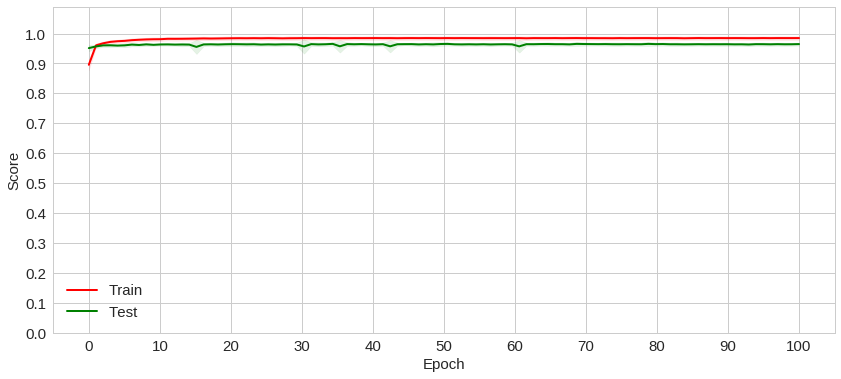

In [38]:
plot_mean_acc(tophist)

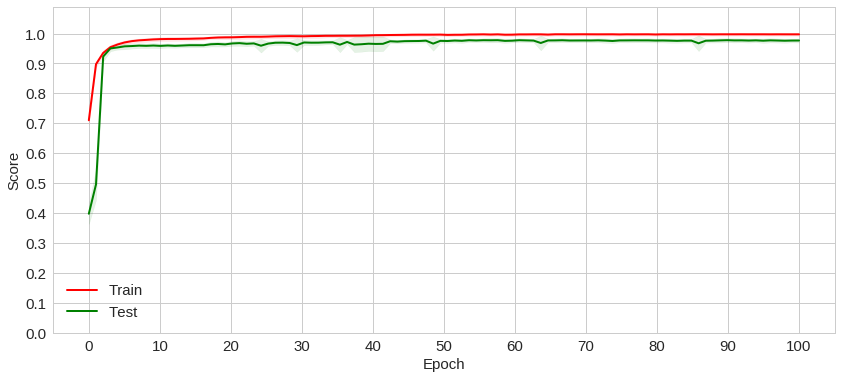

In [39]:
plot_mean_acc(hist)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

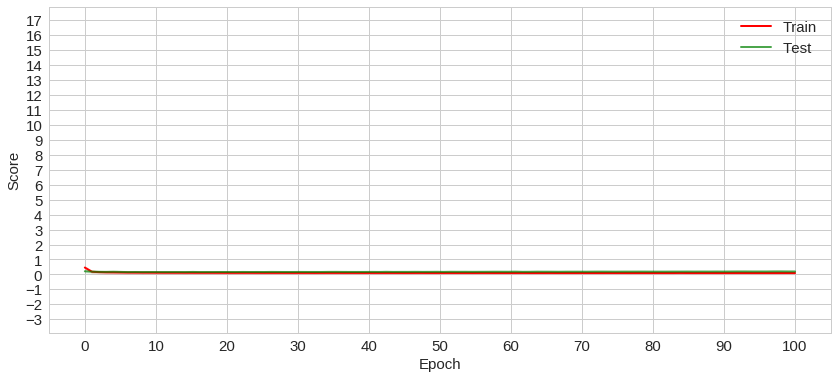

In [41]:
plot_mean_loss(tophist)

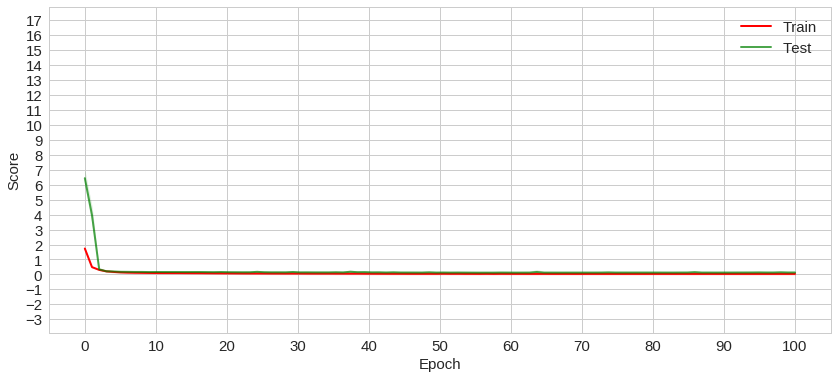

In [42]:
plot_mean_loss(hist)